In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive/11-777 MMML/multilogue-net

/content/gdrive/.shortcut-targets-by-id/1sKygtzdMExNjy2GJE2k9Z6m8S3ehIYG3/11-777 MMML/multilogue-net


In [3]:
! pip install -r requirements.txt

  Using cached absl-py-0.8.1.tar.gz (103 kB)
  Using cached astroid-2.3.3-py3-none-any.whl (205 kB)
  Using cached attrs-19.3.0-py2.py3-none-any.whl (39 kB)
  Using cached autopep8-1.5.tar.gz (116 kB)
  Using cached awscli-1.16.259-py2.py3-none-any.whl (2.3 MB)
  Using cached backcall-0.1.0.zip (11 kB)
  Using cached bleach-3.1.2-py2.py3-none-any.whl (151 kB)
  Using cached botocore-1.12.249-py2.py3-none-any.whl (5.7 MB)
  Using cached certifi-2019.11.28-py2.py3-none-any.whl (156 kB)
  Using cached cffi-1.13.2-cp37-cp37m-manylinux1_x86_64.whl (398 kB)
  Using cached colorama-0.4.1-py2.py3-none-any.whl (15 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached decorator-4.4.1-py2.py3-none-any.whl (9.2 kB)
  Using cached defusedxml-0.6.0-py2.py3-none-any.whl (23 kB)
  Using cached docutils-0.15.2-py3-none-any.whl (547 kB)
  Using cached dominate-2.4.0-py2.py3-none-any.whl (29 kB)
  Using cached enum34-1.1.6-py3-none-any.whl (12 kB)
  Using cached gast-0.3.2.tar.gz 

In [4]:
import numpy as np, torch, torch.nn as nn, torch.optim as optim
import argparse, time, pandas as pd, os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from model import RegressionModel, MaskedMSELoss, BiModalAttention
from original_dataloader import MOSEIRegression

np.random.seed(393)
torch.cuda.device([0])

In [5]:
args = {
    "no_cuda": False,
    "lr": 1e-4,
    "l2": 1e-4,
    "rec_dropout": 0.1,
    "dropout": 0.25,
    "batch_size":128,
    "epochs":250,
    "log_dir": 'logs/moseas_regression'
}
os.makedirs(args["log_dir"], exist_ok = True)

In [6]:
# Run on either GPU or CPU
args["cuda"] = torch.cuda.is_available() and not args["no_cuda"]
if args["cuda"]:
    print('Running on GPU')
else:
    print('Running on CPU')
print("Tensorboard logs in " + args["log_dir"])

Running on GPU
Tensorboard logs in logs/moseas_regression


In [7]:
def get_train_valid_sampler(trainset, valid=0.1):
    size = len(trainset)
    idx = range(size)
    split = int(valid*size)
    return SubsetRandomSampler(idx[split:]), SubsetRandomSampler(idx[:split])

def get_MOSEI_loaders(path, batch_size=128, valid=0.1, num_workers=0, pin_memory=False):
    trainset = MOSEIRegression(path=path)
    train_sampler, valid_sampler = get_train_valid_sampler(trainset, valid)
    train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, collate_fn=trainset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, collate_fn=trainset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    testset = MOSEIRegression(path=path, train=False)
    test_loader = DataLoader(testset, batch_size=batch_size, collate_fn=testset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    return train_loader, valid_loader, test_loader

In [8]:
def train_or_eval_model(model, loss_function, dataloader, epoch, optimizer=None, train=False):    
    losses, preds, labels, masks = [], [], [], []
    assert not train or optimizer!=None
    if train:
        model.train()
    else:
        model.eval()
    for data in dataloader:
        if train:
            optimizer.zero_grad()
        textf, visuf, acouf, qmask, umask, label = [d.cuda() for d in data] if cuda else data
        # jiu jiu hai zi
        # l = label.detach().numpy()
        # print("train_or_eval", (abs(l) <= 1e-5).sum())
        pred = model(textf, acouf, visuf, textf, qmask, umask) 
        labels_ = label.view(-1) 
        umask_ = umask.view(-1) 
        loss = loss_function(pred, labels_, umask_)
        preds.append(pred.data.cpu().numpy())
        labels.append(labels_.data.cpu().numpy())
        masks.append(umask_.cpu().numpy())
        losses.append(loss.item()*masks[-1].sum())
        if train:
            loss.backward()
            optimizer.step()
    if preds!=[]:
        preds  = np.concatenate(preds)
        labels = np.concatenate(labels)
        masks  = np.concatenate(masks)
    else:
        return float('nan'), float('nan'), float('nan'), [], [], []
    avg_loss = round(np.sum(losses)/np.sum(masks),4)
    mae = round(mean_absolute_error(labels,preds,sample_weight=masks),4)
    pred_lab = pd.DataFrame(list(filter(lambda x: x[2]==1, zip(labels, preds, masks))))
    pear = round(pearsonr(pred_lab[0], pred_lab[1])[0], 4)
    return avg_loss, mae, pear, labels, preds, masks

In [9]:

batch_size = args["batch_size"]
n_classes  = 6
cuda       = args["cuda"]
n_epochs   = args["epochs"]
# MOSEI
# D_m_text, D_m_audio, D_m_video, D_m_context = 300, 384, 35, 300
# MOSEAS
# D_m_text, D_m_audio, D_m_video, D_m_context = 300, 25, 35, 300
# MOSEAS_full
D_m_text, D_m_audio, D_m_video, D_m_context = 300, 193, 35, 300
D_g, D_p, D_e, D_h, D_a = 150, 150, 100, 100, 100

In [10]:
# Instantiate model
model = RegressionModel(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])

if cuda:
    model.cuda()
loss_function = MaskedMSELoss()

# Get optimizer and relevant dataloaders
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7,patience=10,verbose=True)
train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/11-777 MMML/multilogue-net/data/moseas_french_full_regression_full_acoustic.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
# train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/multilogue-net/data/regression.pkl', valid=0.0, batch_size=batch_size, num_workers=0)
best_loss, best_label, best_pred, best_mask, best_pear = None, None, None, None, None
all_train_loss, all_test_loss, all_train_mae, all_test_mae, all_train_pear, all_test_pear = [],[],[],[],[],[]

In [56]:
def log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear):
    print("Train Loss - MOSEAS Regression: ", train_loss)
    print("Test Loss - MOSEAS Regression: ", test_loss)
    print("Train MAE - MOSEAS Regression: ", train_mae)
    print("Test MAE - MOSEAS Regression: ", test_mae)
    print("Train Pearson - MOSEAS Regression: ", train_pear)
    print("Test Pearson - MOSEAS Regression: ", test_pear)

    all_train_loss.append(train_loss)
    all_test_loss.append(test_loss)
    all_train_mae.append(train_mae)
    all_test_mae.append(test_mae)
    all_train_pear.append(train_pear)
    all_test_pear.append(test_pear)

In [ ]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, loss_function, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        torch.save(model.state_dict(),f"/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.t7")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 1/200 [00:27<1:31:32, 27.60s/it]

Train Loss - MOSEAS Regression:  0.5761
Test Loss - MOSEAS Regression:  0.4968
Train MAE - MOSEAS Regression:  0.5824
Test MAE - MOSEAS Regression:  0.5494
Train Pearson - MOSEAS Regression:  -0.0506
Test Pearson - MOSEAS Regression:  -0.0382
saving checkpoint for epoch 0


MOSEAS Regression:   1%|          | 2/200 [00:55<1:32:22, 27.99s/it]

Train Loss - MOSEAS Regression:  0.536
Test Loss - MOSEAS Regression:  0.5017
Train MAE - MOSEAS Regression:  0.5644
Test MAE - MOSEAS Regression:  0.5642
Train Pearson - MOSEAS Regression:  -0.0127
Test Pearson - MOSEAS Regression:  -0.042


MOSEAS Regression:   2%|▏         | 3/200 [01:22<1:29:45, 27.34s/it]

Train Loss - MOSEAS Regression:  0.5377
Test Loss - MOSEAS Regression:  0.4982
Train MAE - MOSEAS Regression:  0.5721
Test MAE - MOSEAS Regression:  0.5622
Train Pearson - MOSEAS Regression:  -0.0309
Test Pearson - MOSEAS Regression:  -0.0283


MOSEAS Regression:   2%|▏         | 4/200 [01:50<1:30:38, 27.75s/it]

Train Loss - MOSEAS Regression:  0.5375
Test Loss - MOSEAS Regression:  0.4887
Train MAE - MOSEAS Regression:  0.5743
Test MAE - MOSEAS Regression:  0.5524
Train Pearson - MOSEAS Regression:  -0.0288
Test Pearson - MOSEAS Regression:  -0.0047
saving checkpoint for epoch 3


MOSEAS Regression:   2%|▎         | 5/200 [02:18<1:29:42, 27.60s/it]

Train Loss - MOSEAS Regression:  0.5177
Test Loss - MOSEAS Regression:  0.4811
Train MAE - MOSEAS Regression:  0.5597
Test MAE - MOSEAS Regression:  0.5389
Train Pearson - MOSEAS Regression:  0.0165
Test Pearson - MOSEAS Regression:  0.0309
saving checkpoint for epoch 4


MOSEAS Regression:   3%|▎         | 6/200 [02:40<1:24:00, 25.98s/it]

Train Loss - MOSEAS Regression:  0.5133
Test Loss - MOSEAS Regression:  0.4806
Train MAE - MOSEAS Regression:  0.5515
Test MAE - MOSEAS Regression:  0.5345
Train Pearson - MOSEAS Regression:  0.0165
Test Pearson - MOSEAS Regression:  0.0667
saving checkpoint for epoch 5


MOSEAS Regression:   4%|▎         | 7/200 [03:07<1:24:17, 26.21s/it]

Train Loss - MOSEAS Regression:  0.519
Test Loss - MOSEAS Regression:  0.4804
Train MAE - MOSEAS Regression:  0.5552
Test MAE - MOSEAS Regression:  0.5335
Train Pearson - MOSEAS Regression:  -0.0009
Test Pearson - MOSEAS Regression:  0.0868
saving checkpoint for epoch 6


MOSEAS Regression:   4%|▍         | 8/200 [03:33<1:23:52, 26.21s/it]

Train Loss - MOSEAS Regression:  0.5116
Test Loss - MOSEAS Regression:  0.4792
Train MAE - MOSEAS Regression:  0.5477
Test MAE - MOSEAS Regression:  0.5326
Train Pearson - MOSEAS Regression:  0.0397
Test Pearson - MOSEAS Regression:  0.0999
saving checkpoint for epoch 7


MOSEAS Regression:   4%|▍         | 9/200 [04:00<1:24:04, 26.41s/it]

Train Loss - MOSEAS Regression:  0.4984
Test Loss - MOSEAS Regression:  0.476
Train MAE - MOSEAS Regression:  0.5385
Test MAE - MOSEAS Regression:  0.5318
Train Pearson - MOSEAS Regression:  0.0769
Test Pearson - MOSEAS Regression:  0.1062
saving checkpoint for epoch 8


MOSEAS Regression:   5%|▌         | 10/200 [04:29<1:25:52, 27.12s/it]

Train Loss - MOSEAS Regression:  0.4932
Test Loss - MOSEAS Regression:  0.4734
Train MAE - MOSEAS Regression:  0.5383
Test MAE - MOSEAS Regression:  0.5324
Train Pearson - MOSEAS Regression:  0.0845
Test Pearson - MOSEAS Regression:  0.1089
saving checkpoint for epoch 9


MOSEAS Regression:   6%|▌         | 11/200 [04:57<1:25:58, 27.30s/it]

Train Loss - MOSEAS Regression:  0.4949
Test Loss - MOSEAS Regression:  0.4724
Train MAE - MOSEAS Regression:  0.5411
Test MAE - MOSEAS Regression:  0.5342
Train Pearson - MOSEAS Regression:  0.0754
Test Pearson - MOSEAS Regression:  0.1117
saving checkpoint for epoch 10


MOSEAS Regression:   6%|▌         | 12/200 [05:25<1:26:40, 27.66s/it]

Train Loss - MOSEAS Regression:  0.4951
Test Loss - MOSEAS Regression:  0.4719
Train MAE - MOSEAS Regression:  0.5451
Test MAE - MOSEAS Regression:  0.5351
Train Pearson - MOSEAS Regression:  0.0787
Test Pearson - MOSEAS Regression:  0.1165
saving checkpoint for epoch 11


MOSEAS Regression:   6%|▋         | 13/200 [05:53<1:26:11, 27.66s/it]

Train Loss - MOSEAS Regression:  0.4944
Test Loss - MOSEAS Regression:  0.4711
Train MAE - MOSEAS Regression:  0.5413
Test MAE - MOSEAS Regression:  0.5342
Train Pearson - MOSEAS Regression:  0.0761
Test Pearson - MOSEAS Regression:  0.1236
saving checkpoint for epoch 12


MOSEAS Regression:   7%|▋         | 14/200 [06:19<1:24:48, 27.36s/it]

Train Loss - MOSEAS Regression:  0.4858
Test Loss - MOSEAS Regression:  0.4704
Train MAE - MOSEAS Regression:  0.5392
Test MAE - MOSEAS Regression:  0.5323
Train Pearson - MOSEAS Regression:  0.1127
Test Pearson - MOSEAS Regression:  0.1313
saving checkpoint for epoch 13


MOSEAS Regression:   8%|▊         | 15/200 [06:50<1:27:08, 28.26s/it]

Train Loss - MOSEAS Regression:  0.4885
Test Loss - MOSEAS Regression:  0.4706
Train MAE - MOSEAS Regression:  0.5406
Test MAE - MOSEAS Regression:  0.5309
Train Pearson - MOSEAS Regression:  0.1037
Test Pearson - MOSEAS Regression:  0.1376


MOSEAS Regression:   8%|▊         | 16/200 [07:17<1:25:28, 27.87s/it]

Train Loss - MOSEAS Regression:  0.4847
Test Loss - MOSEAS Regression:  0.4706
Train MAE - MOSEAS Regression:  0.5344
Test MAE - MOSEAS Regression:  0.5304
Train Pearson - MOSEAS Regression:  0.1177
Test Pearson - MOSEAS Regression:  0.1428


MOSEAS Regression:   8%|▊         | 17/200 [07:44<1:24:09, 27.60s/it]

Train Loss - MOSEAS Regression:  0.4798
Test Loss - MOSEAS Regression:  0.4702
Train MAE - MOSEAS Regression:  0.5332
Test MAE - MOSEAS Regression:  0.5302
Train Pearson - MOSEAS Regression:  0.1441
Test Pearson - MOSEAS Regression:  0.1466
saving checkpoint for epoch 16


MOSEAS Regression:   9%|▉         | 18/200 [08:13<1:24:48, 27.96s/it]

Train Loss - MOSEAS Regression:  0.4707
Test Loss - MOSEAS Regression:  0.4691
Train MAE - MOSEAS Regression:  0.527
Test MAE - MOSEAS Regression:  0.5306
Train Pearson - MOSEAS Regression:  0.1747
Test Pearson - MOSEAS Regression:  0.1496
saving checkpoint for epoch 17


MOSEAS Regression:  10%|▉         | 19/200 [08:41<1:24:22, 27.97s/it]

Train Loss - MOSEAS Regression:  0.4703
Test Loss - MOSEAS Regression:  0.4679
Train MAE - MOSEAS Regression:  0.5264
Test MAE - MOSEAS Regression:  0.5318
Train Pearson - MOSEAS Regression:  0.1768
Test Pearson - MOSEAS Regression:  0.1516
saving checkpoint for epoch 18


MOSEAS Regression:  10%|█         | 20/200 [09:09<1:24:44, 28.25s/it]

Train Loss - MOSEAS Regression:  0.4628
Test Loss - MOSEAS Regression:  0.4675
Train MAE - MOSEAS Regression:  0.5224
Test MAE - MOSEAS Regression:  0.5323
Train Pearson - MOSEAS Regression:  0.2023
Test Pearson - MOSEAS Regression:  0.1539
saving checkpoint for epoch 19


MOSEAS Regression:  10%|█         | 21/200 [09:37<1:23:24, 27.96s/it]

Train Loss - MOSEAS Regression:  0.4696
Test Loss - MOSEAS Regression:  0.4672
Train MAE - MOSEAS Regression:  0.5282
Test MAE - MOSEAS Regression:  0.5327
Train Pearson - MOSEAS Regression:  0.1784
Test Pearson - MOSEAS Regression:  0.156
saving checkpoint for epoch 20


MOSEAS Regression:  11%|█         | 22/200 [10:03<1:21:26, 27.45s/it]

Train Loss - MOSEAS Regression:  0.4659
Test Loss - MOSEAS Regression:  0.467
Train MAE - MOSEAS Regression:  0.5254
Test MAE - MOSEAS Regression:  0.5322
Train Pearson - MOSEAS Regression:  0.1997
Test Pearson - MOSEAS Regression:  0.1585
saving checkpoint for epoch 21


MOSEAS Regression:  12%|█▏        | 23/200 [10:30<1:20:22, 27.25s/it]

Train Loss - MOSEAS Regression:  0.461
Test Loss - MOSEAS Regression:  0.4672
Train MAE - MOSEAS Regression:  0.5248
Test MAE - MOSEAS Regression:  0.5312
Train Pearson - MOSEAS Regression:  0.2161
Test Pearson - MOSEAS Regression:  0.1608


MOSEAS Regression:  12%|█▏        | 24/200 [10:58<1:20:33, 27.46s/it]

Train Loss - MOSEAS Regression:  0.4629
Test Loss - MOSEAS Regression:  0.4677
Train MAE - MOSEAS Regression:  0.5238
Test MAE - MOSEAS Regression:  0.5304
Train Pearson - MOSEAS Regression:  0.2078
Test Pearson - MOSEAS Regression:  0.1625


MOSEAS Regression:  12%|█▎        | 25/200 [11:25<1:19:54, 27.40s/it]

Train Loss - MOSEAS Regression:  0.4606
Test Loss - MOSEAS Regression:  0.4679
Train MAE - MOSEAS Regression:  0.5204
Test MAE - MOSEAS Regression:  0.5302
Train Pearson - MOSEAS Regression:  0.2173
Test Pearson - MOSEAS Regression:  0.1639


MOSEAS Regression:  13%|█▎        | 26/200 [11:52<1:19:25, 27.39s/it]

Train Loss - MOSEAS Regression:  0.4628
Test Loss - MOSEAS Regression:  0.4673
Train MAE - MOSEAS Regression:  0.5209
Test MAE - MOSEAS Regression:  0.5306
Train Pearson - MOSEAS Regression:  0.2122
Test Pearson - MOSEAS Regression:  0.1654


MOSEAS Regression:  14%|█▎        | 27/200 [12:19<1:18:26, 27.21s/it]

Train Loss - MOSEAS Regression:  0.4535
Test Loss - MOSEAS Regression:  0.4668
Train MAE - MOSEAS Regression:  0.5156
Test MAE - MOSEAS Regression:  0.5313
Train Pearson - MOSEAS Regression:  0.2413
Test Pearson - MOSEAS Regression:  0.1665
saving checkpoint for epoch 26


MOSEAS Regression:  14%|█▍        | 28/200 [12:45<1:17:03, 26.88s/it]

Train Loss - MOSEAS Regression:  0.453
Test Loss - MOSEAS Regression:  0.4664
Train MAE - MOSEAS Regression:  0.516
Test MAE - MOSEAS Regression:  0.5321
Train Pearson - MOSEAS Regression:  0.2453
Test Pearson - MOSEAS Regression:  0.1677
saving checkpoint for epoch 27


MOSEAS Regression:  14%|█▍        | 29/200 [13:12<1:16:52, 26.97s/it]

Train Loss - MOSEAS Regression:  0.458
Test Loss - MOSEAS Regression:  0.4663
Train MAE - MOSEAS Regression:  0.5206
Test MAE - MOSEAS Regression:  0.5329
Train Pearson - MOSEAS Regression:  0.2292
Test Pearson - MOSEAS Regression:  0.169
saving checkpoint for epoch 28


MOSEAS Regression:  15%|█▌        | 30/200 [13:39<1:16:23, 26.96s/it]

Train Loss - MOSEAS Regression:  0.4519
Test Loss - MOSEAS Regression:  0.4661
Train MAE - MOSEAS Regression:  0.517
Test MAE - MOSEAS Regression:  0.5322
Train Pearson - MOSEAS Regression:  0.2498
Test Pearson - MOSEAS Regression:  0.1708
saving checkpoint for epoch 29


MOSEAS Regression:  16%|█▌        | 31/200 [14:08<1:17:38, 27.56s/it]

Train Loss - MOSEAS Regression:  0.4485
Test Loss - MOSEAS Regression:  0.4661
Train MAE - MOSEAS Regression:  0.5151
Test MAE - MOSEAS Regression:  0.5309
Train Pearson - MOSEAS Regression:  0.2619
Test Pearson - MOSEAS Regression:  0.1729


MOSEAS Regression:  16%|█▌        | 32/200 [14:35<1:16:48, 27.43s/it]

Train Loss - MOSEAS Regression:  0.4464
Test Loss - MOSEAS Regression:  0.4662
Train MAE - MOSEAS Regression:  0.5122
Test MAE - MOSEAS Regression:  0.5304
Train Pearson - MOSEAS Regression:  0.2679
Test Pearson - MOSEAS Regression:  0.1745


MOSEAS Regression:  16%|█▋        | 33/200 [15:02<1:15:23, 27.09s/it]

Train Loss - MOSEAS Regression:  0.4477
Test Loss - MOSEAS Regression:  0.4657
Train MAE - MOSEAS Regression:  0.5123
Test MAE - MOSEAS Regression:  0.531
Train Pearson - MOSEAS Regression:  0.2671
Test Pearson - MOSEAS Regression:  0.1758
saving checkpoint for epoch 32


MOSEAS Regression:  17%|█▋        | 34/200 [15:29<1:15:04, 27.14s/it]

Train Loss - MOSEAS Regression:  0.4445
Test Loss - MOSEAS Regression:  0.4655
Train MAE - MOSEAS Regression:  0.5128
Test MAE - MOSEAS Regression:  0.5318
Train Pearson - MOSEAS Regression:  0.2764
Test Pearson - MOSEAS Regression:  0.1768
saving checkpoint for epoch 33


MOSEAS Regression:  18%|█▊        | 35/200 [15:57<1:15:09, 27.33s/it]

Train Loss - MOSEAS Regression:  0.4403
Test Loss - MOSEAS Regression:  0.4651
Train MAE - MOSEAS Regression:  0.5092
Test MAE - MOSEAS Regression:  0.5316
Train Pearson - MOSEAS Regression:  0.2887
Test Pearson - MOSEAS Regression:  0.1787
saving checkpoint for epoch 34


MOSEAS Regression:  18%|█▊        | 36/200 [16:24<1:14:50, 27.38s/it]

Train Loss - MOSEAS Regression:  0.4412
Test Loss - MOSEAS Regression:  0.4648
Train MAE - MOSEAS Regression:  0.5085
Test MAE - MOSEAS Regression:  0.5307
Train Pearson - MOSEAS Regression:  0.2859
Test Pearson - MOSEAS Regression:  0.1814
saving checkpoint for epoch 35


MOSEAS Regression:  18%|█▊        | 37/200 [16:54<1:16:03, 28.00s/it]

Train Loss - MOSEAS Regression:  0.4422
Test Loss - MOSEAS Regression:  0.4644
Train MAE - MOSEAS Regression:  0.5103
Test MAE - MOSEAS Regression:  0.5304
Train Pearson - MOSEAS Regression:  0.2844
Test Pearson - MOSEAS Regression:  0.1837
saving checkpoint for epoch 36


MOSEAS Regression:  19%|█▉        | 38/200 [17:21<1:15:12, 27.86s/it]

Train Loss - MOSEAS Regression:  0.4434
Test Loss - MOSEAS Regression:  0.464
Train MAE - MOSEAS Regression:  0.5125
Test MAE - MOSEAS Regression:  0.53
Train Pearson - MOSEAS Regression:  0.2811
Test Pearson - MOSEAS Regression:  0.1863
saving checkpoint for epoch 37


MOSEAS Regression:  20%|█▉        | 39/200 [17:48<1:14:13, 27.66s/it]

Train Loss - MOSEAS Regression:  0.4385
Test Loss - MOSEAS Regression:  0.4634
Train MAE - MOSEAS Regression:  0.506
Test MAE - MOSEAS Regression:  0.5307
Train Pearson - MOSEAS Regression:  0.2967
Test Pearson - MOSEAS Regression:  0.1884
saving checkpoint for epoch 38


MOSEAS Regression:  20%|██        | 40/200 [18:18<1:15:01, 28.13s/it]

Train Loss - MOSEAS Regression:  0.4408
Test Loss - MOSEAS Regression:  0.4631
Train MAE - MOSEAS Regression:  0.5075
Test MAE - MOSEAS Regression:  0.531
Train Pearson - MOSEAS Regression:  0.2886
Test Pearson - MOSEAS Regression:  0.1906
saving checkpoint for epoch 39


MOSEAS Regression:  20%|██        | 41/200 [18:44<1:13:10, 27.61s/it]

Train Loss - MOSEAS Regression:  0.4374
Test Loss - MOSEAS Regression:  0.4628
Train MAE - MOSEAS Regression:  0.5086
Test MAE - MOSEAS Regression:  0.5305
Train Pearson - MOSEAS Regression:  0.3
Test Pearson - MOSEAS Regression:  0.1927
saving checkpoint for epoch 40


MOSEAS Regression:  21%|██        | 42/200 [19:13<1:13:48, 28.03s/it]

Train Loss - MOSEAS Regression:  0.4343
Test Loss - MOSEAS Regression:  0.4623
Train MAE - MOSEAS Regression:  0.504
Test MAE - MOSEAS Regression:  0.5291
Train Pearson - MOSEAS Regression:  0.3096
Test Pearson - MOSEAS Regression:  0.1955
saving checkpoint for epoch 41


MOSEAS Regression:  22%|██▏       | 43/200 [19:39<1:11:57, 27.50s/it]

Train Loss - MOSEAS Regression:  0.4305
Test Loss - MOSEAS Regression:  0.4619
Train MAE - MOSEAS Regression:  0.5026
Test MAE - MOSEAS Regression:  0.5291
Train Pearson - MOSEAS Regression:  0.3225
Test Pearson - MOSEAS Regression:  0.1974
saving checkpoint for epoch 42


MOSEAS Regression:  22%|██▏       | 44/200 [20:06<1:10:35, 27.15s/it]

Train Loss - MOSEAS Regression:  0.4306
Test Loss - MOSEAS Regression:  0.4616
Train MAE - MOSEAS Regression:  0.5036
Test MAE - MOSEAS Regression:  0.5303
Train Pearson - MOSEAS Regression:  0.3227
Test Pearson - MOSEAS Regression:  0.1988
saving checkpoint for epoch 43


MOSEAS Regression:  22%|██▎       | 45/200 [20:33<1:10:15, 27.20s/it]

Train Loss - MOSEAS Regression:  0.4266
Test Loss - MOSEAS Regression:  0.4615
Train MAE - MOSEAS Regression:  0.5006
Test MAE - MOSEAS Regression:  0.531
Train Pearson - MOSEAS Regression:  0.334
Test Pearson - MOSEAS Regression:  0.2003
saving checkpoint for epoch 44


MOSEAS Regression:  23%|██▎       | 46/200 [20:57<1:07:45, 26.40s/it]

Train Loss - MOSEAS Regression:  0.4304
Test Loss - MOSEAS Regression:  0.4607
Train MAE - MOSEAS Regression:  0.504
Test MAE - MOSEAS Regression:  0.5298
Train Pearson - MOSEAS Regression:  0.3228
Test Pearson - MOSEAS Regression:  0.203
saving checkpoint for epoch 45


MOSEAS Regression:  24%|██▎       | 47/200 [21:26<1:09:16, 27.17s/it]

Train Loss - MOSEAS Regression:  0.4259
Test Loss - MOSEAS Regression:  0.4602
Train MAE - MOSEAS Regression:  0.4981
Test MAE - MOSEAS Regression:  0.528
Train Pearson - MOSEAS Regression:  0.3358
Test Pearson - MOSEAS Regression:  0.2053
saving checkpoint for epoch 46


MOSEAS Regression:  24%|██▍       | 48/200 [21:55<1:09:32, 27.45s/it]

Train Loss - MOSEAS Regression:  0.4271
Test Loss - MOSEAS Regression:  0.4597
Train MAE - MOSEAS Regression:  0.5001
Test MAE - MOSEAS Regression:  0.5283
Train Pearson - MOSEAS Regression:  0.3338
Test Pearson - MOSEAS Regression:  0.2069
saving checkpoint for epoch 47


MOSEAS Regression:  24%|██▍       | 49/200 [22:23<1:09:41, 27.69s/it]

Train Loss - MOSEAS Regression:  0.4274
Test Loss - MOSEAS Regression:  0.4603
Train MAE - MOSEAS Regression:  0.4996
Test MAE - MOSEAS Regression:  0.5312
Train Pearson - MOSEAS Regression:  0.3327
Test Pearson - MOSEAS Regression:  0.2073


MOSEAS Regression:  25%|██▌       | 50/200 [22:50<1:08:49, 27.53s/it]

Train Loss - MOSEAS Regression:  0.4281
Test Loss - MOSEAS Regression:  0.4596
Train MAE - MOSEAS Regression:  0.5029
Test MAE - MOSEAS Regression:  0.5305
Train Pearson - MOSEAS Regression:  0.3298
Test Pearson - MOSEAS Regression:  0.2092
saving checkpoint for epoch 49


MOSEAS Regression:  26%|██▌       | 51/200 [23:15<1:06:50, 26.92s/it]

Train Loss - MOSEAS Regression:  0.4271
Test Loss - MOSEAS Regression:  0.4586
Train MAE - MOSEAS Regression:  0.5015
Test MAE - MOSEAS Regression:  0.527
Train Pearson - MOSEAS Regression:  0.3326
Test Pearson - MOSEAS Regression:  0.2126
saving checkpoint for epoch 50


MOSEAS Regression:  26%|██▌       | 52/200 [23:45<1:08:03, 27.59s/it]

Train Loss - MOSEAS Regression:  0.426
Test Loss - MOSEAS Regression:  0.4587
Train MAE - MOSEAS Regression:  0.4984
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.3383
Test Pearson - MOSEAS Regression:  0.2144


MOSEAS Regression:  26%|██▋       | 53/200 [24:13<1:07:54, 27.72s/it]

Train Loss - MOSEAS Regression:  0.4201
Test Loss - MOSEAS Regression:  0.4581
Train MAE - MOSEAS Regression:  0.4955
Test MAE - MOSEAS Regression:  0.5283
Train Pearson - MOSEAS Regression:  0.3553
Test Pearson - MOSEAS Regression:  0.2145
saving checkpoint for epoch 52


MOSEAS Regression:  27%|██▋       | 54/200 [24:40<1:07:09, 27.60s/it]

Train Loss - MOSEAS Regression:  0.4191
Test Loss - MOSEAS Regression:  0.4602
Train MAE - MOSEAS Regression:  0.4969
Test MAE - MOSEAS Regression:  0.5319
Train Pearson - MOSEAS Regression:  0.3559
Test Pearson - MOSEAS Regression:  0.2129


MOSEAS Regression:  28%|██▊       | 55/200 [25:04<1:04:22, 26.64s/it]

Train Loss - MOSEAS Regression:  0.4199
Test Loss - MOSEAS Regression:  0.4594
Train MAE - MOSEAS Regression:  0.4972
Test MAE - MOSEAS Regression:  0.5311
Train Pearson - MOSEAS Regression:  0.3555
Test Pearson - MOSEAS Regression:  0.2153


MOSEAS Regression:  28%|██▊       | 56/200 [25:32<1:04:21, 26.82s/it]

Train Loss - MOSEAS Regression:  0.416
Test Loss - MOSEAS Regression:  0.4573
Train MAE - MOSEAS Regression:  0.4942
Test MAE - MOSEAS Regression:  0.5258
Train Pearson - MOSEAS Regression:  0.3655
Test Pearson - MOSEAS Regression:  0.2211
saving checkpoint for epoch 55


MOSEAS Regression:  28%|██▊       | 57/200 [25:59<1:04:11, 26.93s/it]

Train Loss - MOSEAS Regression:  0.4164
Test Loss - MOSEAS Regression:  0.4566
Train MAE - MOSEAS Regression:  0.4931
Test MAE - MOSEAS Regression:  0.5256
Train Pearson - MOSEAS Regression:  0.3669
Test Pearson - MOSEAS Regression:  0.2232
saving checkpoint for epoch 56


MOSEAS Regression:  29%|██▉       | 58/200 [26:26<1:03:38, 26.89s/it]

Train Loss - MOSEAS Regression:  0.419
Test Loss - MOSEAS Regression:  0.4563
Train MAE - MOSEAS Regression:  0.4955
Test MAE - MOSEAS Regression:  0.5282
Train Pearson - MOSEAS Regression:  0.3573
Test Pearson - MOSEAS Regression:  0.2235
saving checkpoint for epoch 57


MOSEAS Regression:  30%|██▉       | 59/200 [26:56<1:05:39, 27.94s/it]

Train Loss - MOSEAS Regression:  0.4081
Test Loss - MOSEAS Regression:  0.4559
Train MAE - MOSEAS Regression:  0.4905
Test MAE - MOSEAS Regression:  0.5283
Train Pearson - MOSEAS Regression:  0.3868
Test Pearson - MOSEAS Regression:  0.2256
saving checkpoint for epoch 58


MOSEAS Regression:  30%|███       | 60/200 [27:22<1:04:06, 27.47s/it]

Train Loss - MOSEAS Regression:  0.4119
Test Loss - MOSEAS Regression:  0.4547
Train MAE - MOSEAS Regression:  0.4901
Test MAE - MOSEAS Regression:  0.5265
Train Pearson - MOSEAS Regression:  0.3764
Test Pearson - MOSEAS Regression:  0.2289
saving checkpoint for epoch 59


MOSEAS Regression:  30%|███       | 61/200 [27:49<1:02:51, 27.14s/it]

Train Loss - MOSEAS Regression:  0.4101
Test Loss - MOSEAS Regression:  0.4541
Train MAE - MOSEAS Regression:  0.4893
Test MAE - MOSEAS Regression:  0.5254
Train Pearson - MOSEAS Regression:  0.3815
Test Pearson - MOSEAS Regression:  0.2313
saving checkpoint for epoch 60


MOSEAS Regression:  31%|███       | 62/200 [28:18<1:04:03, 27.85s/it]

Train Loss - MOSEAS Regression:  0.4223
Test Loss - MOSEAS Regression:  0.454
Train MAE - MOSEAS Regression:  0.4974
Test MAE - MOSEAS Regression:  0.5262
Train Pearson - MOSEAS Regression:  0.3502
Test Pearson - MOSEAS Regression:  0.232
saving checkpoint for epoch 61


MOSEAS Regression:  32%|███▏      | 63/200 [28:45<1:03:11, 27.68s/it]

Train Loss - MOSEAS Regression:  0.4081
Test Loss - MOSEAS Regression:  0.4542
Train MAE - MOSEAS Regression:  0.4886
Test MAE - MOSEAS Regression:  0.5264
Train Pearson - MOSEAS Regression:  0.3868
Test Pearson - MOSEAS Regression:  0.2323


MOSEAS Regression:  32%|███▏      | 64/200 [29:15<1:03:40, 28.09s/it]

Train Loss - MOSEAS Regression:  0.4135
Test Loss - MOSEAS Regression:  0.4557
Train MAE - MOSEAS Regression:  0.4924
Test MAE - MOSEAS Regression:  0.5283
Train Pearson - MOSEAS Regression:  0.3731
Test Pearson - MOSEAS Regression:  0.2305


MOSEAS Regression:  32%|███▎      | 65/200 [29:43<1:03:14, 28.11s/it]

Train Loss - MOSEAS Regression:  0.4064
Test Loss - MOSEAS Regression:  0.4547
Train MAE - MOSEAS Regression:  0.4891
Test MAE - MOSEAS Regression:  0.5271
Train Pearson - MOSEAS Regression:  0.3915
Test Pearson - MOSEAS Regression:  0.2324


MOSEAS Regression:  33%|███▎      | 66/200 [30:12<1:03:30, 28.44s/it]

Train Loss - MOSEAS Regression:  0.4076
Test Loss - MOSEAS Regression:  0.4538
Train MAE - MOSEAS Regression:  0.4895
Test MAE - MOSEAS Regression:  0.5251
Train Pearson - MOSEAS Regression:  0.388
Test Pearson - MOSEAS Regression:  0.2354
saving checkpoint for epoch 65


MOSEAS Regression:  34%|███▎      | 67/200 [30:41<1:03:28, 28.64s/it]

Train Loss - MOSEAS Regression:  0.4015
Test Loss - MOSEAS Regression:  0.4539
Train MAE - MOSEAS Regression:  0.4854
Test MAE - MOSEAS Regression:  0.5253
Train Pearson - MOSEAS Regression:  0.4051
Test Pearson - MOSEAS Regression:  0.2359


MOSEAS Regression:  34%|███▍      | 68/200 [31:09<1:02:38, 28.48s/it]

Train Loss - MOSEAS Regression:  0.3978
Test Loss - MOSEAS Regression:  0.4561
Train MAE - MOSEAS Regression:  0.4836
Test MAE - MOSEAS Regression:  0.5286
Train Pearson - MOSEAS Regression:  0.4136
Test Pearson - MOSEAS Regression:  0.2339


MOSEAS Regression:  34%|███▍      | 69/200 [31:37<1:02:01, 28.41s/it]

Train Loss - MOSEAS Regression:  0.4022
Test Loss - MOSEAS Regression:  0.4547
Train MAE - MOSEAS Regression:  0.4869
Test MAE - MOSEAS Regression:  0.5271
Train Pearson - MOSEAS Regression:  0.4032
Test Pearson - MOSEAS Regression:  0.2363


MOSEAS Regression:  35%|███▌      | 70/200 [32:04<1:00:06, 27.74s/it]

Train Loss - MOSEAS Regression:  0.404
Test Loss - MOSEAS Regression:  0.4535
Train MAE - MOSEAS Regression:  0.4857
Test MAE - MOSEAS Regression:  0.5242
Train Pearson - MOSEAS Regression:  0.3983
Test Pearson - MOSEAS Regression:  0.24
saving checkpoint for epoch 69


MOSEAS Regression:  36%|███▌      | 71/200 [32:33<1:00:26, 28.11s/it]

Train Loss - MOSEAS Regression:  0.3996
Test Loss - MOSEAS Regression:  0.456
Train MAE - MOSEAS Regression:  0.4828
Test MAE - MOSEAS Regression:  0.5286
Train Pearson - MOSEAS Regression:  0.411
Test Pearson - MOSEAS Regression:  0.2372


MOSEAS Regression:  36%|███▌      | 72/200 [32:59<58:58, 27.65s/it]  

Train Loss - MOSEAS Regression:  0.404
Test Loss - MOSEAS Regression:  0.4543
Train MAE - MOSEAS Regression:  0.4872
Test MAE - MOSEAS Regression:  0.5271
Train Pearson - MOSEAS Regression:  0.4007
Test Pearson - MOSEAS Regression:  0.2404


MOSEAS Regression:  36%|███▋      | 73/200 [33:28<59:12, 27.98s/it]

Train Loss - MOSEAS Regression:  0.4001
Test Loss - MOSEAS Regression:  0.4527
Train MAE - MOSEAS Regression:  0.4867
Test MAE - MOSEAS Regression:  0.5227
Train Pearson - MOSEAS Regression:  0.4077
Test Pearson - MOSEAS Regression:  0.246
saving checkpoint for epoch 72


MOSEAS Regression:  37%|███▋      | 74/200 [33:57<59:25, 28.30s/it]

Train Loss - MOSEAS Regression:  0.3929
Test Loss - MOSEAS Regression:  0.4522
Train MAE - MOSEAS Regression:  0.4775
Test MAE - MOSEAS Regression:  0.5252
Train Pearson - MOSEAS Regression:  0.4304
Test Pearson - MOSEAS Regression:  0.2456
saving checkpoint for epoch 73


MOSEAS Regression:  38%|███▊      | 75/200 [34:24<58:23, 28.03s/it]

Train Loss - MOSEAS Regression:  0.3963
Test Loss - MOSEAS Regression:  0.46
Train MAE - MOSEAS Regression:  0.4821
Test MAE - MOSEAS Regression:  0.5327
Train Pearson - MOSEAS Regression:  0.4175
Test Pearson - MOSEAS Regression:  0.2391


MOSEAS Regression:  38%|███▊      | 76/200 [34:52<57:33, 27.85s/it]

Train Loss - MOSEAS Regression:  0.3959
Test Loss - MOSEAS Regression:  0.451
Train MAE - MOSEAS Regression:  0.4853
Test MAE - MOSEAS Regression:  0.5237
Train Pearson - MOSEAS Regression:  0.4248
Test Pearson - MOSEAS Regression:  0.2491
saving checkpoint for epoch 75


MOSEAS Regression:  38%|███▊      | 77/200 [35:18<56:13, 27.42s/it]

Train Loss - MOSEAS Regression:  0.3926
Test Loss - MOSEAS Regression:  0.4516
Train MAE - MOSEAS Regression:  0.4777
Test MAE - MOSEAS Regression:  0.5215
Train Pearson - MOSEAS Regression:  0.4294
Test Pearson - MOSEAS Regression:  0.2527


MOSEAS Regression:  39%|███▉      | 78/200 [35:45<55:18, 27.20s/it]

Train Loss - MOSEAS Regression:  0.3877
Test Loss - MOSEAS Regression:  0.4543
Train MAE - MOSEAS Regression:  0.4745
Test MAE - MOSEAS Regression:  0.5274
Train Pearson - MOSEAS Regression:  0.4437
Test Pearson - MOSEAS Regression:  0.2487


MOSEAS Regression:  40%|███▉      | 79/200 [36:12<54:57, 27.26s/it]

Train Loss - MOSEAS Regression:  0.3954
Test Loss - MOSEAS Regression:  0.4546
Train MAE - MOSEAS Regression:  0.4844
Test MAE - MOSEAS Regression:  0.5277
Train Pearson - MOSEAS Regression:  0.4242
Test Pearson - MOSEAS Regression:  0.2506


MOSEAS Regression:  40%|████      | 80/200 [36:39<54:01, 27.01s/it]

Train Loss - MOSEAS Regression:  0.3911
Test Loss - MOSEAS Regression:  0.4501
Train MAE - MOSEAS Regression:  0.4808
Test MAE - MOSEAS Regression:  0.5205
Train Pearson - MOSEAS Regression:  0.432
Test Pearson - MOSEAS Regression:  0.2595
saving checkpoint for epoch 79


MOSEAS Regression:  40%|████      | 81/200 [37:11<57:00, 28.75s/it]

Train Loss - MOSEAS Regression:  0.3934
Test Loss - MOSEAS Regression:  0.4493
Train MAE - MOSEAS Regression:  0.4802
Test MAE - MOSEAS Regression:  0.5205
Train Pearson - MOSEAS Regression:  0.4319
Test Pearson - MOSEAS Regression:  0.261
saving checkpoint for epoch 80


MOSEAS Regression:  41%|████      | 82/200 [37:39<55:50, 28.39s/it]

Train Loss - MOSEAS Regression:  0.388
Test Loss - MOSEAS Regression:  0.4562
Train MAE - MOSEAS Regression:  0.4756
Test MAE - MOSEAS Regression:  0.5294
Train Pearson - MOSEAS Regression:  0.4391
Test Pearson - MOSEAS Regression:  0.2548


MOSEAS Regression:  42%|████▏     | 83/200 [38:08<55:44, 28.58s/it]

Train Loss - MOSEAS Regression:  0.396
Test Loss - MOSEAS Regression:  0.4499
Train MAE - MOSEAS Regression:  0.4857
Test MAE - MOSEAS Regression:  0.5239
Train Pearson - MOSEAS Regression:  0.4282
Test Pearson - MOSEAS Regression:  0.2603


MOSEAS Regression:  42%|████▏     | 84/200 [38:35<54:29, 28.19s/it]

Train Loss - MOSEAS Regression:  0.3845
Test Loss - MOSEAS Regression:  0.4501
Train MAE - MOSEAS Regression:  0.4767
Test MAE - MOSEAS Regression:  0.5193
Train Pearson - MOSEAS Regression:  0.4459
Test Pearson - MOSEAS Regression:  0.2648


MOSEAS Regression:  42%|████▎     | 85/200 [39:04<54:28, 28.43s/it]

Train Loss - MOSEAS Regression:  0.3911
Test Loss - MOSEAS Regression:  0.4473
Train MAE - MOSEAS Regression:  0.4786
Test MAE - MOSEAS Regression:  0.5205
Train Pearson - MOSEAS Regression:  0.4383
Test Pearson - MOSEAS Regression:  0.2652
saving checkpoint for epoch 84


MOSEAS Regression:  43%|████▎     | 86/200 [39:32<53:24, 28.11s/it]

Train Loss - MOSEAS Regression:  0.3916
Test Loss - MOSEAS Regression:  0.4526
Train MAE - MOSEAS Regression:  0.481
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.429
Test Pearson - MOSEAS Regression:  0.2599


MOSEAS Regression:  44%|████▎     | 87/200 [39:58<52:08, 27.68s/it]

Train Loss - MOSEAS Regression:  0.3805
Test Loss - MOSEAS Regression:  0.4487
Train MAE - MOSEAS Regression:  0.4733
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.4586
Test Pearson - MOSEAS Regression:  0.2631


MOSEAS Regression:  44%|████▍     | 88/200 [40:26<51:32, 27.61s/it]

Train Loss - MOSEAS Regression:  0.3843
Test Loss - MOSEAS Regression:  0.4476
Train MAE - MOSEAS Regression:  0.4745
Test MAE - MOSEAS Regression:  0.5199
Train Pearson - MOSEAS Regression:  0.4464
Test Pearson - MOSEAS Regression:  0.2658


MOSEAS Regression:  44%|████▍     | 89/200 [40:55<51:49, 28.01s/it]

Train Loss - MOSEAS Regression:  0.3837
Test Loss - MOSEAS Regression:  0.4476
Train MAE - MOSEAS Regression:  0.4735
Test MAE - MOSEAS Regression:  0.5207
Train Pearson - MOSEAS Regression:  0.4492
Test Pearson - MOSEAS Regression:  0.2655


MOSEAS Regression:  45%|████▌     | 90/200 [41:23<51:25, 28.05s/it]

Train Loss - MOSEAS Regression:  0.3815
Test Loss - MOSEAS Regression:  0.4507
Train MAE - MOSEAS Regression:  0.4726
Test MAE - MOSEAS Regression:  0.5242
Train Pearson - MOSEAS Regression:  0.4534
Test Pearson - MOSEAS Regression:  0.2628


MOSEAS Regression:  46%|████▌     | 91/200 [41:50<50:32, 27.82s/it]

Train Loss - MOSEAS Regression:  0.3803
Test Loss - MOSEAS Regression:  0.448
Train MAE - MOSEAS Regression:  0.4732
Test MAE - MOSEAS Regression:  0.5215
Train Pearson - MOSEAS Regression:  0.4588
Test Pearson - MOSEAS Regression:  0.2666


MOSEAS Regression:  46%|████▌     | 92/200 [42:17<49:20, 27.42s/it]

Train Loss - MOSEAS Regression:  0.3815
Test Loss - MOSEAS Regression:  0.4474
Train MAE - MOSEAS Regression:  0.4734
Test MAE - MOSEAS Regression:  0.5187
Train Pearson - MOSEAS Regression:  0.4528
Test Pearson - MOSEAS Regression:  0.2711


MOSEAS Regression:  46%|████▋     | 93/200 [42:46<49:46, 27.91s/it]

Train Loss - MOSEAS Regression:  0.3826
Test Loss - MOSEAS Regression:  0.4462
Train MAE - MOSEAS Regression:  0.4726
Test MAE - MOSEAS Regression:  0.5192
Train Pearson - MOSEAS Regression:  0.4537
Test Pearson - MOSEAS Regression:  0.2725
saving checkpoint for epoch 92


MOSEAS Regression:  47%|████▋     | 94/200 [43:12<48:32, 27.48s/it]

Train Loss - MOSEAS Regression:  0.3817
Test Loss - MOSEAS Regression:  0.4482
Train MAE - MOSEAS Regression:  0.4756
Test MAE - MOSEAS Regression:  0.5225
Train Pearson - MOSEAS Regression:  0.4522
Test Pearson - MOSEAS Regression:  0.2725


MOSEAS Regression:  48%|████▊     | 95/200 [43:41<48:53, 27.94s/it]

Train Loss - MOSEAS Regression:  0.3816
Test Loss - MOSEAS Regression:  0.4462
Train MAE - MOSEAS Regression:  0.4739
Test MAE - MOSEAS Regression:  0.5206
Train Pearson - MOSEAS Regression:  0.4533
Test Pearson - MOSEAS Regression:  0.2756


MOSEAS Regression:  48%|████▊     | 96/200 [44:10<48:42, 28.10s/it]

Train Loss - MOSEAS Regression:  0.3797
Test Loss - MOSEAS Regression:  0.4447
Train MAE - MOSEAS Regression:  0.4722
Test MAE - MOSEAS Regression:  0.5186
Train Pearson - MOSEAS Regression:  0.4568
Test Pearson - MOSEAS Regression:  0.2781
saving checkpoint for epoch 95


MOSEAS Regression:  48%|████▊     | 97/200 [44:38<48:28, 28.24s/it]

Train Loss - MOSEAS Regression:  0.3818
Test Loss - MOSEAS Regression:  0.4467
Train MAE - MOSEAS Regression:  0.4743
Test MAE - MOSEAS Regression:  0.5209
Train Pearson - MOSEAS Regression:  0.4531
Test Pearson - MOSEAS Regression:  0.2773


MOSEAS Regression:  49%|████▉     | 98/200 [45:08<48:37, 28.61s/it]

Train Loss - MOSEAS Regression:  0.3781
Test Loss - MOSEAS Regression:  0.4446
Train MAE - MOSEAS Regression:  0.473
Test MAE - MOSEAS Regression:  0.5185
Train Pearson - MOSEAS Regression:  0.4613
Test Pearson - MOSEAS Regression:  0.2792
saving checkpoint for epoch 97


MOSEAS Regression:  50%|████▉     | 99/200 [45:36<48:03, 28.55s/it]

Train Loss - MOSEAS Regression:  0.3808
Test Loss - MOSEAS Regression:  0.4444
Train MAE - MOSEAS Regression:  0.4749
Test MAE - MOSEAS Regression:  0.5168
Train Pearson - MOSEAS Regression:  0.4544
Test Pearson - MOSEAS Regression:  0.2809
saving checkpoint for epoch 98


MOSEAS Regression:  50%|█████     | 100/200 [46:05<48:00, 28.81s/it]

Train Loss - MOSEAS Regression:  0.3758
Test Loss - MOSEAS Regression:  0.4454
Train MAE - MOSEAS Regression:  0.4702
Test MAE - MOSEAS Regression:  0.5191
Train Pearson - MOSEAS Regression:  0.4667
Test Pearson - MOSEAS Regression:  0.2792


MOSEAS Regression:  50%|█████     | 101/200 [46:33<46:54, 28.43s/it]

Train Loss - MOSEAS Regression:  0.3797
Test Loss - MOSEAS Regression:  0.4457
Train MAE - MOSEAS Regression:  0.4726
Test MAE - MOSEAS Regression:  0.5194
Train Pearson - MOSEAS Regression:  0.4579
Test Pearson - MOSEAS Regression:  0.2797


MOSEAS Regression:  51%|█████     | 102/200 [47:02<46:27, 28.44s/it]

Train Loss - MOSEAS Regression:  0.3789
Test Loss - MOSEAS Regression:  0.4452
Train MAE - MOSEAS Regression:  0.473
Test MAE - MOSEAS Regression:  0.5163
Train Pearson - MOSEAS Regression:  0.4589
Test Pearson - MOSEAS Regression:  0.284


MOSEAS Regression:  52%|█████▏    | 103/200 [47:34<48:08, 29.78s/it]

Train Loss - MOSEAS Regression:  0.3833
Test Loss - MOSEAS Regression:  0.4442
Train MAE - MOSEAS Regression:  0.4744
Test MAE - MOSEAS Regression:  0.5182
Train Pearson - MOSEAS Regression:  0.4545
Test Pearson - MOSEAS Regression:  0.283
saving checkpoint for epoch 102


MOSEAS Regression:  52%|█████▏    | 104/200 [48:03<47:10, 29.48s/it]

Train Loss - MOSEAS Regression:  0.3761
Test Loss - MOSEAS Regression:  0.4532
Train MAE - MOSEAS Regression:  0.4682
Test MAE - MOSEAS Regression:  0.5271
Train Pearson - MOSEAS Regression:  0.465
Test Pearson - MOSEAS Regression:  0.2777


MOSEAS Regression:  52%|█████▎    | 105/200 [48:33<46:36, 29.43s/it]

Train Loss - MOSEAS Regression:  0.382
Test Loss - MOSEAS Regression:  0.4428
Train MAE - MOSEAS Regression:  0.4748
Test MAE - MOSEAS Regression:  0.5167
Train Pearson - MOSEAS Regression:  0.4589
Test Pearson - MOSEAS Regression:  0.2863
saving checkpoint for epoch 104


MOSEAS Regression:  53%|█████▎    | 106/200 [49:00<45:19, 28.93s/it]

Train Loss - MOSEAS Regression:  0.3817
Test Loss - MOSEAS Regression:  0.4429
Train MAE - MOSEAS Regression:  0.4724
Test MAE - MOSEAS Regression:  0.5155
Train Pearson - MOSEAS Regression:  0.4568
Test Pearson - MOSEAS Regression:  0.2883


MOSEAS Regression:  54%|█████▎    | 107/200 [49:27<43:52, 28.31s/it]

Train Loss - MOSEAS Regression:  0.3775
Test Loss - MOSEAS Regression:  0.4468
Train MAE - MOSEAS Regression:  0.4702
Test MAE - MOSEAS Regression:  0.5216
Train Pearson - MOSEAS Regression:  0.4658
Test Pearson - MOSEAS Regression:  0.2839


MOSEAS Regression:  54%|█████▍    | 108/200 [49:56<43:48, 28.57s/it]

Train Loss - MOSEAS Regression:  0.3772
Test Loss - MOSEAS Regression:  0.445
Train MAE - MOSEAS Regression:  0.472
Test MAE - MOSEAS Regression:  0.52
Train Pearson - MOSEAS Regression:  0.4654
Test Pearson - MOSEAS Regression:  0.2863


MOSEAS Regression:  55%|█████▍    | 109/200 [50:24<42:55, 28.31s/it]

Train Loss - MOSEAS Regression:  0.3747
Test Loss - MOSEAS Regression:  0.4404
Train MAE - MOSEAS Regression:  0.4703
Test MAE - MOSEAS Regression:  0.515
Train Pearson - MOSEAS Regression:  0.4685
Test Pearson - MOSEAS Regression:  0.2922
saving checkpoint for epoch 108


MOSEAS Regression:  55%|█████▌    | 110/200 [50:53<42:35, 28.40s/it]

Train Loss - MOSEAS Regression:  0.3739
Test Loss - MOSEAS Regression:  0.44
Train MAE - MOSEAS Regression:  0.4678
Test MAE - MOSEAS Regression:  0.515
Train Pearson - MOSEAS Regression:  0.4712
Test Pearson - MOSEAS Regression:  0.2937
saving checkpoint for epoch 109


MOSEAS Regression:  56%|█████▌    | 111/200 [51:19<41:00, 27.65s/it]

Train Loss - MOSEAS Regression:  0.3707
Test Loss - MOSEAS Regression:  0.4405
Train MAE - MOSEAS Regression:  0.4671
Test MAE - MOSEAS Regression:  0.5159
Train Pearson - MOSEAS Regression:  0.4774
Test Pearson - MOSEAS Regression:  0.2943


MOSEAS Regression:  56%|█████▌    | 112/200 [51:46<40:29, 27.61s/it]

Train Loss - MOSEAS Regression:  0.3739
Test Loss - MOSEAS Regression:  0.4395
Train MAE - MOSEAS Regression:  0.4687
Test MAE - MOSEAS Regression:  0.5145
Train Pearson - MOSEAS Regression:  0.4699
Test Pearson - MOSEAS Regression:  0.2969
saving checkpoint for epoch 111


MOSEAS Regression:  56%|█████▋    | 113/200 [52:14<40:23, 27.86s/it]

Train Loss - MOSEAS Regression:  0.3712
Test Loss - MOSEAS Regression:  0.4393
Train MAE - MOSEAS Regression:  0.4658
Test MAE - MOSEAS Regression:  0.514
Train Pearson - MOSEAS Regression:  0.4759
Test Pearson - MOSEAS Regression:  0.2986
saving checkpoint for epoch 112


MOSEAS Regression:  57%|█████▋    | 114/200 [52:44<40:27, 28.22s/it]

Train Loss - MOSEAS Regression:  0.3684
Test Loss - MOSEAS Regression:  0.4397
Train MAE - MOSEAS Regression:  0.4664
Test MAE - MOSEAS Regression:  0.5154
Train Pearson - MOSEAS Regression:  0.4821
Test Pearson - MOSEAS Regression:  0.2991


MOSEAS Regression:  57%|█████▊    | 115/200 [53:13<40:20, 28.47s/it]

Train Loss - MOSEAS Regression:  0.3732
Test Loss - MOSEAS Regression:  0.4398
Train MAE - MOSEAS Regression:  0.4707
Test MAE - MOSEAS Regression:  0.5154
Train Pearson - MOSEAS Regression:  0.4721
Test Pearson - MOSEAS Regression:  0.2994


MOSEAS Regression:  58%|█████▊    | 116/200 [53:39<38:48, 27.73s/it]

Train Loss - MOSEAS Regression:  0.3704
Test Loss - MOSEAS Regression:  0.4395
Train MAE - MOSEAS Regression:  0.4686
Test MAE - MOSEAS Regression:  0.5139
Train Pearson - MOSEAS Regression:  0.4778
Test Pearson - MOSEAS Regression:  0.3001


MOSEAS Regression:  58%|█████▊    | 117/200 [54:08<38:54, 28.13s/it]

Train Loss - MOSEAS Regression:  0.373
Test Loss - MOSEAS Regression:  0.4396
Train MAE - MOSEAS Regression:  0.4673
Test MAE - MOSEAS Regression:  0.5146
Train Pearson - MOSEAS Regression:  0.4736
Test Pearson - MOSEAS Regression:  0.2994


MOSEAS Regression:  59%|█████▉    | 118/200 [54:37<38:44, 28.35s/it]

Train Loss - MOSEAS Regression:  0.3673
Test Loss - MOSEAS Regression:  0.4419
Train MAE - MOSEAS Regression:  0.4652
Test MAE - MOSEAS Regression:  0.5169
Train Pearson - MOSEAS Regression:  0.4842
Test Pearson - MOSEAS Regression:  0.2972


MOSEAS Regression:  60%|█████▉    | 119/200 [55:06<38:34, 28.57s/it]

Train Loss - MOSEAS Regression:  0.3699
Test Loss - MOSEAS Regression:  0.439
Train MAE - MOSEAS Regression:  0.4669
Test MAE - MOSEAS Regression:  0.5136
Train Pearson - MOSEAS Regression:  0.4798
Test Pearson - MOSEAS Regression:  0.3006
saving checkpoint for epoch 118


MOSEAS Regression:  60%|██████    | 120/200 [55:34<38:01, 28.52s/it]

Train Loss - MOSEAS Regression:  0.3709
Test Loss - MOSEAS Regression:  0.4386
Train MAE - MOSEAS Regression:  0.4646
Test MAE - MOSEAS Regression:  0.5137
Train Pearson - MOSEAS Regression:  0.4785
Test Pearson - MOSEAS Regression:  0.301
saving checkpoint for epoch 119


MOSEAS Regression:  60%|██████    | 121/200 [56:00<36:45, 27.91s/it]

Train Loss - MOSEAS Regression:  0.3671
Test Loss - MOSEAS Regression:  0.4393
Train MAE - MOSEAS Regression:  0.4651
Test MAE - MOSEAS Regression:  0.5151
Train Pearson - MOSEAS Regression:  0.4848
Test Pearson - MOSEAS Regression:  0.3009


MOSEAS Regression:  61%|██████    | 122/200 [56:28<36:06, 27.77s/it]

Train Loss - MOSEAS Regression:  0.3646
Test Loss - MOSEAS Regression:  0.4375
Train MAE - MOSEAS Regression:  0.4636
Test MAE - MOSEAS Regression:  0.5133
Train Pearson - MOSEAS Regression:  0.4909
Test Pearson - MOSEAS Regression:  0.304
saving checkpoint for epoch 121


MOSEAS Regression:  62%|██████▏   | 123/200 [56:56<35:40, 27.80s/it]

Train Loss - MOSEAS Regression:  0.3652
Test Loss - MOSEAS Regression:  0.437
Train MAE - MOSEAS Regression:  0.464
Test MAE - MOSEAS Regression:  0.5125
Train Pearson - MOSEAS Regression:  0.4891
Test Pearson - MOSEAS Regression:  0.3057
saving checkpoint for epoch 122


MOSEAS Regression:  62%|██████▏   | 124/200 [57:27<36:25, 28.76s/it]

Train Loss - MOSEAS Regression:  0.3671
Test Loss - MOSEAS Regression:  0.4396
Train MAE - MOSEAS Regression:  0.4639
Test MAE - MOSEAS Regression:  0.5158
Train Pearson - MOSEAS Regression:  0.4856
Test Pearson - MOSEAS Regression:  0.3034


MOSEAS Regression:  62%|██████▎   | 125/200 [57:57<36:31, 29.22s/it]

Train Loss - MOSEAS Regression:  0.3651
Test Loss - MOSEAS Regression:  0.4377
Train MAE - MOSEAS Regression:  0.4638
Test MAE - MOSEAS Regression:  0.5137
Train Pearson - MOSEAS Regression:  0.4902
Test Pearson - MOSEAS Regression:  0.3051


MOSEAS Regression:  63%|██████▎   | 126/200 [58:28<36:49, 29.86s/it]

Train Loss - MOSEAS Regression:  0.3647
Test Loss - MOSEAS Regression:  0.4372
Train MAE - MOSEAS Regression:  0.4624
Test MAE - MOSEAS Regression:  0.5124
Train Pearson - MOSEAS Regression:  0.4901
Test Pearson - MOSEAS Regression:  0.3061


MOSEAS Regression:  64%|██████▎   | 127/200 [58:57<35:46, 29.41s/it]

Train Loss - MOSEAS Regression:  0.3638
Test Loss - MOSEAS Regression:  0.4375
Train MAE - MOSEAS Regression:  0.4622
Test MAE - MOSEAS Regression:  0.5129
Train Pearson - MOSEAS Regression:  0.4924
Test Pearson - MOSEAS Regression:  0.3059


MOSEAS Regression:  64%|██████▍   | 128/200 [59:24<34:22, 28.64s/it]

Train Loss - MOSEAS Regression:  0.3589
Test Loss - MOSEAS Regression:  0.4393
Train MAE - MOSEAS Regression:  0.458
Test MAE - MOSEAS Regression:  0.5148
Train Pearson - MOSEAS Regression:  0.5022
Test Pearson - MOSEAS Regression:  0.3048


MOSEAS Regression:  64%|██████▍   | 129/200 [59:53<34:02, 28.77s/it]

Train Loss - MOSEAS Regression:  0.3619
Test Loss - MOSEAS Regression:  0.4378
Train MAE - MOSEAS Regression:  0.4611
Test MAE - MOSEAS Regression:  0.5134
Train Pearson - MOSEAS Regression:  0.496
Test Pearson - MOSEAS Regression:  0.307


MOSEAS Regression:  65%|██████▌   | 130/200 [1:00:20<33:07, 28.40s/it]

Train Loss - MOSEAS Regression:  0.3592
Test Loss - MOSEAS Regression:  0.4364
Train MAE - MOSEAS Regression:  0.4601
Test MAE - MOSEAS Regression:  0.5116
Train Pearson - MOSEAS Regression:  0.5016
Test Pearson - MOSEAS Regression:  0.3101
saving checkpoint for epoch 129


MOSEAS Regression:  66%|██████▌   | 131/200 [1:00:49<32:39, 28.40s/it]

Train Loss - MOSEAS Regression:  0.3577
Test Loss - MOSEAS Regression:  0.436
Train MAE - MOSEAS Regression:  0.4586
Test MAE - MOSEAS Regression:  0.512
Train Pearson - MOSEAS Regression:  0.5054
Test Pearson - MOSEAS Regression:  0.3118
saving checkpoint for epoch 130


MOSEAS Regression:  66%|██████▌   | 132/200 [1:01:13<30:54, 27.27s/it]

Train Loss - MOSEAS Regression:  0.362
Test Loss - MOSEAS Regression:  0.4363
Train MAE - MOSEAS Regression:  0.4614
Test MAE - MOSEAS Regression:  0.5128
Train Pearson - MOSEAS Regression:  0.4958
Test Pearson - MOSEAS Regression:  0.313


MOSEAS Regression:  66%|██████▋   | 133/200 [1:01:41<30:37, 27.43s/it]

Train Loss - MOSEAS Regression:  0.3566
Test Loss - MOSEAS Regression:  0.4354
Train MAE - MOSEAS Regression:  0.4574
Test MAE - MOSEAS Regression:  0.5121
Train Pearson - MOSEAS Regression:  0.5068
Test Pearson - MOSEAS Regression:  0.3149
saving checkpoint for epoch 132


MOSEAS Regression:  67%|██████▋   | 134/200 [1:02:09<30:12, 27.46s/it]

Train Loss - MOSEAS Regression:  0.3589
Test Loss - MOSEAS Regression:  0.4346
Train MAE - MOSEAS Regression:  0.4604
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.5022
Test Pearson - MOSEAS Regression:  0.316
saving checkpoint for epoch 133


MOSEAS Regression:  68%|██████▊   | 135/200 [1:02:36<29:44, 27.46s/it]

Train Loss - MOSEAS Regression:  0.3559
Test Loss - MOSEAS Regression:  0.4344
Train MAE - MOSEAS Regression:  0.4574
Test MAE - MOSEAS Regression:  0.5111
Train Pearson - MOSEAS Regression:  0.5082
Test Pearson - MOSEAS Regression:  0.3159
saving checkpoint for epoch 134


MOSEAS Regression:  68%|██████▊   | 136/200 [1:03:04<29:18, 27.48s/it]

Train Loss - MOSEAS Regression:  0.3587
Test Loss - MOSEAS Regression:  0.4342
Train MAE - MOSEAS Regression:  0.4577
Test MAE - MOSEAS Regression:  0.5107
Train Pearson - MOSEAS Regression:  0.5024
Test Pearson - MOSEAS Regression:  0.3159
saving checkpoint for epoch 135


MOSEAS Regression:  68%|██████▊   | 137/200 [1:03:32<29:11, 27.80s/it]

Train Loss - MOSEAS Regression:  0.3598
Test Loss - MOSEAS Regression:  0.434
Train MAE - MOSEAS Regression:  0.4577
Test MAE - MOSEAS Regression:  0.5105
Train Pearson - MOSEAS Regression:  0.501
Test Pearson - MOSEAS Regression:  0.3161
saving checkpoint for epoch 136


MOSEAS Regression:  69%|██████▉   | 138/200 [1:04:00<28:53, 27.96s/it]

Train Loss - MOSEAS Regression:  0.3594
Test Loss - MOSEAS Regression:  0.4348
Train MAE - MOSEAS Regression:  0.4608
Test MAE - MOSEAS Regression:  0.5119
Train Pearson - MOSEAS Regression:  0.5009
Test Pearson - MOSEAS Regression:  0.3154


MOSEAS Regression:  70%|██████▉   | 139/200 [1:04:28<28:14, 27.78s/it]

Train Loss - MOSEAS Regression:  0.355
Test Loss - MOSEAS Regression:  0.4345
Train MAE - MOSEAS Regression:  0.4591
Test MAE - MOSEAS Regression:  0.5115
Train Pearson - MOSEAS Regression:  0.51
Test Pearson - MOSEAS Regression:  0.3167


MOSEAS Regression:  70%|███████   | 140/200 [1:04:55<27:36, 27.61s/it]

Train Loss - MOSEAS Regression:  0.3514
Test Loss - MOSEAS Regression:  0.4343
Train MAE - MOSEAS Regression:  0.4547
Test MAE - MOSEAS Regression:  0.5113
Train Pearson - MOSEAS Regression:  0.5174
Test Pearson - MOSEAS Regression:  0.3174


MOSEAS Regression:  70%|███████   | 141/200 [1:05:21<26:48, 27.26s/it]

Train Loss - MOSEAS Regression:  0.3558
Test Loss - MOSEAS Regression:  0.4338
Train MAE - MOSEAS Regression:  0.4575
Test MAE - MOSEAS Regression:  0.5105
Train Pearson - MOSEAS Regression:  0.5085
Test Pearson - MOSEAS Regression:  0.3184
saving checkpoint for epoch 140


MOSEAS Regression:  71%|███████   | 142/200 [1:05:48<26:09, 27.05s/it]

Train Loss - MOSEAS Regression:  0.3536
Test Loss - MOSEAS Regression:  0.4358
Train MAE - MOSEAS Regression:  0.4565
Test MAE - MOSEAS Regression:  0.5127
Train Pearson - MOSEAS Regression:  0.513
Test Pearson - MOSEAS Regression:  0.3171


MOSEAS Regression:  72%|███████▏  | 143/200 [1:06:14<25:30, 26.86s/it]

Train Loss - MOSEAS Regression:  0.3547
Test Loss - MOSEAS Regression:  0.4336
Train MAE - MOSEAS Regression:  0.4585
Test MAE - MOSEAS Regression:  0.5096
Train Pearson - MOSEAS Regression:  0.5114
Test Pearson - MOSEAS Regression:  0.3198
saving checkpoint for epoch 142


MOSEAS Regression:  72%|███████▏  | 144/200 [1:06:42<25:21, 27.17s/it]

Train Loss - MOSEAS Regression:  0.354
Test Loss - MOSEAS Regression:  0.4337
Train MAE - MOSEAS Regression:  0.4568
Test MAE - MOSEAS Regression:  0.5092
Train Pearson - MOSEAS Regression:  0.5129
Test Pearson - MOSEAS Regression:  0.3202


MOSEAS Regression:  72%|███████▎  | 145/200 [1:07:12<25:27, 27.77s/it]

Train Loss - MOSEAS Regression:  0.3597
Test Loss - MOSEAS Regression:  0.4372
Train MAE - MOSEAS Regression:  0.459
Test MAE - MOSEAS Regression:  0.5135
Train Pearson - MOSEAS Regression:  0.5011
Test Pearson - MOSEAS Regression:  0.3169


MOSEAS Regression:  73%|███████▎  | 146/200 [1:07:45<26:33, 29.51s/it]

Train Loss - MOSEAS Regression:  0.3531
Test Loss - MOSEAS Regression:  0.4333
Train MAE - MOSEAS Regression:  0.4576
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.5152
Test Pearson - MOSEAS Regression:  0.3216
saving checkpoint for epoch 145


MOSEAS Regression:  74%|███████▎  | 147/200 [1:08:15<26:05, 29.53s/it]

Train Loss - MOSEAS Regression:  0.3527
Test Loss - MOSEAS Regression:  0.4332
Train MAE - MOSEAS Regression:  0.4556
Test MAE - MOSEAS Regression:  0.5097
Train Pearson - MOSEAS Regression:  0.5159
Test Pearson - MOSEAS Regression:  0.3215
saving checkpoint for epoch 146


MOSEAS Regression:  74%|███████▍  | 148/200 [1:08:43<25:17, 29.19s/it]

Train Loss - MOSEAS Regression:  0.3468
Test Loss - MOSEAS Regression:  0.435
Train MAE - MOSEAS Regression:  0.4502
Test MAE - MOSEAS Regression:  0.5122
Train Pearson - MOSEAS Regression:  0.5268
Test Pearson - MOSEAS Regression:  0.3207


MOSEAS Regression:  74%|███████▍  | 149/200 [1:09:11<24:33, 28.89s/it]

Train Loss - MOSEAS Regression:  0.3531
Test Loss - MOSEAS Regression:  0.4328
Train MAE - MOSEAS Regression:  0.456
Test MAE - MOSEAS Regression:  0.5087
Train Pearson - MOSEAS Regression:  0.5149
Test Pearson - MOSEAS Regression:  0.3248
saving checkpoint for epoch 148


MOSEAS Regression:  75%|███████▌  | 150/200 [1:09:39<23:48, 28.57s/it]

Train Loss - MOSEAS Regression:  0.3531
Test Loss - MOSEAS Regression:  0.4326
Train MAE - MOSEAS Regression:  0.4569
Test MAE - MOSEAS Regression:  0.5102
Train Pearson - MOSEAS Regression:  0.5163
Test Pearson - MOSEAS Regression:  0.3245
saving checkpoint for epoch 149


MOSEAS Regression:  76%|███████▌  | 151/200 [1:10:07<23:15, 28.47s/it]

Train Loss - MOSEAS Regression:  0.3519
Test Loss - MOSEAS Regression:  0.4322
Train MAE - MOSEAS Regression:  0.4588
Test MAE - MOSEAS Regression:  0.5101
Train Pearson - MOSEAS Regression:  0.5164
Test Pearson - MOSEAS Regression:  0.3256
saving checkpoint for epoch 150


MOSEAS Regression:  76%|███████▌  | 152/200 [1:10:36<22:56, 28.67s/it]

Train Loss - MOSEAS Regression:  0.3496
Test Loss - MOSEAS Regression:  0.4322
Train MAE - MOSEAS Regression:  0.4537
Test MAE - MOSEAS Regression:  0.5103
Train Pearson - MOSEAS Regression:  0.521
Test Pearson - MOSEAS Regression:  0.3262


MOSEAS Regression:  76%|███████▋  | 153/200 [1:11:06<22:33, 28.80s/it]

Train Loss - MOSEAS Regression:  0.3494
Test Loss - MOSEAS Regression:  0.4311
Train MAE - MOSEAS Regression:  0.4543
Test MAE - MOSEAS Regression:  0.5088
Train Pearson - MOSEAS Regression:  0.5215
Test Pearson - MOSEAS Regression:  0.3278
saving checkpoint for epoch 152


MOSEAS Regression:  77%|███████▋  | 154/200 [1:11:34<22:00, 28.70s/it]

Train Loss - MOSEAS Regression:  0.3535
Test Loss - MOSEAS Regression:  0.4327
Train MAE - MOSEAS Regression:  0.4546
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.5139
Test Pearson - MOSEAS Regression:  0.3263


MOSEAS Regression:  78%|███████▊  | 155/200 [1:11:59<20:36, 27.48s/it]

Train Loss - MOSEAS Regression:  0.3442
Test Loss - MOSEAS Regression:  0.431
Train MAE - MOSEAS Regression:  0.4507
Test MAE - MOSEAS Regression:  0.5096
Train Pearson - MOSEAS Regression:  0.533
Test Pearson - MOSEAS Regression:  0.3281
saving checkpoint for epoch 154


MOSEAS Regression:  78%|███████▊  | 156/200 [1:12:27<20:22, 27.78s/it]

Train Loss - MOSEAS Regression:  0.3457
Test Loss - MOSEAS Regression:  0.4302
Train MAE - MOSEAS Regression:  0.4506
Test MAE - MOSEAS Regression:  0.5081
Train Pearson - MOSEAS Regression:  0.5295
Test Pearson - MOSEAS Regression:  0.3292
saving checkpoint for epoch 155


MOSEAS Regression:  78%|███████▊  | 157/200 [1:12:56<20:02, 27.98s/it]

Train Loss - MOSEAS Regression:  0.3453
Test Loss - MOSEAS Regression:  0.4323
Train MAE - MOSEAS Regression:  0.4519
Test MAE - MOSEAS Regression:  0.5107
Train Pearson - MOSEAS Regression:  0.5299
Test Pearson - MOSEAS Regression:  0.3268


MOSEAS Regression:  79%|███████▉  | 158/200 [1:13:22<19:14, 27.49s/it]

Train Loss - MOSEAS Regression:  0.3498
Test Loss - MOSEAS Regression:  0.4302
Train MAE - MOSEAS Regression:  0.4552
Test MAE - MOSEAS Regression:  0.5084
Train Pearson - MOSEAS Regression:  0.5213
Test Pearson - MOSEAS Regression:  0.3295


MOSEAS Regression:  80%|███████▉  | 159/200 [1:13:50<18:57, 27.75s/it]

Train Loss - MOSEAS Regression:  0.3463
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4513
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.528
Test Pearson - MOSEAS Regression:  0.3318


MOSEAS Regression:  80%|████████  | 160/200 [1:14:20<18:47, 28.19s/it]

Train Loss - MOSEAS Regression:  0.3467
Test Loss - MOSEAS Regression:  0.4332
Train MAE - MOSEAS Regression:  0.4536
Test MAE - MOSEAS Regression:  0.5116
Train Pearson - MOSEAS Regression:  0.5279
Test Pearson - MOSEAS Regression:  0.3283


MOSEAS Regression:  80%|████████  | 161/200 [1:14:47<18:07, 27.89s/it]

Train Loss - MOSEAS Regression:  0.345
Test Loss - MOSEAS Regression:  0.4303
Train MAE - MOSEAS Regression:  0.4519
Test MAE - MOSEAS Regression:  0.5081
Train Pearson - MOSEAS Regression:  0.5326
Test Pearson - MOSEAS Regression:  0.3311


MOSEAS Regression:  81%|████████  | 162/200 [1:15:15<17:48, 28.13s/it]

Train Loss - MOSEAS Regression:  0.345
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4504
Test MAE - MOSEAS Regression:  0.5081
Train Pearson - MOSEAS Regression:  0.5316
Test Pearson - MOSEAS Regression:  0.3313


MOSEAS Regression:  82%|████████▏ | 163/200 [1:15:43<17:19, 28.08s/it]

Train Loss - MOSEAS Regression:  0.3414
Test Loss - MOSEAS Regression:  0.4357
Train MAE - MOSEAS Regression:  0.4479
Test MAE - MOSEAS Regression:  0.5138
Train Pearson - MOSEAS Regression:  0.5374
Test Pearson - MOSEAS Regression:  0.3272


MOSEAS Regression:  82%|████████▏ | 164/200 [1:16:11<16:44, 27.90s/it]

Train Loss - MOSEAS Regression:  0.3444
Test Loss - MOSEAS Regression:  0.4303
Train MAE - MOSEAS Regression:  0.4513
Test MAE - MOSEAS Regression:  0.5083
Train Pearson - MOSEAS Regression:  0.5344
Test Pearson - MOSEAS Regression:  0.331


MOSEAS Regression:  82%|████████▎ | 165/200 [1:16:37<15:53, 27.24s/it]

Train Loss - MOSEAS Regression:  0.3396
Test Loss - MOSEAS Regression:  0.4305
Train MAE - MOSEAS Regression:  0.4459
Test MAE - MOSEAS Regression:  0.5085
Train Pearson - MOSEAS Regression:  0.543
Test Pearson - MOSEAS Regression:  0.33


MOSEAS Regression:  83%|████████▎ | 166/200 [1:17:05<15:41, 27.69s/it]

Train Loss - MOSEAS Regression:  0.3448
Test Loss - MOSEAS Regression:  0.4335
Train MAE - MOSEAS Regression:  0.4545
Test MAE - MOSEAS Regression:  0.5117
Train Pearson - MOSEAS Regression:  0.5306
Test Pearson - MOSEAS Regression:  0.3263


MOSEAS Regression:  84%|████████▎ | 167/200 [1:17:38<16:06, 29.29s/it]

Train Loss - MOSEAS Regression:  0.3416
Test Loss - MOSEAS Regression:  0.431
Train MAE - MOSEAS Regression:  0.4483
Test MAE - MOSEAS Regression:  0.5077
Train Pearson - MOSEAS Regression:  0.5373
Test Pearson - MOSEAS Regression:  0.3303


MOSEAS Regression:  84%|████████▍ | 168/200 [1:18:07<15:31, 29.11s/it]

Train Loss - MOSEAS Regression:  0.3418
Test Loss - MOSEAS Regression:  0.4307
Train MAE - MOSEAS Regression:  0.4471
Test MAE - MOSEAS Regression:  0.5083
Train Pearson - MOSEAS Regression:  0.5386
Test Pearson - MOSEAS Regression:  0.3304


MOSEAS Regression:  84%|████████▍ | 169/200 [1:18:33<14:38, 28.32s/it]

Train Loss - MOSEAS Regression:  0.3364
Test Loss - MOSEAS Regression:  0.4321
Train MAE - MOSEAS Regression:  0.4444
Test MAE - MOSEAS Regression:  0.5106
Train Pearson - MOSEAS Regression:  0.5469
Test Pearson - MOSEAS Regression:  0.3301


MOSEAS Regression:  85%|████████▌ | 170/200 [1:19:00<13:55, 27.86s/it]

Train Loss - MOSEAS Regression:  0.3406
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4517
Test MAE - MOSEAS Regression:  0.5081
Train Pearson - MOSEAS Regression:  0.5393
Test Pearson - MOSEAS Regression:  0.3336


MOSEAS Regression:  86%|████████▌ | 171/200 [1:19:30<13:45, 28.46s/it]

Train Loss - MOSEAS Regression:  0.3419
Test Loss - MOSEAS Regression:  0.4306
Train MAE - MOSEAS Regression:  0.4478
Test MAE - MOSEAS Regression:  0.5087
Train Pearson - MOSEAS Regression:  0.5373
Test Pearson - MOSEAS Regression:  0.334


MOSEAS Regression:  86%|████████▌ | 172/200 [1:19:56<12:55, 27.70s/it]

Train Loss - MOSEAS Regression:  0.3349
Test Loss - MOSEAS Regression:  0.4339
Train MAE - MOSEAS Regression:  0.4449
Test MAE - MOSEAS Regression:  0.5121
Train Pearson - MOSEAS Regression:  0.5496
Test Pearson - MOSEAS Regression:  0.3321


MOSEAS Regression:  86%|████████▋ | 173/200 [1:20:23<12:21, 27.45s/it]

Train Loss - MOSEAS Regression:  0.3384
Test Loss - MOSEAS Regression:  0.4307
Train MAE - MOSEAS Regression:  0.4473
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.5437
Test Pearson - MOSEAS Regression:  0.334


MOSEAS Regression:  87%|████████▋ | 174/200 [1:20:47<11:25, 26.35s/it]

Train Loss - MOSEAS Regression:  0.3379
Test Loss - MOSEAS Regression:  0.4302
Train MAE - MOSEAS Regression:  0.4468
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.5438
Test Pearson - MOSEAS Regression:  0.3355


MOSEAS Regression:  88%|████████▊ | 175/200 [1:21:16<11:18, 27.16s/it]

Train Loss - MOSEAS Regression:  0.3409
Test Loss - MOSEAS Regression:  0.4314
Train MAE - MOSEAS Regression:  0.447
Test MAE - MOSEAS Regression:  0.5098
Train Pearson - MOSEAS Regression:  0.5401
Test Pearson - MOSEAS Regression:  0.3336


MOSEAS Regression:  88%|████████▊ | 176/200 [1:21:43<10:56, 27.33s/it]

Train Loss - MOSEAS Regression:  0.3354
Test Loss - MOSEAS Regression:  0.4338
Train MAE - MOSEAS Regression:  0.4459
Test MAE - MOSEAS Regression:  0.5121
Train Pearson - MOSEAS Regression:  0.5494
Test Pearson - MOSEAS Regression:  0.3318


MOSEAS Regression:  88%|████████▊ | 177/200 [1:22:13<10:44, 28.01s/it]

Train Loss - MOSEAS Regression:  0.3337
Test Loss - MOSEAS Regression:  0.4298
Train MAE - MOSEAS Regression:  0.4433
Test MAE - MOSEAS Regression:  0.5072
Train Pearson - MOSEAS Regression:  0.5524
Test Pearson - MOSEAS Regression:  0.3374
saving checkpoint for epoch 176


MOSEAS Regression:  89%|████████▉ | 178/200 [1:22:41<10:15, 28.00s/it]

Train Loss - MOSEAS Regression:  0.3382
Test Loss - MOSEAS Regression:  0.4298
Train MAE - MOSEAS Regression:  0.4451
Test MAE - MOSEAS Regression:  0.5087
Train Pearson - MOSEAS Regression:  0.5463
Test Pearson - MOSEAS Regression:  0.3365


MOSEAS Regression:  90%|████████▉ | 179/200 [1:23:09<09:48, 28.03s/it]

Train Loss - MOSEAS Regression:  0.3309
Test Loss - MOSEAS Regression:  0.4337
Train MAE - MOSEAS Regression:  0.44
Test MAE - MOSEAS Regression:  0.5126
Train Pearson - MOSEAS Regression:  0.5577
Test Pearson - MOSEAS Regression:  0.335


MOSEAS Regression:  90%|█████████ | 180/200 [1:23:39<09:28, 28.44s/it]

Train Loss - MOSEAS Regression:  0.3396
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.449
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.5422
Test Pearson - MOSEAS Regression:  0.3407


MOSEAS Regression:  90%|█████████ | 181/200 [1:24:08<09:06, 28.75s/it]

Train Loss - MOSEAS Regression:  0.3376
Test Loss - MOSEAS Regression:  0.4287
Train MAE - MOSEAS Regression:  0.4464
Test MAE - MOSEAS Regression:  0.5083
Train Pearson - MOSEAS Regression:  0.5498
Test Pearson - MOSEAS Regression:  0.3395
saving checkpoint for epoch 180


MOSEAS Regression:  91%|█████████ | 182/200 [1:24:36<08:32, 28.47s/it]

Train Loss - MOSEAS Regression:  0.3332
Test Loss - MOSEAS Regression:  0.435
Train MAE - MOSEAS Regression:  0.4439
Test MAE - MOSEAS Regression:  0.5141
Train Pearson - MOSEAS Regression:  0.5543
Test Pearson - MOSEAS Regression:  0.3352


MOSEAS Regression:  92%|█████████▏| 183/200 [1:25:03<07:56, 28.01s/it]

Train Loss - MOSEAS Regression:  0.336
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.4455
Test MAE - MOSEAS Regression:  0.5064
Train Pearson - MOSEAS Regression:  0.5493
Test Pearson - MOSEAS Regression:  0.3407


MOSEAS Regression:  92%|█████████▏| 184/200 [1:25:30<07:25, 27.87s/it]

Train Loss - MOSEAS Regression:  0.3383
Test Loss - MOSEAS Regression:  0.4302
Train MAE - MOSEAS Regression:  0.448
Test MAE - MOSEAS Regression:  0.5099
Train Pearson - MOSEAS Regression:  0.5495
Test Pearson - MOSEAS Regression:  0.3366


MOSEAS Regression:  92%|█████████▎| 185/200 [1:25:57<06:52, 27.48s/it]

Train Loss - MOSEAS Regression:  0.3328
Test Loss - MOSEAS Regression:  0.4374
Train MAE - MOSEAS Regression:  0.445
Test MAE - MOSEAS Regression:  0.5161
Train Pearson - MOSEAS Regression:  0.5554
Test Pearson - MOSEAS Regression:  0.3319


MOSEAS Regression:  93%|█████████▎| 186/200 [1:26:26<06:32, 28.01s/it]

Train Loss - MOSEAS Regression:  0.3335
Test Loss - MOSEAS Regression:  0.4283
Train MAE - MOSEAS Regression:  0.446
Test MAE - MOSEAS Regression:  0.5054
Train Pearson - MOSEAS Regression:  0.5546
Test Pearson - MOSEAS Regression:  0.3406
saving checkpoint for epoch 185


MOSEAS Regression:  94%|█████████▎| 187/200 [1:26:55<06:06, 28.16s/it]

Train Loss - MOSEAS Regression:  0.3337
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.4418
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.5563
Test Pearson - MOSEAS Regression:  0.3418


MOSEAS Regression:  94%|█████████▍| 188/200 [1:27:24<05:41, 28.43s/it]

Train Loss - MOSEAS Regression:  0.3312
Test Loss - MOSEAS Regression:  0.4316
Train MAE - MOSEAS Regression:  0.4402
Test MAE - MOSEAS Regression:  0.5111
Train Pearson - MOSEAS Regression:  0.5586
Test Pearson - MOSEAS Regression:  0.3373


MOSEAS Regression:  94%|█████████▍| 189/200 [1:27:55<05:22, 29.33s/it]

Train Loss - MOSEAS Regression:  0.3362
Test Loss - MOSEAS Regression:  0.4261
Train MAE - MOSEAS Regression:  0.4486
Test MAE - MOSEAS Regression:  0.5054
Train Pearson - MOSEAS Regression:  0.5512
Test Pearson - MOSEAS Regression:  0.3435
saving checkpoint for epoch 188


MOSEAS Regression:  95%|█████████▌| 190/200 [1:28:25<04:55, 29.53s/it]

Train Loss - MOSEAS Regression:  0.3266
Test Loss - MOSEAS Regression:  0.4268
Train MAE - MOSEAS Regression:  0.4396
Test MAE - MOSEAS Regression:  0.5049
Train Pearson - MOSEAS Regression:  0.5666
Test Pearson - MOSEAS Regression:  0.3457


MOSEAS Regression:  96%|█████████▌| 191/200 [1:28:52<04:18, 28.74s/it]

Train Loss - MOSEAS Regression:  0.3275
Test Loss - MOSEAS Regression:  0.4275
Train MAE - MOSEAS Regression:  0.4406
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.5647
Test Pearson - MOSEAS Regression:  0.3438


MOSEAS Regression:  96%|█████████▌| 192/200 [1:29:22<03:51, 28.99s/it]

Train Loss - MOSEAS Regression:  0.3337
Test Loss - MOSEAS Regression:  0.4265
Train MAE - MOSEAS Regression:  0.4464
Test MAE - MOSEAS Regression:  0.5064
Train Pearson - MOSEAS Regression:  0.5536
Test Pearson - MOSEAS Regression:  0.3449


MOSEAS Regression:  96%|█████████▋| 193/200 [1:29:51<03:23, 29.11s/it]

Train Loss - MOSEAS Regression:  0.329
Test Loss - MOSEAS Regression:  0.4267
Train MAE - MOSEAS Regression:  0.4428
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.5607
Test Pearson - MOSEAS Regression:  0.3466


MOSEAS Regression:  97%|█████████▋| 194/200 [1:30:20<02:55, 29.19s/it]

Train Loss - MOSEAS Regression:  0.331
Test Loss - MOSEAS Regression:  0.4275
Train MAE - MOSEAS Regression:  0.4419
Test MAE - MOSEAS Regression:  0.5072
Train Pearson - MOSEAS Regression:  0.5585
Test Pearson - MOSEAS Regression:  0.3437


MOSEAS Regression:  98%|█████████▊| 195/200 [1:30:48<02:23, 28.68s/it]

Train Loss - MOSEAS Regression:  0.3292
Test Loss - MOSEAS Regression:  0.4293
Train MAE - MOSEAS Regression:  0.4433
Test MAE - MOSEAS Regression:  0.5087
Train Pearson - MOSEAS Regression:  0.561
Test Pearson - MOSEAS Regression:  0.3416


MOSEAS Regression:  98%|█████████▊| 196/200 [1:31:15<01:52, 28.13s/it]

Train Loss - MOSEAS Regression:  0.325
Test Loss - MOSEAS Regression:  0.4282
Train MAE - MOSEAS Regression:  0.4389
Test MAE - MOSEAS Regression:  0.5059
Train Pearson - MOSEAS Regression:  0.5686
Test Pearson - MOSEAS Regression:  0.3452


MOSEAS Regression:  98%|█████████▊| 197/200 [1:31:44<01:25, 28.47s/it]

Train Loss - MOSEAS Regression:  0.3255
Test Loss - MOSEAS Regression:  0.4284
Train MAE - MOSEAS Regression:  0.4387
Test MAE - MOSEAS Regression:  0.5073
Train Pearson - MOSEAS Regression:  0.5703
Test Pearson - MOSEAS Regression:  0.3424


MOSEAS Regression:  99%|█████████▉| 198/200 [1:32:12<00:56, 28.24s/it]

Train Loss - MOSEAS Regression:  0.3245
Test Loss - MOSEAS Regression:  0.4315
Train MAE - MOSEAS Regression:  0.4374
Test MAE - MOSEAS Regression:  0.5105
Train Pearson - MOSEAS Regression:  0.5693
Test Pearson - MOSEAS Regression:  0.3404


MOSEAS Regression: 100%|█████████▉| 199/200 [1:32:40<00:28, 28.32s/it]

Train Loss - MOSEAS Regression:  0.3245
Test Loss - MOSEAS Regression:  0.4284
Train MAE - MOSEAS Regression:  0.439
Test MAE - MOSEAS Regression:  0.5069
Train Pearson - MOSEAS Regression:  0.5698
Test Pearson - MOSEAS Regression:  0.3445


MOSEAS Regression: 100%|██████████| 200/200 [1:33:09<00:00, 27.95s/it]

Train Loss - MOSEAS Regression:  0.3267
Test Loss - MOSEAS Regression:  0.4283
Train MAE - MOSEAS Regression:  0.4397
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.5665
Test Pearson - MOSEAS Regression:  0.3453
Test performance..
Loss 0.4261 MAE 0.5054000020027161 r 0.3435


In [ ]:
# Training loop
for e in tqdm(range(n_epochs, 250), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, loss_function, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        torch.save(model.state_dict(),f"/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.t7")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   2%|▏         | 1/50 [00:26<21:30, 26.35s/it]

Train Loss - MOSEAS Regression:  0.3254
Test Loss - MOSEAS Regression:  0.4301
Train MAE - MOSEAS Regression:  0.4382
Test MAE - MOSEAS Regression:  0.5092
Train Pearson - MOSEAS Regression:  0.5674
Test Pearson - MOSEAS Regression:  0.3436


MOSEAS Regression:   4%|▍         | 2/50 [00:55<22:11, 27.75s/it]

Train Loss - MOSEAS Regression:  0.3262
Test Loss - MOSEAS Regression:  0.4287
Train MAE - MOSEAS Regression:  0.4399
Test MAE - MOSEAS Regression:  0.5078
Train Pearson - MOSEAS Regression:  0.5669
Test Pearson - MOSEAS Regression:  0.3448


MOSEAS Regression:   6%|▌         | 3/50 [01:23<22:00, 28.09s/it]

Train Loss - MOSEAS Regression:  0.3289
Test Loss - MOSEAS Regression:  0.4291
Train MAE - MOSEAS Regression:  0.4414
Test MAE - MOSEAS Regression:  0.5066
Train Pearson - MOSEAS Regression:  0.5609
Test Pearson - MOSEAS Regression:  0.3482


MOSEAS Regression:   8%|▊         | 4/50 [01:51<21:35, 28.17s/it]

Train Loss - MOSEAS Regression:  0.3229
Test Loss - MOSEAS Regression:  0.4292
Train MAE - MOSEAS Regression:  0.4396
Test MAE - MOSEAS Regression:  0.5088
Train Pearson - MOSEAS Regression:  0.5752
Test Pearson - MOSEAS Regression:  0.3457


MOSEAS Regression:  10%|█         | 5/50 [02:20<21:15, 28.34s/it]

Train Loss - MOSEAS Regression:  0.3204
Test Loss - MOSEAS Regression:  0.427
Train MAE - MOSEAS Regression:  0.4391
Test MAE - MOSEAS Regression:  0.5068
Train Pearson - MOSEAS Regression:  0.5795
Test Pearson - MOSEAS Regression:  0.3477


MOSEAS Regression:  12%|█▏        | 6/50 [02:48<20:37, 28.12s/it]

Train Loss - MOSEAS Regression:  0.3265
Test Loss - MOSEAS Regression:  0.4274
Train MAE - MOSEAS Regression:  0.4387
Test MAE - MOSEAS Regression:  0.506
Train Pearson - MOSEAS Regression:  0.5654
Test Pearson - MOSEAS Regression:  0.3502


MOSEAS Regression:  14%|█▍        | 7/50 [03:13<19:35, 27.35s/it]

Train Loss - MOSEAS Regression:  0.3229
Test Loss - MOSEAS Regression:  0.4266
Train MAE - MOSEAS Regression:  0.4344
Test MAE - MOSEAS Regression:  0.5067
Train Pearson - MOSEAS Regression:  0.5745
Test Pearson - MOSEAS Regression:  0.3484


MOSEAS Regression:  16%|█▌        | 8/50 [03:42<19:25, 27.75s/it]

Train Loss - MOSEAS Regression:  0.3199
Test Loss - MOSEAS Regression:  0.4263
Train MAE - MOSEAS Regression:  0.4338
Test MAE - MOSEAS Regression:  0.5065
Train Pearson - MOSEAS Regression:  0.5788
Test Pearson - MOSEAS Regression:  0.3489


MOSEAS Regression:  18%|█▊        | 9/50 [04:17<20:23, 29.85s/it]

Train Loss - MOSEAS Regression:  0.3203
Test Loss - MOSEAS Regression:  0.4258
Train MAE - MOSEAS Regression:  0.4347
Test MAE - MOSEAS Regression:  0.5054
Train Pearson - MOSEAS Regression:  0.5768
Test Pearson - MOSEAS Regression:  0.3503
saving checkpoint for epoch 208


MOSEAS Regression:  20%|██        | 10/50 [04:44<19:23, 29.08s/it]

Train Loss - MOSEAS Regression:  0.3195
Test Loss - MOSEAS Regression:  0.4268
Train MAE - MOSEAS Regression:  0.4347
Test MAE - MOSEAS Regression:  0.5072
Train Pearson - MOSEAS Regression:  0.5784
Test Pearson - MOSEAS Regression:  0.3485


MOSEAS Regression:  22%|██▏       | 11/50 [05:15<19:17, 29.68s/it]

Train Loss - MOSEAS Regression:  0.3187
Test Loss - MOSEAS Regression:  0.4255
Train MAE - MOSEAS Regression:  0.4337
Test MAE - MOSEAS Regression:  0.5054
Train Pearson - MOSEAS Regression:  0.5799
Test Pearson - MOSEAS Regression:  0.3505
saving checkpoint for epoch 210


MOSEAS Regression:  24%|██▍       | 12/50 [05:42<18:14, 28.81s/it]

Train Loss - MOSEAS Regression:  0.3154
Test Loss - MOSEAS Regression:  0.4255
Train MAE - MOSEAS Regression:  0.4317
Test MAE - MOSEAS Regression:  0.5057
Train Pearson - MOSEAS Regression:  0.5865
Test Pearson - MOSEAS Regression:  0.3503


MOSEAS Regression:  26%|██▌       | 13/50 [06:10<17:41, 28.70s/it]

Train Loss - MOSEAS Regression:  0.3223
Test Loss - MOSEAS Regression:  0.4263
Train MAE - MOSEAS Regression:  0.4359
Test MAE - MOSEAS Regression:  0.5066
Train Pearson - MOSEAS Regression:  0.5729
Test Pearson - MOSEAS Regression:  0.3496


MOSEAS Regression:  28%|██▊       | 14/50 [06:39<17:09, 28.60s/it]

Train Loss - MOSEAS Regression:  0.3178
Test Loss - MOSEAS Regression:  0.4261
Train MAE - MOSEAS Regression:  0.435
Test MAE - MOSEAS Regression:  0.5059
Train Pearson - MOSEAS Regression:  0.581
Test Pearson - MOSEAS Regression:  0.3501


MOSEAS Regression:  30%|███       | 15/50 [07:06<16:33, 28.37s/it]

Train Loss - MOSEAS Regression:  0.3225
Test Loss - MOSEAS Regression:  0.4299
Train MAE - MOSEAS Regression:  0.4353
Test MAE - MOSEAS Regression:  0.5097
Train Pearson - MOSEAS Regression:  0.5735
Test Pearson - MOSEAS Regression:  0.3468


MOSEAS Regression:  32%|███▏      | 16/50 [07:37<16:25, 28.99s/it]

Train Loss - MOSEAS Regression:  0.3141
Test Loss - MOSEAS Regression:  0.427
Train MAE - MOSEAS Regression:  0.4327
Test MAE - MOSEAS Regression:  0.5064
Train Pearson - MOSEAS Regression:  0.589
Test Pearson - MOSEAS Regression:  0.3495


MOSEAS Regression:  34%|███▍      | 17/50 [08:04<15:41, 28.52s/it]

Train Loss - MOSEAS Regression:  0.3141
Test Loss - MOSEAS Regression:  0.4268
Train MAE - MOSEAS Regression:  0.4324
Test MAE - MOSEAS Regression:  0.5057
Train Pearson - MOSEAS Regression:  0.5882
Test Pearson - MOSEAS Regression:  0.3505


MOSEAS Regression:  36%|███▌      | 18/50 [08:31<14:58, 28.07s/it]

Train Loss - MOSEAS Regression:  0.314
Test Loss - MOSEAS Regression:  0.429
Train MAE - MOSEAS Regression:  0.4305
Test MAE - MOSEAS Regression:  0.5083
Train Pearson - MOSEAS Regression:  0.5882
Test Pearson - MOSEAS Regression:  0.3484


MOSEAS Regression:  38%|███▊      | 19/50 [09:00<14:33, 28.17s/it]

Train Loss - MOSEAS Regression:  0.3182
Test Loss - MOSEAS Regression:  0.4275
Train MAE - MOSEAS Regression:  0.4343
Test MAE - MOSEAS Regression:  0.5068
Train Pearson - MOSEAS Regression:  0.5815
Test Pearson - MOSEAS Regression:  0.3494


MOSEAS Regression:  40%|████      | 20/50 [09:27<13:57, 27.91s/it]

Train Loss - MOSEAS Regression:  0.3222
Test Loss - MOSEAS Regression:  0.427
Train MAE - MOSEAS Regression:  0.4367
Test MAE - MOSEAS Regression:  0.5056
Train Pearson - MOSEAS Regression:  0.5735
Test Pearson - MOSEAS Regression:  0.3503


MOSEAS Regression:  42%|████▏     | 21/50 [09:58<13:59, 28.94s/it]

Train Loss - MOSEAS Regression:  0.3176
Test Loss - MOSEAS Regression:  0.4277
Train MAE - MOSEAS Regression:  0.4338
Test MAE - MOSEAS Regression:  0.5067
Train Pearson - MOSEAS Regression:  0.5825
Test Pearson - MOSEAS Regression:  0.3487


MOSEAS Regression:  44%|████▍     | 22/50 [10:29<13:44, 29.46s/it]

Train Loss - MOSEAS Regression:  0.3141
Test Loss - MOSEAS Regression:  0.4282
Train MAE - MOSEAS Regression:  0.4323
Test MAE - MOSEAS Regression:  0.5075
Train Pearson - MOSEAS Regression:  0.5878
Test Pearson - MOSEAS Regression:  0.3485


MOSEAS Regression:  46%|████▌     | 23/50 [10:59<13:21, 29.70s/it]

Train Loss - MOSEAS Regression:  0.3131
Test Loss - MOSEAS Regression:  0.4269
Train MAE - MOSEAS Regression:  0.4314
Test MAE - MOSEAS Regression:  0.5057
Train Pearson - MOSEAS Regression:  0.5897
Test Pearson - MOSEAS Regression:  0.3521


MOSEAS Regression:  48%|████▊     | 24/50 [11:28<12:45, 29.43s/it]

Train Loss - MOSEAS Regression:  0.3149
Test Loss - MOSEAS Regression:  0.4272
Train MAE - MOSEAS Regression:  0.4323
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.5869
Test Pearson - MOSEAS Regression:  0.3511


MOSEAS Regression:  50%|█████     | 25/50 [11:56<12:03, 28.95s/it]

Train Loss - MOSEAS Regression:  0.3134
Test Loss - MOSEAS Regression:  0.4263
Train MAE - MOSEAS Regression:  0.4309
Test MAE - MOSEAS Regression:  0.506
Train Pearson - MOSEAS Regression:  0.5895
Test Pearson - MOSEAS Regression:  0.3529


MOSEAS Regression:  52%|█████▏    | 26/50 [12:23<11:22, 28.42s/it]

Train Loss - MOSEAS Regression:  0.311
Test Loss - MOSEAS Regression:  0.4264
Train MAE - MOSEAS Regression:  0.4294
Test MAE - MOSEAS Regression:  0.5061
Train Pearson - MOSEAS Regression:  0.5934
Test Pearson - MOSEAS Regression:  0.3533


MOSEAS Regression:  54%|█████▍    | 27/50 [12:50<10:44, 28.03s/it]

Train Loss - MOSEAS Regression:  0.314
Test Loss - MOSEAS Regression:  0.4267
Train MAE - MOSEAS Regression:  0.4332
Test MAE - MOSEAS Regression:  0.5065
Train Pearson - MOSEAS Regression:  0.5879
Test Pearson - MOSEAS Regression:  0.3527


MOSEAS Regression:  56%|█████▌    | 28/50 [13:19<10:21, 28.24s/it]

Train Loss - MOSEAS Regression:  0.3132
Test Loss - MOSEAS Regression:  0.4276
Train MAE - MOSEAS Regression:  0.4317
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.5895
Test Pearson - MOSEAS Regression:  0.3508


MOSEAS Regression:  58%|█████▊    | 29/50 [13:49<10:02, 28.67s/it]

Train Loss - MOSEAS Regression:  0.3102
Test Loss - MOSEAS Regression:  0.429
Train MAE - MOSEAS Regression:  0.4292
Test MAE - MOSEAS Regression:  0.5089
Train Pearson - MOSEAS Regression:  0.5946
Test Pearson - MOSEAS Regression:  0.3485


MOSEAS Regression:  60%|██████    | 30/50 [14:22<09:59, 29.97s/it]

Train Loss - MOSEAS Regression:  0.3119
Test Loss - MOSEAS Regression:  0.4283
Train MAE - MOSEAS Regression:  0.4307
Test MAE - MOSEAS Regression:  0.5081
Train Pearson - MOSEAS Regression:  0.5915
Test Pearson - MOSEAS Regression:  0.3488


MOSEAS Regression:  62%|██████▏   | 31/50 [14:52<09:30, 30.01s/it]

Train Loss - MOSEAS Regression:  0.3137
Test Loss - MOSEAS Regression:  0.4279
Train MAE - MOSEAS Regression:  0.4334
Test MAE - MOSEAS Regression:  0.5074
Train Pearson - MOSEAS Regression:  0.5885
Test Pearson - MOSEAS Regression:  0.3501


MOSEAS Regression:  64%|██████▍   | 32/50 [15:22<09:03, 30.17s/it]

Train Loss - MOSEAS Regression:  0.3081
Test Loss - MOSEAS Regression:  0.4279
Train MAE - MOSEAS Regression:  0.4273
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.5983
Test Pearson - MOSEAS Regression:  0.3508


MOSEAS Regression:  66%|██████▌   | 33/50 [15:50<08:20, 29.44s/it]

Train Loss - MOSEAS Regression:  0.3079
Test Loss - MOSEAS Regression:  0.4275
Train MAE - MOSEAS Regression:  0.4291
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.5988
Test Pearson - MOSEAS Regression:  0.3527


MOSEAS Regression:  68%|██████▊   | 34/50 [16:18<07:44, 29.05s/it]

Train Loss - MOSEAS Regression:  0.3073
Test Loss - MOSEAS Regression:  0.4275
Train MAE - MOSEAS Regression:  0.4257
Test MAE - MOSEAS Regression:  0.5069
Train Pearson - MOSEAS Regression:  0.5998
Test Pearson - MOSEAS Regression:  0.3539


MOSEAS Regression:  70%|███████   | 35/50 [16:47<07:14, 28.96s/it]

Train Loss - MOSEAS Regression:  0.309
Test Loss - MOSEAS Regression:  0.4314
Train MAE - MOSEAS Regression:  0.4259
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.597
Test Pearson - MOSEAS Regression:  0.3509


MOSEAS Regression:  72%|███████▏  | 36/50 [17:15<06:41, 28.69s/it]

Train Loss - MOSEAS Regression:  0.3086
Test Loss - MOSEAS Regression:  0.4275
Train MAE - MOSEAS Regression:  0.4271
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.6008
Test Pearson - MOSEAS Regression:  0.3528


MOSEAS Regression:  74%|███████▍  | 37/50 [17:43<06:11, 28.57s/it]

Train Loss - MOSEAS Regression:  0.3125
Test Loss - MOSEAS Regression:  0.4278
Train MAE - MOSEAS Regression:  0.4317
Test MAE - MOSEAS Regression:  0.5067
Train Pearson - MOSEAS Regression:  0.5912
Test Pearson - MOSEAS Regression:  0.3527


MOSEAS Regression:  76%|███████▌  | 38/50 [18:14<05:51, 29.27s/it]

Train Loss - MOSEAS Regression:  0.3091
Test Loss - MOSEAS Regression:  0.429
Train MAE - MOSEAS Regression:  0.4297
Test MAE - MOSEAS Regression:  0.5088
Train Pearson - MOSEAS Regression:  0.5973
Test Pearson - MOSEAS Regression:  0.3489


MOSEAS Regression:  78%|███████▊  | 39/50 [18:45<05:25, 29.62s/it]

Train Loss - MOSEAS Regression:  0.309
Test Loss - MOSEAS Regression:  0.4276
Train MAE - MOSEAS Regression:  0.4292
Test MAE - MOSEAS Regression:  0.5075
Train Pearson - MOSEAS Regression:  0.5972
Test Pearson - MOSEAS Regression:  0.3507


MOSEAS Regression:  80%|████████  | 40/50 [19:13<04:52, 29.28s/it]

Train Loss - MOSEAS Regression:  0.303
Test Loss - MOSEAS Regression:  0.4281
Train MAE - MOSEAS Regression:  0.4251
Test MAE - MOSEAS Regression:  0.5083
Train Pearson - MOSEAS Regression:  0.6077
Test Pearson - MOSEAS Regression:  0.351


MOSEAS Regression:  82%|████████▏ | 41/50 [19:42<04:23, 29.27s/it]

Train Loss - MOSEAS Regression:  0.306
Test Loss - MOSEAS Regression:  0.4284
Train MAE - MOSEAS Regression:  0.4262
Test MAE - MOSEAS Regression:  0.5088
Train Pearson - MOSEAS Regression:  0.6021
Test Pearson - MOSEAS Regression:  0.3518


MOSEAS Regression:  84%|████████▍ | 42/50 [20:14<03:59, 29.93s/it]

Train Loss - MOSEAS Regression:  0.3093
Test Loss - MOSEAS Regression:  0.4272
Train MAE - MOSEAS Regression:  0.4293
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.5963
Test Pearson - MOSEAS Regression:  0.3538


MOSEAS Regression:  86%|████████▌ | 43/50 [20:43<03:28, 29.76s/it]

Train Loss - MOSEAS Regression:  0.3044
Test Loss - MOSEAS Regression:  0.4277
Train MAE - MOSEAS Regression:  0.4262
Test MAE - MOSEAS Regression:  0.5079
Train Pearson - MOSEAS Regression:  0.6049
Test Pearson - MOSEAS Regression:  0.3528


MOSEAS Regression:  88%|████████▊ | 44/50 [21:14<03:00, 30.03s/it]

Train Loss - MOSEAS Regression:  0.3031
Test Loss - MOSEAS Regression:  0.4276
Train MAE - MOSEAS Regression:  0.4259
Test MAE - MOSEAS Regression:  0.5078
Train Pearson - MOSEAS Regression:  0.6069
Test Pearson - MOSEAS Regression:  0.3523


MOSEAS Regression:  90%|█████████ | 45/50 [21:42<02:26, 29.37s/it]

Train Loss - MOSEAS Regression:  0.3032
Test Loss - MOSEAS Regression:  0.4279
Train MAE - MOSEAS Regression:  0.4244
Test MAE - MOSEAS Regression:  0.5082
Train Pearson - MOSEAS Regression:  0.6068
Test Pearson - MOSEAS Regression:  0.3514


MOSEAS Regression:  92%|█████████▏| 46/50 [22:12<01:59, 29.78s/it]

Train Loss - MOSEAS Regression:  0.3066
Test Loss - MOSEAS Regression:  0.4297
Train MAE - MOSEAS Regression:  0.4266
Test MAE - MOSEAS Regression:  0.5101
Train Pearson - MOSEAS Regression:  0.6009
Test Pearson - MOSEAS Regression:  0.3489


MOSEAS Regression:  94%|█████████▍| 47/50 [22:45<01:31, 30.56s/it]

Train Loss - MOSEAS Regression:  0.3051
Test Loss - MOSEAS Regression:  0.4279
Train MAE - MOSEAS Regression:  0.4261
Test MAE - MOSEAS Regression:  0.5083
Train Pearson - MOSEAS Regression:  0.6036
Test Pearson - MOSEAS Regression:  0.3515


MOSEAS Regression:  96%|█████████▌| 48/50 [23:15<01:00, 30.36s/it]

Train Loss - MOSEAS Regression:  0.3055
Test Loss - MOSEAS Regression:  0.4272
Train MAE - MOSEAS Regression:  0.4264
Test MAE - MOSEAS Regression:  0.5077
Train Pearson - MOSEAS Regression:  0.6031
Test Pearson - MOSEAS Regression:  0.3535


MOSEAS Regression:  98%|█████████▊| 49/50 [23:44<00:30, 30.09s/it]

Train Loss - MOSEAS Regression:  0.306
Test Loss - MOSEAS Regression:  0.4281
Train MAE - MOSEAS Regression:  0.4299
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.602
Test Pearson - MOSEAS Regression:  0.3537


MOSEAS Regression: 100%|██████████| 50/50 [24:15<00:00, 29.11s/it]

Train Loss - MOSEAS Regression:  0.3074
Test Loss - MOSEAS Regression:  0.4274
Train MAE - MOSEAS Regression:  0.4278
Test MAE - MOSEAS Regression:  0.5073
Train Pearson - MOSEAS Regression:  0.5999
Test Pearson - MOSEAS Regression:  0.3558
Test performance..
Loss 0.4255 MAE 0.5054000020027161 r 0.3505


In [ ]:
import pickle

with open("training_res.pickle", "wb") as f:
    pickle.dump({"all_train_loss": all_train_loss,
    "all_test_loss": all_test_loss,
    "all_train_mae": all_train_mae,
    "all_test_mae":all_test_mae,
    "all_train_pear":all_train_pear,
    "all_test_pear": all_test_pear},f)

In [ ]:
import pickle

with open("training_res.pickle", "rb") as f:
    d = pickle.load(f)
all_train_loss = d["all_train_loss"]
all_test_loss = d["all_test_loss"]
all_train_mae = d["all_train_mae"]
all_test_mae = d["all_test_mae"]
all_train_pear = d["all_train_pear"]
all_test_pear = d["all_test_pear"]


Text(0.5, 0, 'Epoch')

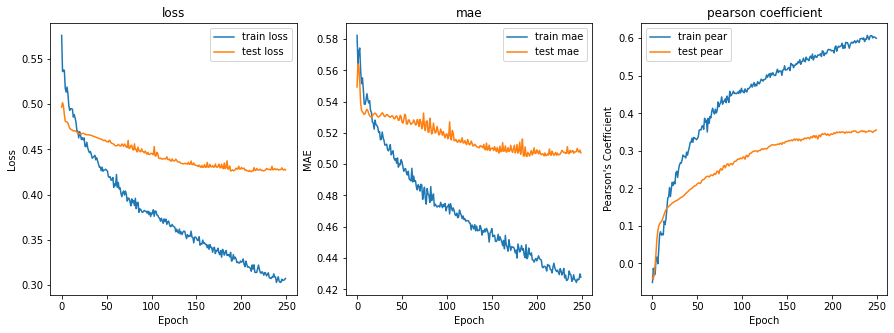

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(all_train_loss, label="train loss")
ax1.plot(all_test_loss, label="test loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.legend(loc="best")
ax1.set_title("loss")

ax2.plot(all_train_mae, label="train mae")
ax2.plot(all_test_mae, label="test mae")
ax2.set_title("mae")
ax2.set_ylabel("MAE")
ax2.set_xlabel("Epoch")
ax2.legend(loc="best")

ax3.plot(all_train_pear, label="train pear")
ax3.plot(all_test_pear, label="test pear")
ax3.set_title("pearson coefficient")
ax3.legend(loc="best")
ax3.set_ylabel("Pearson's Coefficient")
ax3.set_xlabel("Epoch")

# plt.show()

In [ ]:
# Instantiate model
model = RegressionModel(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])
model.load_state_dict(torch.load("/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch210_testloss_0.4255_testmae_0.5054000020027161_testpear_0.3505.t7"))
train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
if cuda:
    model.cuda()
loss_function = MaskedMSELoss()
train_loss, train_mae, train_pear,train_labels, train_preds, train_masks = train_or_eval_model(model, loss_function, train_loader, 1)
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, 1)


(142, 128, 1)
(86, 100, 1)


ValueError: ignored

In [ ]:
all_labels = np.concatenate([train_labels, test_label])
all_preds = np.concatenate([train_preds, test_pred])

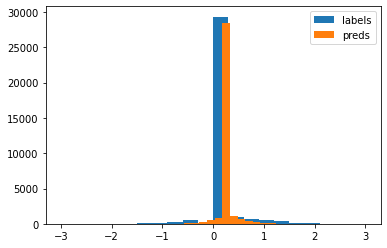

In [ ]:
import matplotlib.pyplot as plt

plt.hist(all_labels, bins=20, label="labels")
plt.hist(all_preds, bins=20, label="preds")
plt.legend()
plt.show()

In [ ]:
np.logical_and(all_labels<=0.5, all_labels >= -0.5).sum()

30799

# training result without neutral labels

In [ ]:
# Instantiate model
model = RegressionModel(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])

if cuda:
    model.cuda()
loss_function = MaskedMSELoss()

# Get optimizer and relevant dataloaders
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_no_neutral_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
best_loss, best_label, best_pred, best_mask, best_pear = None, None, None, None, None
all_train_loss, all_test_loss, all_train_mae, all_test_mae, all_train_pear, all_test_pear = [],[],[],[],[],[]

In [ ]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, loss_function, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
        torch.save(model_to_save.state_dict(), f"/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_noneutral_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.pth")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 1/200 [00:08<27:09,  8.19s/it]

Train Loss - MOSEAS Regression:  1.1415
Test Loss - MOSEAS Regression:  0.9531
Train MAE - MOSEAS Regression:  0.9689
Test MAE - MOSEAS Regression:  0.868
Train Pearson - MOSEAS Regression:  0.0059
Test Pearson - MOSEAS Regression:  -0.0474
saving checkpoint for epoch 0


MOSEAS Regression:   1%|          | 2/200 [00:16<28:00,  8.49s/it]

Train Loss - MOSEAS Regression:  1.0002
Test Loss - MOSEAS Regression:  0.8558
Train MAE - MOSEAS Regression:  0.8727
Test MAE - MOSEAS Regression:  0.774
Train Pearson - MOSEAS Regression:  -0.0196
Test Pearson - MOSEAS Regression:  -0.0188
saving checkpoint for epoch 1


MOSEAS Regression:   2%|▏         | 3/200 [00:25<28:06,  8.56s/it]

Train Loss - MOSEAS Regression:  0.9288
Test Loss - MOSEAS Regression:  0.8064
Train MAE - MOSEAS Regression:  0.8025
Test MAE - MOSEAS Regression:  0.7048
Train Pearson - MOSEAS Regression:  -0.0349
Test Pearson - MOSEAS Regression:  -0.0034
saving checkpoint for epoch 2


MOSEAS Regression:   2%|▏         | 4/200 [00:34<28:06,  8.61s/it]

Train Loss - MOSEAS Regression:  0.8773
Test Loss - MOSEAS Regression:  0.7916
Train MAE - MOSEAS Regression:  0.7422
Test MAE - MOSEAS Regression:  0.6712
Train Pearson - MOSEAS Regression:  -0.0053
Test Pearson - MOSEAS Regression:  0.0055
saving checkpoint for epoch 3


MOSEAS Regression:   2%|▎         | 5/200 [00:42<28:02,  8.63s/it]

Train Loss - MOSEAS Regression:  0.8705
Test Loss - MOSEAS Regression:  0.7972
Train MAE - MOSEAS Regression:  0.7121
Test MAE - MOSEAS Regression:  0.6526
Train Pearson - MOSEAS Regression:  -0.013
Test Pearson - MOSEAS Regression:  0.0111


MOSEAS Regression:   3%|▎         | 6/200 [00:51<27:52,  8.62s/it]

Train Loss - MOSEAS Regression:  0.8724
Test Loss - MOSEAS Regression:  0.8084
Train MAE - MOSEAS Regression:  0.6922
Test MAE - MOSEAS Regression:  0.6466
Train Pearson - MOSEAS Regression:  0.0016
Test Pearson - MOSEAS Regression:  0.0144


MOSEAS Regression:   4%|▎         | 7/200 [01:00<28:15,  8.78s/it]

Train Loss - MOSEAS Regression:  0.8818
Test Loss - MOSEAS Regression:  0.8153
Train MAE - MOSEAS Regression:  0.6922
Test MAE - MOSEAS Regression:  0.6447
Train Pearson - MOSEAS Regression:  0.0023
Test Pearson - MOSEAS Regression:  0.0162


MOSEAS Regression:   4%|▍         | 8/200 [01:09<28:28,  8.90s/it]

Train Loss - MOSEAS Regression:  0.8882
Test Loss - MOSEAS Regression:  0.8129
Train MAE - MOSEAS Regression:  0.6871
Test MAE - MOSEAS Regression:  0.6423
Train Pearson - MOSEAS Regression:  -0.0057
Test Pearson - MOSEAS Regression:  0.0168


MOSEAS Regression:   4%|▍         | 9/200 [01:18<28:37,  8.99s/it]

Train Loss - MOSEAS Regression:  0.8726
Test Loss - MOSEAS Regression:  0.8046
Train MAE - MOSEAS Regression:  0.6814
Test MAE - MOSEAS Regression:  0.6393
Train Pearson - MOSEAS Regression:  0.0208
Test Pearson - MOSEAS Regression:  0.0167


MOSEAS Regression:   5%|▌         | 10/200 [01:26<27:30,  8.69s/it]

Train Loss - MOSEAS Regression:  0.8602
Test Loss - MOSEAS Regression:  0.7933
Train MAE - MOSEAS Regression:  0.6755
Test MAE - MOSEAS Regression:  0.6377
Train Pearson - MOSEAS Regression:  0.0276
Test Pearson - MOSEAS Regression:  0.0161


MOSEAS Regression:   6%|▌         | 11/200 [01:35<27:21,  8.68s/it]

Train Loss - MOSEAS Regression:  0.8548
Test Loss - MOSEAS Regression:  0.7825
Train MAE - MOSEAS Regression:  0.6783
Test MAE - MOSEAS Regression:  0.6398
Train Pearson - MOSEAS Regression:  0.0218
Test Pearson - MOSEAS Regression:  0.0151
saving checkpoint for epoch 10


MOSEAS Regression:   6%|▌         | 12/200 [01:44<27:46,  8.86s/it]

Train Loss - MOSEAS Regression:  0.8457
Test Loss - MOSEAS Regression:  0.7745
Train MAE - MOSEAS Regression:  0.678
Test MAE - MOSEAS Regression:  0.6436
Train Pearson - MOSEAS Regression:  0.0207
Test Pearson - MOSEAS Regression:  0.0141
saving checkpoint for epoch 11


MOSEAS Regression:   6%|▋         | 13/200 [01:53<27:32,  8.84s/it]

Train Loss - MOSEAS Regression:  0.832
Test Loss - MOSEAS Regression:  0.7695
Train MAE - MOSEAS Regression:  0.6779
Test MAE - MOSEAS Regression:  0.6488
Train Pearson - MOSEAS Regression:  0.0368
Test Pearson - MOSEAS Regression:  0.013
saving checkpoint for epoch 12


MOSEAS Regression:   7%|▋         | 14/200 [02:01<26:30,  8.55s/it]

Train Loss - MOSEAS Regression:  0.8258
Test Loss - MOSEAS Regression:  0.7679
Train MAE - MOSEAS Regression:  0.6843
Test MAE - MOSEAS Regression:  0.6534
Train Pearson - MOSEAS Regression:  0.0368
Test Pearson - MOSEAS Regression:  0.0119
saving checkpoint for epoch 13


MOSEAS Regression:   8%|▊         | 15/200 [02:10<26:54,  8.73s/it]

Train Loss - MOSEAS Regression:  0.826
Test Loss - MOSEAS Regression:  0.7683
Train MAE - MOSEAS Regression:  0.6915
Test MAE - MOSEAS Regression:  0.6575
Train Pearson - MOSEAS Regression:  0.0411
Test Pearson - MOSEAS Regression:  0.0112


MOSEAS Regression:   8%|▊         | 16/200 [02:19<27:10,  8.86s/it]

Train Loss - MOSEAS Regression:  0.8184
Test Loss - MOSEAS Regression:  0.7691
Train MAE - MOSEAS Regression:  0.6949
Test MAE - MOSEAS Regression:  0.661
Train Pearson - MOSEAS Regression:  0.0603
Test Pearson - MOSEAS Regression:  0.0109


MOSEAS Regression:   8%|▊         | 17/200 [02:28<27:15,  8.94s/it]

Train Loss - MOSEAS Regression:  0.8065
Test Loss - MOSEAS Regression:  0.7691
Train MAE - MOSEAS Regression:  0.6967
Test MAE - MOSEAS Regression:  0.6629
Train Pearson - MOSEAS Regression:  0.0999
Test Pearson - MOSEAS Regression:  0.0112


MOSEAS Regression:   9%|▉         | 18/200 [02:36<26:14,  8.65s/it]

Train Loss - MOSEAS Regression:  0.813
Test Loss - MOSEAS Regression:  0.7683
Train MAE - MOSEAS Regression:  0.7009
Test MAE - MOSEAS Regression:  0.6629
Train Pearson - MOSEAS Regression:  0.0842
Test Pearson - MOSEAS Regression:  0.012


MOSEAS Regression:  10%|▉         | 19/200 [02:46<26:35,  8.82s/it]

Train Loss - MOSEAS Regression:  0.8013
Test Loss - MOSEAS Regression:  0.7663
Train MAE - MOSEAS Regression:  0.6963
Test MAE - MOSEAS Regression:  0.6603
Train Pearson - MOSEAS Regression:  0.1143
Test Pearson - MOSEAS Regression:  0.0134
saving checkpoint for epoch 18


MOSEAS Regression:  10%|█         | 20/200 [02:54<26:08,  8.71s/it]

Train Loss - MOSEAS Regression:  0.8128
Test Loss - MOSEAS Regression:  0.7631
Train MAE - MOSEAS Regression:  0.6962
Test MAE - MOSEAS Regression:  0.6549
Train Pearson - MOSEAS Regression:  0.0741
Test Pearson - MOSEAS Regression:  0.0155
saving checkpoint for epoch 19


MOSEAS Regression:  10%|█         | 21/200 [03:03<26:32,  8.90s/it]

Train Loss - MOSEAS Regression:  0.7953
Test Loss - MOSEAS Regression:  0.7599
Train MAE - MOSEAS Regression:  0.6842
Test MAE - MOSEAS Regression:  0.6485
Train Pearson - MOSEAS Regression:  0.1154
Test Pearson - MOSEAS Regression:  0.0178
saving checkpoint for epoch 20


MOSEAS Regression:  11%|█         | 22/200 [03:12<26:09,  8.82s/it]

Train Loss - MOSEAS Regression:  0.8091
Test Loss - MOSEAS Regression:  0.7575
Train MAE - MOSEAS Regression:  0.6861
Test MAE - MOSEAS Regression:  0.6436
Train Pearson - MOSEAS Regression:  0.066
Test Pearson - MOSEAS Regression:  0.02
saving checkpoint for epoch 21


MOSEAS Regression:  12%|█▏        | 23/200 [03:21<25:54,  8.78s/it]

Train Loss - MOSEAS Regression:  0.7913
Test Loss - MOSEAS Regression:  0.7556
Train MAE - MOSEAS Regression:  0.6701
Test MAE - MOSEAS Regression:  0.6394
Train Pearson - MOSEAS Regression:  0.1159
Test Pearson - MOSEAS Regression:  0.0224
saving checkpoint for epoch 22


MOSEAS Regression:  12%|█▏        | 24/200 [03:29<25:30,  8.70s/it]

Train Loss - MOSEAS Regression:  0.7873
Test Loss - MOSEAS Regression:  0.7542
Train MAE - MOSEAS Regression:  0.6666
Test MAE - MOSEAS Regression:  0.6363
Train Pearson - MOSEAS Regression:  0.121
Test Pearson - MOSEAS Regression:  0.0248
saving checkpoint for epoch 23


MOSEAS Regression:  12%|█▎        | 25/200 [03:37<24:50,  8.52s/it]

Train Loss - MOSEAS Regression:  0.7864
Test Loss - MOSEAS Regression:  0.7533
Train MAE - MOSEAS Regression:  0.6618
Test MAE - MOSEAS Regression:  0.6346
Train Pearson - MOSEAS Regression:  0.1246
Test Pearson - MOSEAS Regression:  0.0267
saving checkpoint for epoch 24


MOSEAS Regression:  13%|█▎        | 26/200 [03:45<24:02,  8.29s/it]

Train Loss - MOSEAS Regression:  0.7755
Test Loss - MOSEAS Regression:  0.7524
Train MAE - MOSEAS Regression:  0.6561
Test MAE - MOSEAS Regression:  0.6331
Train Pearson - MOSEAS Regression:  0.1533
Test Pearson - MOSEAS Regression:  0.0287
saving checkpoint for epoch 25


MOSEAS Regression:  14%|█▎        | 27/200 [03:58<27:46,  9.64s/it]

Train Loss - MOSEAS Regression:  0.7724
Test Loss - MOSEAS Regression:  0.7515
Train MAE - MOSEAS Regression:  0.6525
Test MAE - MOSEAS Regression:  0.6325
Train Pearson - MOSEAS Regression:  0.1593
Test Pearson - MOSEAS Regression:  0.0308
saving checkpoint for epoch 26


MOSEAS Regression:  14%|█▍        | 28/200 [04:07<27:26,  9.57s/it]

Train Loss - MOSEAS Regression:  0.7841
Test Loss - MOSEAS Regression:  0.7507
Train MAE - MOSEAS Regression:  0.6556
Test MAE - MOSEAS Regression:  0.6331
Train Pearson - MOSEAS Regression:  0.1269
Test Pearson - MOSEAS Regression:  0.0328
saving checkpoint for epoch 27


MOSEAS Regression:  14%|█▍        | 29/200 [04:16<26:13,  9.20s/it]

Train Loss - MOSEAS Regression:  0.7828
Test Loss - MOSEAS Regression:  0.7501
Train MAE - MOSEAS Regression:  0.6566
Test MAE - MOSEAS Regression:  0.6348
Train Pearson - MOSEAS Regression:  0.1282
Test Pearson - MOSEAS Regression:  0.0347
saving checkpoint for epoch 28


MOSEAS Regression:  15%|█▌        | 30/200 [04:24<25:34,  9.03s/it]

Train Loss - MOSEAS Regression:  0.7761
Test Loss - MOSEAS Regression:  0.75
Train MAE - MOSEAS Regression:  0.6566
Test MAE - MOSEAS Regression:  0.6369
Train Pearson - MOSEAS Regression:  0.1509
Test Pearson - MOSEAS Regression:  0.0362
saving checkpoint for epoch 29


MOSEAS Regression:  16%|█▌        | 31/200 [04:33<25:14,  8.96s/it]

Train Loss - MOSEAS Regression:  0.7749
Test Loss - MOSEAS Regression:  0.7503
Train MAE - MOSEAS Regression:  0.6625
Test MAE - MOSEAS Regression:  0.6401
Train Pearson - MOSEAS Regression:  0.155
Test Pearson - MOSEAS Regression:  0.0376


MOSEAS Regression:  16%|█▌        | 32/200 [04:42<24:47,  8.85s/it]

Train Loss - MOSEAS Regression:  0.7669
Test Loss - MOSEAS Regression:  0.7501
Train MAE - MOSEAS Regression:  0.6583
Test MAE - MOSEAS Regression:  0.6413
Train Pearson - MOSEAS Regression:  0.181
Test Pearson - MOSEAS Regression:  0.0398


MOSEAS Regression:  16%|█▋        | 33/200 [04:51<25:03,  9.00s/it]

Train Loss - MOSEAS Regression:  0.7536
Test Loss - MOSEAS Regression:  0.7495
Train MAE - MOSEAS Regression:  0.6521
Test MAE - MOSEAS Regression:  0.6411
Train Pearson - MOSEAS Regression:  0.2172
Test Pearson - MOSEAS Regression:  0.0429
saving checkpoint for epoch 32


MOSEAS Regression:  17%|█▋        | 34/200 [04:59<24:07,  8.72s/it]

Train Loss - MOSEAS Regression:  0.7522
Test Loss - MOSEAS Regression:  0.749
Train MAE - MOSEAS Regression:  0.654
Test MAE - MOSEAS Regression:  0.6412
Train Pearson - MOSEAS Regression:  0.2216
Test Pearson - MOSEAS Regression:  0.0458
saving checkpoint for epoch 33


MOSEAS Regression:  18%|█▊        | 35/200 [05:08<23:59,  8.72s/it]

Train Loss - MOSEAS Regression:  0.7487
Test Loss - MOSEAS Regression:  0.7482
Train MAE - MOSEAS Regression:  0.651
Test MAE - MOSEAS Regression:  0.6402
Train Pearson - MOSEAS Regression:  0.2308
Test Pearson - MOSEAS Regression:  0.0492
saving checkpoint for epoch 34


MOSEAS Regression:  18%|█▊        | 36/200 [05:16<23:46,  8.70s/it]

Train Loss - MOSEAS Regression:  0.7506
Test Loss - MOSEAS Regression:  0.7474
Train MAE - MOSEAS Regression:  0.6516
Test MAE - MOSEAS Regression:  0.6393
Train Pearson - MOSEAS Regression:  0.2262
Test Pearson - MOSEAS Regression:  0.0524
saving checkpoint for epoch 35


MOSEAS Regression:  18%|█▊        | 37/200 [05:26<24:09,  8.89s/it]

Train Loss - MOSEAS Regression:  0.7428
Test Loss - MOSEAS Regression:  0.7464
Train MAE - MOSEAS Regression:  0.6478
Test MAE - MOSEAS Regression:  0.6374
Train Pearson - MOSEAS Regression:  0.2438
Test Pearson - MOSEAS Regression:  0.0558
saving checkpoint for epoch 36


MOSEAS Regression:  19%|█▉        | 38/200 [05:35<23:52,  8.84s/it]

Train Loss - MOSEAS Regression:  0.7407
Test Loss - MOSEAS Regression:  0.7464
Train MAE - MOSEAS Regression:  0.6426
Test MAE - MOSEAS Regression:  0.6381
Train Pearson - MOSEAS Regression:  0.2479
Test Pearson - MOSEAS Regression:  0.0578


MOSEAS Regression:  20%|█▉        | 39/200 [05:44<24:03,  8.97s/it]

Train Loss - MOSEAS Regression:  0.7405
Test Loss - MOSEAS Regression:  0.7459
Train MAE - MOSEAS Regression:  0.6402
Test MAE - MOSEAS Regression:  0.6375
Train Pearson - MOSEAS Regression:  0.2479
Test Pearson - MOSEAS Regression:  0.0601
saving checkpoint for epoch 38


MOSEAS Regression:  20%|██        | 40/200 [05:52<23:37,  8.86s/it]

Train Loss - MOSEAS Regression:  0.7446
Test Loss - MOSEAS Regression:  0.7459
Train MAE - MOSEAS Regression:  0.6431
Test MAE - MOSEAS Regression:  0.638
Train Pearson - MOSEAS Regression:  0.2383
Test Pearson - MOSEAS Regression:  0.0619


MOSEAS Regression:  20%|██        | 41/200 [06:01<23:09,  8.74s/it]

Train Loss - MOSEAS Regression:  0.7327
Test Loss - MOSEAS Regression:  0.7459
Train MAE - MOSEAS Regression:  0.6356
Test MAE - MOSEAS Regression:  0.6383
Train Pearson - MOSEAS Regression:  0.2681
Test Pearson - MOSEAS Regression:  0.0636


MOSEAS Regression:  21%|██        | 42/200 [06:10<23:02,  8.75s/it]

Train Loss - MOSEAS Regression:  0.7245
Test Loss - MOSEAS Regression:  0.7457
Train MAE - MOSEAS Regression:  0.6304
Test MAE - MOSEAS Regression:  0.6377
Train Pearson - MOSEAS Regression:  0.288
Test Pearson - MOSEAS Regression:  0.0657
saving checkpoint for epoch 41


MOSEAS Regression:  22%|██▏       | 43/200 [06:18<22:51,  8.74s/it]

Train Loss - MOSEAS Regression:  0.7255
Test Loss - MOSEAS Regression:  0.7457
Train MAE - MOSEAS Regression:  0.6343
Test MAE - MOSEAS Regression:  0.6377
Train Pearson - MOSEAS Regression:  0.2852
Test Pearson - MOSEAS Regression:  0.0674


MOSEAS Regression:  22%|██▏       | 44/200 [06:27<22:37,  8.70s/it]

Train Loss - MOSEAS Regression:  0.7227
Test Loss - MOSEAS Regression:  0.7457
Train MAE - MOSEAS Regression:  0.6293
Test MAE - MOSEAS Regression:  0.6375
Train Pearson - MOSEAS Regression:  0.29
Test Pearson - MOSEAS Regression:  0.0694


MOSEAS Regression:  22%|██▎       | 45/200 [06:36<22:35,  8.74s/it]

Train Loss - MOSEAS Regression:  0.7115
Test Loss - MOSEAS Regression:  0.7456
Train MAE - MOSEAS Regression:  0.6268
Test MAE - MOSEAS Regression:  0.6369
Train Pearson - MOSEAS Regression:  0.3153
Test Pearson - MOSEAS Regression:  0.0714
saving checkpoint for epoch 44


MOSEAS Regression:  23%|██▎       | 46/200 [06:45<22:38,  8.82s/it]

Train Loss - MOSEAS Regression:  0.7304
Test Loss - MOSEAS Regression:  0.7463
Train MAE - MOSEAS Regression:  0.6355
Test MAE - MOSEAS Regression:  0.6391
Train Pearson - MOSEAS Regression:  0.2711
Test Pearson - MOSEAS Regression:  0.0722


MOSEAS Regression:  24%|██▎       | 47/200 [06:53<21:44,  8.53s/it]

Train Loss - MOSEAS Regression:  0.7138
Test Loss - MOSEAS Regression:  0.747
Train MAE - MOSEAS Regression:  0.6297
Test MAE - MOSEAS Regression:  0.6412
Train Pearson - MOSEAS Regression:  0.3094
Test Pearson - MOSEAS Regression:  0.0736


MOSEAS Regression:  24%|██▍       | 48/200 [07:00<20:58,  8.28s/it]

Train Loss - MOSEAS Regression:  0.7198
Test Loss - MOSEAS Regression:  0.7472
Train MAE - MOSEAS Regression:  0.6291
Test MAE - MOSEAS Regression:  0.6416
Train Pearson - MOSEAS Regression:  0.2967
Test Pearson - MOSEAS Regression:  0.0756


MOSEAS Regression:  24%|██▍       | 49/200 [07:08<20:23,  8.10s/it]

Train Loss - MOSEAS Regression:  0.718
Test Loss - MOSEAS Regression:  0.7478
Train MAE - MOSEAS Regression:  0.6302
Test MAE - MOSEAS Regression:  0.6433
Train Pearson - MOSEAS Regression:  0.3
Test Pearson - MOSEAS Regression:  0.0777


MOSEAS Regression:  25%|██▌       | 50/200 [07:17<20:58,  8.39s/it]

Train Loss - MOSEAS Regression:  0.7053
Test Loss - MOSEAS Regression:  0.7479
Train MAE - MOSEAS Regression:  0.6257
Test MAE - MOSEAS Regression:  0.6439
Train Pearson - MOSEAS Regression:  0.3282
Test Pearson - MOSEAS Regression:  0.0806


MOSEAS Regression:  26%|██▌       | 51/200 [07:26<21:21,  8.60s/it]

Train Loss - MOSEAS Regression:  0.699
Test Loss - MOSEAS Regression:  0.7473
Train MAE - MOSEAS Regression:  0.6206
Test MAE - MOSEAS Regression:  0.6431
Train Pearson - MOSEAS Regression:  0.3411
Test Pearson - MOSEAS Regression:  0.0843


MOSEAS Regression:  26%|██▌       | 52/200 [07:34<20:33,  8.33s/it]

Train Loss - MOSEAS Regression:  0.7001
Test Loss - MOSEAS Regression:  0.7466
Train MAE - MOSEAS Regression:  0.6232
Test MAE - MOSEAS Regression:  0.6421
Train Pearson - MOSEAS Regression:  0.3378
Test Pearson - MOSEAS Regression:  0.0885


MOSEAS Regression:  26%|██▋       | 53/200 [07:43<20:52,  8.52s/it]

Train Loss - MOSEAS Regression:  0.7017
Test Loss - MOSEAS Regression:  0.7461
Train MAE - MOSEAS Regression:  0.6167
Test MAE - MOSEAS Regression:  0.6417
Train Pearson - MOSEAS Regression:  0.3327
Test Pearson - MOSEAS Regression:  0.0923


MOSEAS Regression:  27%|██▋       | 54/200 [07:51<20:36,  8.47s/it]

Train Loss - MOSEAS Regression:  0.7033
Test Loss - MOSEAS Regression:  0.7468
Train MAE - MOSEAS Regression:  0.6207
Test MAE - MOSEAS Regression:  0.6442
Train Pearson - MOSEAS Regression:  0.3302
Test Pearson - MOSEAS Regression:  0.0949


MOSEAS Regression:  28%|██▊       | 55/200 [08:00<20:29,  8.48s/it]

Train Loss - MOSEAS Regression:  0.6788
Test Loss - MOSEAS Regression:  0.7463
Train MAE - MOSEAS Regression:  0.6162
Test MAE - MOSEAS Regression:  0.6438
Train Pearson - MOSEAS Regression:  0.3771
Test Pearson - MOSEAS Regression:  0.0988


MOSEAS Regression:  28%|██▊       | 56/200 [08:08<20:29,  8.54s/it]

Train Loss - MOSEAS Regression:  0.698
Test Loss - MOSEAS Regression:  0.7455
Train MAE - MOSEAS Regression:  0.622
Test MAE - MOSEAS Regression:  0.6426
Train Pearson - MOSEAS Regression:  0.3397
Test Pearson - MOSEAS Regression:  0.1029
saving checkpoint for epoch 55


MOSEAS Regression:  28%|██▊       | 57/200 [08:16<19:47,  8.30s/it]

Train Loss - MOSEAS Regression:  0.6888
Test Loss - MOSEAS Regression:  0.7447
Train MAE - MOSEAS Regression:  0.6139
Test MAE - MOSEAS Regression:  0.6416
Train Pearson - MOSEAS Regression:  0.3567
Test Pearson - MOSEAS Regression:  0.1069
saving checkpoint for epoch 56


MOSEAS Regression:  29%|██▉       | 58/200 [08:25<20:00,  8.45s/it]

Train Loss - MOSEAS Regression:  0.6825
Test Loss - MOSEAS Regression:  0.7441
Train MAE - MOSEAS Regression:  0.6137
Test MAE - MOSEAS Regression:  0.6404
Train Pearson - MOSEAS Regression:  0.3679
Test Pearson - MOSEAS Regression:  0.1105
saving checkpoint for epoch 57


MOSEAS Regression:  30%|██▉       | 59/200 [08:34<20:01,  8.52s/it]

Train Loss - MOSEAS Regression:  0.6823
Test Loss - MOSEAS Regression:  0.7437
Train MAE - MOSEAS Regression:  0.6157
Test MAE - MOSEAS Regression:  0.6398
Train Pearson - MOSEAS Regression:  0.3675
Test Pearson - MOSEAS Regression:  0.1134
saving checkpoint for epoch 58


MOSEAS Regression:  30%|███       | 60/200 [08:42<20:02,  8.59s/it]

Train Loss - MOSEAS Regression:  0.6708
Test Loss - MOSEAS Regression:  0.7443
Train MAE - MOSEAS Regression:  0.6059
Test MAE - MOSEAS Regression:  0.6418
Train Pearson - MOSEAS Regression:  0.3888
Test Pearson - MOSEAS Regression:  0.1152


MOSEAS Regression:  30%|███       | 61/200 [08:50<19:14,  8.31s/it]

Train Loss - MOSEAS Regression:  0.674
Test Loss - MOSEAS Regression:  0.7457
Train MAE - MOSEAS Regression:  0.6102
Test MAE - MOSEAS Regression:  0.6456
Train Pearson - MOSEAS Regression:  0.3824
Test Pearson - MOSEAS Regression:  0.1162


MOSEAS Regression:  31%|███       | 62/200 [08:58<18:48,  8.18s/it]

Train Loss - MOSEAS Regression:  0.6805
Test Loss - MOSEAS Regression:  0.7469
Train MAE - MOSEAS Regression:  0.6149
Test MAE - MOSEAS Regression:  0.6483
Train Pearson - MOSEAS Regression:  0.3711
Test Pearson - MOSEAS Regression:  0.1176


MOSEAS Regression:  32%|███▏      | 63/200 [09:07<19:22,  8.48s/it]

Train Loss - MOSEAS Regression:  0.6631
Test Loss - MOSEAS Regression:  0.7464
Train MAE - MOSEAS Regression:  0.6088
Test MAE - MOSEAS Regression:  0.6481
Train Pearson - MOSEAS Regression:  0.4016
Test Pearson - MOSEAS Regression:  0.1203


MOSEAS Regression:  32%|███▏      | 64/200 [09:16<19:15,  8.49s/it]

Train Loss - MOSEAS Regression:  0.6818
Test Loss - MOSEAS Regression:  0.7443
Train MAE - MOSEAS Regression:  0.6192
Test MAE - MOSEAS Regression:  0.6447
Train Pearson - MOSEAS Regression:  0.3679
Test Pearson - MOSEAS Regression:  0.1244


MOSEAS Regression:  32%|███▎      | 65/200 [09:25<19:35,  8.71s/it]

Train Loss - MOSEAS Regression:  0.6632
Test Loss - MOSEAS Regression:  0.7441
Train MAE - MOSEAS Regression:  0.6049
Test MAE - MOSEAS Regression:  0.6446
Train Pearson - MOSEAS Regression:  0.3994
Test Pearson - MOSEAS Regression:  0.1266


MOSEAS Regression:  33%|███▎      | 66/200 [09:33<18:52,  8.45s/it]

Train Loss - MOSEAS Regression:  0.655
Test Loss - MOSEAS Regression:  0.7432
Train MAE - MOSEAS Regression:  0.6028
Test MAE - MOSEAS Regression:  0.6432
Train Pearson - MOSEAS Regression:  0.4147
Test Pearson - MOSEAS Regression:  0.1292
saving checkpoint for epoch 65


MOSEAS Regression:  34%|███▎      | 67/200 [09:41<18:48,  8.49s/it]

Train Loss - MOSEAS Regression:  0.655
Test Loss - MOSEAS Regression:  0.7445
Train MAE - MOSEAS Regression:  0.5994
Test MAE - MOSEAS Regression:  0.6466
Train Pearson - MOSEAS Regression:  0.4146
Test Pearson - MOSEAS Regression:  0.1296


MOSEAS Regression:  34%|███▍      | 68/200 [09:50<18:45,  8.53s/it]

Train Loss - MOSEAS Regression:  0.6578
Test Loss - MOSEAS Regression:  0.7466
Train MAE - MOSEAS Regression:  0.6029
Test MAE - MOSEAS Regression:  0.6507
Train Pearson - MOSEAS Regression:  0.4094
Test Pearson - MOSEAS Regression:  0.1294


MOSEAS Regression:  34%|███▍      | 69/200 [09:59<18:42,  8.57s/it]

Train Loss - MOSEAS Regression:  0.654
Test Loss - MOSEAS Regression:  0.7461
Train MAE - MOSEAS Regression:  0.6063
Test MAE - MOSEAS Regression:  0.6502
Train Pearson - MOSEAS Regression:  0.4156
Test Pearson - MOSEAS Regression:  0.1315


MOSEAS Regression:  35%|███▌      | 70/200 [10:08<18:54,  8.73s/it]

Train Loss - MOSEAS Regression:  0.6467
Test Loss - MOSEAS Regression:  0.7437
Train MAE - MOSEAS Regression:  0.5969
Test MAE - MOSEAS Regression:  0.6466
Train Pearson - MOSEAS Regression:  0.4267
Test Pearson - MOSEAS Regression:  0.1351


MOSEAS Regression:  36%|███▌      | 71/200 [10:17<19:00,  8.84s/it]

Train Loss - MOSEAS Regression:  0.652
Test Loss - MOSEAS Regression:  0.7432
Train MAE - MOSEAS Regression:  0.6021
Test MAE - MOSEAS Regression:  0.646
Train Pearson - MOSEAS Regression:  0.4166
Test Pearson - MOSEAS Regression:  0.1373


MOSEAS Regression:  36%|███▌      | 72/200 [10:26<18:47,  8.81s/it]

Train Loss - MOSEAS Regression:  0.6451
Test Loss - MOSEAS Regression:  0.7416
Train MAE - MOSEAS Regression:  0.5973
Test MAE - MOSEAS Regression:  0.6436
Train Pearson - MOSEAS Regression:  0.4289
Test Pearson - MOSEAS Regression:  0.1411
saving checkpoint for epoch 71


MOSEAS Regression:  36%|███▋      | 73/200 [10:35<18:53,  8.93s/it]

Train Loss - MOSEAS Regression:  0.6393
Test Loss - MOSEAS Regression:  0.7419
Train MAE - MOSEAS Regression:  0.5911
Test MAE - MOSEAS Regression:  0.6453
Train Pearson - MOSEAS Regression:  0.437
Test Pearson - MOSEAS Regression:  0.1426


MOSEAS Regression:  37%|███▋      | 74/200 [10:44<18:52,  8.99s/it]

Train Loss - MOSEAS Regression:  0.6426
Test Loss - MOSEAS Regression:  0.7433
Train MAE - MOSEAS Regression:  0.5952
Test MAE - MOSEAS Regression:  0.6491
Train Pearson - MOSEAS Regression:  0.4319
Test Pearson - MOSEAS Regression:  0.1433


MOSEAS Regression:  38%|███▊      | 75/200 [10:53<18:38,  8.95s/it]

Train Loss - MOSEAS Regression:  0.6392
Test Loss - MOSEAS Regression:  0.7437
Train MAE - MOSEAS Regression:  0.5918
Test MAE - MOSEAS Regression:  0.651
Train Pearson - MOSEAS Regression:  0.4357
Test Pearson - MOSEAS Regression:  0.1454


MOSEAS Regression:  38%|███▊      | 76/200 [11:01<17:58,  8.70s/it]

Train Loss - MOSEAS Regression:  0.6335
Test Loss - MOSEAS Regression:  0.7401
Train MAE - MOSEAS Regression:  0.5992
Test MAE - MOSEAS Regression:  0.6462
Train Pearson - MOSEAS Regression:  0.4453
Test Pearson - MOSEAS Regression:  0.1509
saving checkpoint for epoch 75


MOSEAS Regression:  38%|███▊      | 77/200 [11:10<17:51,  8.71s/it]

Train Loss - MOSEAS Regression:  0.6532
Test Loss - MOSEAS Regression:  0.7395
Train MAE - MOSEAS Regression:  0.5986
Test MAE - MOSEAS Regression:  0.6469
Train Pearson - MOSEAS Regression:  0.4139
Test Pearson - MOSEAS Regression:  0.1536
saving checkpoint for epoch 76


MOSEAS Regression:  39%|███▉      | 78/200 [11:19<18:10,  8.94s/it]

Train Loss - MOSEAS Regression:  0.6274
Test Loss - MOSEAS Regression:  0.738
Train MAE - MOSEAS Regression:  0.5884
Test MAE - MOSEAS Regression:  0.6454
Train Pearson - MOSEAS Regression:  0.4538
Test Pearson - MOSEAS Regression:  0.1573
saving checkpoint for epoch 77


MOSEAS Regression:  40%|███▉      | 79/200 [11:28<17:57,  8.90s/it]

Train Loss - MOSEAS Regression:  0.6303
Test Loss - MOSEAS Regression:  0.7375
Train MAE - MOSEAS Regression:  0.5905
Test MAE - MOSEAS Regression:  0.6456
Train Pearson - MOSEAS Regression:  0.448
Test Pearson - MOSEAS Regression:  0.1602
saving checkpoint for epoch 78


MOSEAS Regression:  40%|████      | 80/200 [11:37<17:47,  8.90s/it]

Train Loss - MOSEAS Regression:  0.6236
Test Loss - MOSEAS Regression:  0.737
Train MAE - MOSEAS Regression:  0.5839
Test MAE - MOSEAS Regression:  0.6452
Train Pearson - MOSEAS Regression:  0.4605
Test Pearson - MOSEAS Regression:  0.1627
saving checkpoint for epoch 79


MOSEAS Regression:  40%|████      | 81/200 [11:45<17:11,  8.67s/it]

Train Loss - MOSEAS Regression:  0.6204
Test Loss - MOSEAS Regression:  0.7361
Train MAE - MOSEAS Regression:  0.5868
Test MAE - MOSEAS Regression:  0.6444
Train Pearson - MOSEAS Regression:  0.4638
Test Pearson - MOSEAS Regression:  0.1657
saving checkpoint for epoch 80


MOSEAS Regression:  41%|████      | 82/200 [11:53<16:52,  8.58s/it]

Train Loss - MOSEAS Regression:  0.6182
Test Loss - MOSEAS Regression:  0.7358
Train MAE - MOSEAS Regression:  0.5904
Test MAE - MOSEAS Regression:  0.6446
Train Pearson - MOSEAS Regression:  0.466
Test Pearson - MOSEAS Regression:  0.1679
saving checkpoint for epoch 81


MOSEAS Regression:  42%|████▏     | 83/200 [12:02<16:47,  8.61s/it]

Train Loss - MOSEAS Regression:  0.62
Test Loss - MOSEAS Regression:  0.7368
Train MAE - MOSEAS Regression:  0.5835
Test MAE - MOSEAS Regression:  0.6471
Train Pearson - MOSEAS Regression:  0.4631
Test Pearson - MOSEAS Regression:  0.1688


MOSEAS Regression:  42%|████▏     | 84/200 [12:10<16:37,  8.60s/it]

Train Loss - MOSEAS Regression:  0.6203
Test Loss - MOSEAS Regression:  0.7389
Train MAE - MOSEAS Regression:  0.5845
Test MAE - MOSEAS Regression:  0.6511
Train Pearson - MOSEAS Regression:  0.4622
Test Pearson - MOSEAS Regression:  0.1686


MOSEAS Regression:  42%|████▎     | 85/200 [12:19<16:35,  8.66s/it]

Train Loss - MOSEAS Regression:  0.6033
Test Loss - MOSEAS Regression:  0.7401
Train MAE - MOSEAS Regression:  0.5796
Test MAE - MOSEAS Regression:  0.6531
Train Pearson - MOSEAS Regression:  0.4868
Test Pearson - MOSEAS Regression:  0.1697


MOSEAS Regression:  43%|████▎     | 86/200 [12:28<16:30,  8.69s/it]

Train Loss - MOSEAS Regression:  0.6032
Test Loss - MOSEAS Regression:  0.7373
Train MAE - MOSEAS Regression:  0.5838
Test MAE - MOSEAS Regression:  0.6484
Train Pearson - MOSEAS Regression:  0.4881
Test Pearson - MOSEAS Regression:  0.1742


MOSEAS Regression:  44%|████▎     | 87/200 [12:37<16:24,  8.72s/it]

Train Loss - MOSEAS Regression:  0.5949
Test Loss - MOSEAS Regression:  0.7362
Train MAE - MOSEAS Regression:  0.5773
Test MAE - MOSEAS Regression:  0.6459
Train Pearson - MOSEAS Regression:  0.4972
Test Pearson - MOSEAS Regression:  0.1769


MOSEAS Regression:  44%|████▍     | 88/200 [12:45<15:51,  8.50s/it]

Train Loss - MOSEAS Regression:  0.6058
Test Loss - MOSEAS Regression:  0.735
Train MAE - MOSEAS Regression:  0.5763
Test MAE - MOSEAS Regression:  0.6419
Train Pearson - MOSEAS Regression:  0.4826
Test Pearson - MOSEAS Regression:  0.1796
saving checkpoint for epoch 87


MOSEAS Regression:  44%|████▍     | 89/200 [12:54<15:56,  8.62s/it]

Train Loss - MOSEAS Regression:  0.599
Test Loss - MOSEAS Regression:  0.7364
Train MAE - MOSEAS Regression:  0.5694
Test MAE - MOSEAS Regression:  0.6447
Train Pearson - MOSEAS Regression:  0.4916
Test Pearson - MOSEAS Regression:  0.1792


MOSEAS Regression:  45%|████▌     | 90/200 [13:03<15:56,  8.69s/it]

Train Loss - MOSEAS Regression:  0.6029
Test Loss - MOSEAS Regression:  0.7391
Train MAE - MOSEAS Regression:  0.5782
Test MAE - MOSEAS Regression:  0.6501
Train Pearson - MOSEAS Regression:  0.4851
Test Pearson - MOSEAS Regression:  0.1781


MOSEAS Regression:  46%|████▌     | 91/200 [13:11<15:43,  8.65s/it]

Train Loss - MOSEAS Regression:  0.6008
Test Loss - MOSEAS Regression:  0.74
Train MAE - MOSEAS Regression:  0.5838
Test MAE - MOSEAS Regression:  0.6524
Train Pearson - MOSEAS Regression:  0.4892
Test Pearson - MOSEAS Regression:  0.1796


MOSEAS Regression:  46%|████▌     | 92/200 [13:20<15:44,  8.74s/it]

Train Loss - MOSEAS Regression:  0.5928
Test Loss - MOSEAS Regression:  0.7341
Train MAE - MOSEAS Regression:  0.5758
Test MAE - MOSEAS Regression:  0.6433
Train Pearson - MOSEAS Regression:  0.5
Test Pearson - MOSEAS Regression:  0.1875
saving checkpoint for epoch 91


MOSEAS Regression:  46%|████▋     | 93/200 [13:29<15:32,  8.72s/it]

Train Loss - MOSEAS Regression:  0.5946
Test Loss - MOSEAS Regression:  0.7315
Train MAE - MOSEAS Regression:  0.5753
Test MAE - MOSEAS Regression:  0.6349
Train Pearson - MOSEAS Regression:  0.497
Test Pearson - MOSEAS Regression:  0.1942
saving checkpoint for epoch 92


MOSEAS Regression:  47%|████▋     | 94/200 [13:37<15:22,  8.70s/it]

Train Loss - MOSEAS Regression:  0.5807
Test Loss - MOSEAS Regression:  0.7321
Train MAE - MOSEAS Regression:  0.5665
Test MAE - MOSEAS Regression:  0.6421
Train Pearson - MOSEAS Regression:  0.5158
Test Pearson - MOSEAS Regression:  0.1938


MOSEAS Regression:  48%|████▊     | 95/200 [13:47<15:34,  8.90s/it]

Train Loss - MOSEAS Regression:  0.5827
Test Loss - MOSEAS Regression:  0.7385
Train MAE - MOSEAS Regression:  0.5661
Test MAE - MOSEAS Regression:  0.6546
Train Pearson - MOSEAS Regression:  0.5116
Test Pearson - MOSEAS Regression:  0.1895


MOSEAS Regression:  48%|████▊     | 96/200 [13:56<15:21,  8.86s/it]

Train Loss - MOSEAS Regression:  0.5808
Test Loss - MOSEAS Regression:  0.7366
Train MAE - MOSEAS Regression:  0.5717
Test MAE - MOSEAS Regression:  0.6518
Train Pearson - MOSEAS Regression:  0.515
Test Pearson - MOSEAS Regression:  0.1926


MOSEAS Regression:  48%|████▊     | 97/200 [14:04<15:04,  8.78s/it]

Train Loss - MOSEAS Regression:  0.5803
Test Loss - MOSEAS Regression:  0.7347
Train MAE - MOSEAS Regression:  0.5689
Test MAE - MOSEAS Regression:  0.6478
Train Pearson - MOSEAS Regression:  0.5162
Test Pearson - MOSEAS Regression:  0.1955


MOSEAS Regression:  49%|████▉     | 98/200 [14:13<14:55,  8.77s/it]

Train Loss - MOSEAS Regression:  0.5744
Test Loss - MOSEAS Regression:  0.7335
Train MAE - MOSEAS Regression:  0.5678
Test MAE - MOSEAS Regression:  0.6438
Train Pearson - MOSEAS Regression:  0.5225
Test Pearson - MOSEAS Regression:  0.1978


MOSEAS Regression:  50%|████▉     | 99/200 [14:22<15:03,  8.94s/it]

Train Loss - MOSEAS Regression:  0.5738
Test Loss - MOSEAS Regression:  0.736
Train MAE - MOSEAS Regression:  0.5676
Test MAE - MOSEAS Regression:  0.6479
Train Pearson - MOSEAS Regression:  0.5233
Test Pearson - MOSEAS Regression:  0.1962


MOSEAS Regression:  50%|█████     | 100/200 [14:31<14:42,  8.83s/it]

Train Loss - MOSEAS Regression:  0.5745
Test Loss - MOSEAS Regression:  0.742
Train MAE - MOSEAS Regression:  0.5653
Test MAE - MOSEAS Regression:  0.6555
Train Pearson - MOSEAS Regression:  0.5222
Test Pearson - MOSEAS Regression:  0.192


MOSEAS Regression:  50%|█████     | 101/200 [14:39<14:28,  8.77s/it]

Train Loss - MOSEAS Regression:  0.5835
Test Loss - MOSEAS Regression:  0.7364
Train MAE - MOSEAS Regression:  0.5757
Test MAE - MOSEAS Regression:  0.6434
Train Pearson - MOSEAS Regression:  0.5124
Test Pearson - MOSEAS Regression:  0.1973


MOSEAS Regression:  51%|█████     | 102/200 [14:49<14:37,  8.96s/it]

Train Loss - MOSEAS Regression:  0.5729
Test Loss - MOSEAS Regression:  0.7363
Train MAE - MOSEAS Regression:  0.5624
Test MAE - MOSEAS Regression:  0.635
Train Pearson - MOSEAS Regression:  0.5237
Test Pearson - MOSEAS Regression:  0.2005


MOSEAS Regression:  52%|█████▏    | 103/200 [14:57<14:05,  8.72s/it]

Train Loss - MOSEAS Regression:  0.5657
Test Loss - MOSEAS Regression:  0.738
Train MAE - MOSEAS Regression:  0.5598
Test MAE - MOSEAS Regression:  0.6438
Train Pearson - MOSEAS Regression:  0.5349
Test Pearson - MOSEAS Regression:  0.1971


MOSEAS Regression:  52%|█████▏    | 104/200 [15:05<13:48,  8.63s/it]

Train Loss - MOSEAS Regression:  0.5647
Test Loss - MOSEAS Regression:  0.7467
Train MAE - MOSEAS Regression:  0.5631
Test MAE - MOSEAS Regression:  0.6582
Train Pearson - MOSEAS Regression:  0.5336
Test Pearson - MOSEAS Regression:  0.191


MOSEAS Regression:  52%|█████▎    | 105/200 [15:14<13:43,  8.67s/it]

Train Loss - MOSEAS Regression:  0.5768
Test Loss - MOSEAS Regression:  0.7429
Train MAE - MOSEAS Regression:  0.5763
Test MAE - MOSEAS Regression:  0.6536
Train Pearson - MOSEAS Regression:  0.52
Test Pearson - MOSEAS Regression:  0.1949


MOSEAS Regression:  53%|█████▎    | 106/200 [15:23<13:38,  8.70s/it]

Train Loss - MOSEAS Regression:  0.5704
Test Loss - MOSEAS Regression:  0.7362
Train MAE - MOSEAS Regression:  0.5606
Test MAE - MOSEAS Regression:  0.6402
Train Pearson - MOSEAS Regression:  0.526
Test Pearson - MOSEAS Regression:  0.2038


MOSEAS Regression:  54%|█████▎    | 107/200 [15:31<13:24,  8.65s/it]

Train Loss - MOSEAS Regression:  0.5657
Test Loss - MOSEAS Regression:  0.7356
Train MAE - MOSEAS Regression:  0.5566
Test MAE - MOSEAS Regression:  0.6428
Train Pearson - MOSEAS Regression:  0.534
Test Pearson - MOSEAS Regression:  0.2056


MOSEAS Regression:  54%|█████▍    | 108/200 [15:40<13:11,  8.60s/it]

Train Loss - MOSEAS Regression:  0.5551
Test Loss - MOSEAS Regression:  0.742
Train MAE - MOSEAS Regression:  0.5562
Test MAE - MOSEAS Regression:  0.6578
Train Pearson - MOSEAS Regression:  0.5445
Test Pearson - MOSEAS Regression:  0.2021


MOSEAS Regression:  55%|█████▍    | 109/200 [15:49<13:20,  8.80s/it]

Train Loss - MOSEAS Regression:  0.5606
Test Loss - MOSEAS Regression:  0.7439
Train MAE - MOSEAS Regression:  0.5645
Test MAE - MOSEAS Regression:  0.6612
Train Pearson - MOSEAS Regression:  0.5386
Test Pearson - MOSEAS Regression:  0.2022


MOSEAS Regression:  55%|█████▌    | 110/200 [15:58<13:07,  8.75s/it]

Train Loss - MOSEAS Regression:  0.5544
Test Loss - MOSEAS Regression:  0.7388
Train MAE - MOSEAS Regression:  0.5516
Test MAE - MOSEAS Regression:  0.6544
Train Pearson - MOSEAS Regression:  0.5464
Test Pearson - MOSEAS Regression:  0.2059


MOSEAS Regression:  56%|█████▌    | 111/200 [16:07<12:58,  8.75s/it]

Train Loss - MOSEAS Regression:  0.5585
Test Loss - MOSEAS Regression:  0.7324
Train MAE - MOSEAS Regression:  0.5572
Test MAE - MOSEAS Regression:  0.6406
Train Pearson - MOSEAS Regression:  0.5403
Test Pearson - MOSEAS Regression:  0.2118


MOSEAS Regression:  56%|█████▌    | 112/200 [16:15<12:35,  8.59s/it]

Train Loss - MOSEAS Regression:  0.5559
Test Loss - MOSEAS Regression:  0.7316
Train MAE - MOSEAS Regression:  0.5549
Test MAE - MOSEAS Regression:  0.6389
Train Pearson - MOSEAS Regression:  0.5434
Test Pearson - MOSEAS Regression:  0.213


MOSEAS Regression:  56%|█████▋    | 113/200 [16:24<12:30,  8.63s/it]

Train Loss - MOSEAS Regression:  0.5533
Test Loss - MOSEAS Regression:  0.7364
Train MAE - MOSEAS Regression:  0.5494
Test MAE - MOSEAS Regression:  0.6509
Train Pearson - MOSEAS Regression:  0.5479
Test Pearson - MOSEAS Regression:  0.2084


MOSEAS Regression:  57%|█████▋    | 114/200 [16:32<12:23,  8.64s/it]

Train Loss - MOSEAS Regression:  0.549
Test Loss - MOSEAS Regression:  0.7351
Train MAE - MOSEAS Regression:  0.5562
Test MAE - MOSEAS Regression:  0.6498
Train Pearson - MOSEAS Regression:  0.5521
Test Pearson - MOSEAS Regression:  0.2109


MOSEAS Regression:  57%|█████▊    | 115/200 [16:40<11:55,  8.42s/it]

Train Loss - MOSEAS Regression:  0.5424
Test Loss - MOSEAS Regression:  0.731
Train MAE - MOSEAS Regression:  0.5518
Test MAE - MOSEAS Regression:  0.6425
Train Pearson - MOSEAS Regression:  0.5589
Test Pearson - MOSEAS Regression:  0.2166
saving checkpoint for epoch 114


MOSEAS Regression:  58%|█████▊    | 116/200 [16:50<12:12,  8.72s/it]

Train Loss - MOSEAS Regression:  0.5423
Test Loss - MOSEAS Regression:  0.73
Train MAE - MOSEAS Regression:  0.5484
Test MAE - MOSEAS Regression:  0.6414
Train Pearson - MOSEAS Regression:  0.5594
Test Pearson - MOSEAS Regression:  0.2195
saving checkpoint for epoch 115


MOSEAS Regression:  58%|█████▊    | 117/200 [16:58<12:03,  8.72s/it]

Train Loss - MOSEAS Regression:  0.5517
Test Loss - MOSEAS Regression:  0.731
Train MAE - MOSEAS Regression:  0.5531
Test MAE - MOSEAS Regression:  0.6465
Train Pearson - MOSEAS Regression:  0.5488
Test Pearson - MOSEAS Regression:  0.2201


MOSEAS Regression:  59%|█████▉    | 118/200 [17:07<11:48,  8.64s/it]

Train Loss - MOSEAS Regression:  0.5346
Test Loss - MOSEAS Regression:  0.7401
Train MAE - MOSEAS Regression:  0.5508
Test MAE - MOSEAS Regression:  0.6614
Train Pearson - MOSEAS Regression:  0.5695
Test Pearson - MOSEAS Regression:  0.2164


MOSEAS Regression:  60%|█████▉    | 119/200 [17:16<11:51,  8.79s/it]

Train Loss - MOSEAS Regression:  0.5375
Test Loss - MOSEAS Regression:  0.7367
Train MAE - MOSEAS Regression:  0.5519
Test MAE - MOSEAS Regression:  0.6566
Train Pearson - MOSEAS Regression:  0.5675
Test Pearson - MOSEAS Regression:  0.2197


MOSEAS Regression:  60%|██████    | 120/200 [17:24<11:33,  8.67s/it]

Train Loss - MOSEAS Regression:  0.553
Test Loss - MOSEAS Regression:  0.7295
Train MAE - MOSEAS Regression:  0.5615
Test MAE - MOSEAS Regression:  0.637
Train Pearson - MOSEAS Regression:  0.5482
Test Pearson - MOSEAS Regression:  0.2279
saving checkpoint for epoch 119


MOSEAS Regression:  60%|██████    | 121/200 [17:33<11:26,  8.69s/it]

Train Loss - MOSEAS Regression:  0.5472
Test Loss - MOSEAS Regression:  0.7302
Train MAE - MOSEAS Regression:  0.5522
Test MAE - MOSEAS Regression:  0.637
Train Pearson - MOSEAS Regression:  0.5556
Test Pearson - MOSEAS Regression:  0.2287


MOSEAS Regression:  61%|██████    | 122/200 [17:42<11:33,  8.89s/it]

Train Loss - MOSEAS Regression:  0.5445
Test Loss - MOSEAS Regression:  0.7421
Train MAE - MOSEAS Regression:  0.5544
Test MAE - MOSEAS Regression:  0.6602
Train Pearson - MOSEAS Regression:  0.5572
Test Pearson - MOSEAS Regression:  0.2191


MOSEAS Regression:  62%|██████▏   | 123/200 [17:51<11:18,  8.81s/it]

Train Loss - MOSEAS Regression:  0.543
Test Loss - MOSEAS Regression:  0.7422
Train MAE - MOSEAS Regression:  0.5596
Test MAE - MOSEAS Regression:  0.6599
Train Pearson - MOSEAS Regression:  0.5605
Test Pearson - MOSEAS Regression:  0.2197


MOSEAS Regression:  62%|██████▏   | 124/200 [18:00<11:06,  8.77s/it]

Train Loss - MOSEAS Regression:  0.5301
Test Loss - MOSEAS Regression:  0.7321
Train MAE - MOSEAS Regression:  0.545
Test MAE - MOSEAS Regression:  0.6417
Train Pearson - MOSEAS Regression:  0.5724
Test Pearson - MOSEAS Regression:  0.2277


MOSEAS Regression:  62%|██████▎   | 125/200 [18:08<10:38,  8.51s/it]

Train Loss - MOSEAS Regression:  0.5328
Test Loss - MOSEAS Regression:  0.7339
Train MAE - MOSEAS Regression:  0.5438
Test MAE - MOSEAS Regression:  0.6473
Train Pearson - MOSEAS Regression:  0.5716
Test Pearson - MOSEAS Regression:  0.2259


MOSEAS Regression:  63%|██████▎   | 126/200 [18:16<10:18,  8.36s/it]

Train Loss - MOSEAS Regression:  0.5275
Test Loss - MOSEAS Regression:  0.7459
Train MAE - MOSEAS Regression:  0.5402
Test MAE - MOSEAS Regression:  0.6636
Train Pearson - MOSEAS Regression:  0.5758
Test Pearson - MOSEAS Regression:  0.2189


MOSEAS Regression:  64%|██████▎   | 127/200 [18:24<10:21,  8.52s/it]

Train Loss - MOSEAS Regression:  0.5322
Test Loss - MOSEAS Regression:  0.742
Train MAE - MOSEAS Regression:  0.5484
Test MAE - MOSEAS Regression:  0.6596
Train Pearson - MOSEAS Regression:  0.5721
Test Pearson - MOSEAS Regression:  0.2219


MOSEAS Regression:  64%|██████▍   | 128/200 [18:33<10:16,  8.56s/it]

Train Loss - MOSEAS Regression:  0.5264
Test Loss - MOSEAS Regression:  0.7296
Train MAE - MOSEAS Regression:  0.5446
Test MAE - MOSEAS Regression:  0.6362
Train Pearson - MOSEAS Regression:  0.5779
Test Pearson - MOSEAS Regression:  0.2336


MOSEAS Regression:  64%|██████▍   | 129/200 [18:41<09:53,  8.37s/it]

Train Loss - MOSEAS Regression:  0.5304
Test Loss - MOSEAS Regression:  0.7284
Train MAE - MOSEAS Regression:  0.5388
Test MAE - MOSEAS Regression:  0.6363
Train Pearson - MOSEAS Regression:  0.5758
Test Pearson - MOSEAS Regression:  0.2362
saving checkpoint for epoch 128


MOSEAS Regression:  65%|██████▌   | 130/200 [18:49<09:37,  8.26s/it]

Train Loss - MOSEAS Regression:  0.5207
Test Loss - MOSEAS Regression:  0.7389
Train MAE - MOSEAS Regression:  0.5353
Test MAE - MOSEAS Regression:  0.6602
Train Pearson - MOSEAS Regression:  0.5873
Test Pearson - MOSEAS Regression:  0.2304


MOSEAS Regression:  66%|██████▌   | 131/200 [18:58<09:40,  8.41s/it]

Train Loss - MOSEAS Regression:  0.5265
Test Loss - MOSEAS Regression:  0.7469
Train MAE - MOSEAS Regression:  0.5453
Test MAE - MOSEAS Regression:  0.6694
Train Pearson - MOSEAS Regression:  0.5796
Test Pearson - MOSEAS Regression:  0.2287


MOSEAS Regression:  66%|██████▌   | 132/200 [19:06<09:36,  8.48s/it]

Train Loss - MOSEAS Regression:  0.5211
Test Loss - MOSEAS Regression:  0.7315
Train MAE - MOSEAS Regression:  0.5456
Test MAE - MOSEAS Regression:  0.6488
Train Pearson - MOSEAS Regression:  0.5852
Test Pearson - MOSEAS Regression:  0.2376


MOSEAS Regression:  66%|██████▋   | 133/200 [19:16<09:43,  8.70s/it]

Train Loss - MOSEAS Regression:  0.5196
Test Loss - MOSEAS Regression:  0.7289
Train MAE - MOSEAS Regression:  0.5422
Test MAE - MOSEAS Regression:  0.6369
Train Pearson - MOSEAS Regression:  0.5847
Test Pearson - MOSEAS Regression:  0.2431


MOSEAS Regression:  67%|██████▋   | 134/200 [19:24<09:25,  8.57s/it]

Train Loss - MOSEAS Regression:  0.5206
Test Loss - MOSEAS Regression:  0.7299
Train MAE - MOSEAS Regression:  0.538
Test MAE - MOSEAS Regression:  0.6449
Train Pearson - MOSEAS Regression:  0.5857
Test Pearson - MOSEAS Regression:  0.2424


MOSEAS Regression:  68%|██████▊   | 135/200 [19:33<09:29,  8.76s/it]

Train Loss - MOSEAS Regression:  0.5106
Test Loss - MOSEAS Regression:  0.7441
Train MAE - MOSEAS Regression:  0.5372
Test MAE - MOSEAS Regression:  0.668
Train Pearson - MOSEAS Regression:  0.5941
Test Pearson - MOSEAS Regression:  0.2374


MOSEAS Regression:  68%|██████▊   | 136/200 [19:42<09:20,  8.76s/it]

Train Loss - MOSEAS Regression:  0.5148
Test Loss - MOSEAS Regression:  0.7367
Train MAE - MOSEAS Regression:  0.5438
Test MAE - MOSEAS Regression:  0.659
Train Pearson - MOSEAS Regression:  0.5943
Test Pearson - MOSEAS Regression:  0.2415


MOSEAS Regression:  68%|██████▊   | 137/200 [19:51<09:10,  8.75s/it]

Train Loss - MOSEAS Regression:  0.5118
Test Loss - MOSEAS Regression:  0.7304
Train MAE - MOSEAS Regression:  0.5418
Test MAE - MOSEAS Regression:  0.6452
Train Pearson - MOSEAS Regression:  0.5927
Test Pearson - MOSEAS Regression:  0.2454


MOSEAS Regression:  69%|██████▉   | 138/200 [20:00<09:12,  8.91s/it]

Train Loss - MOSEAS Regression:  0.5143
Test Loss - MOSEAS Regression:  0.7321
Train MAE - MOSEAS Regression:  0.5339
Test MAE - MOSEAS Regression:  0.6469
Train Pearson - MOSEAS Regression:  0.5921
Test Pearson - MOSEAS Regression:  0.2445


MOSEAS Regression:  70%|██████▉   | 139/200 [20:09<09:07,  8.98s/it]

Train Loss - MOSEAS Regression:  0.5133
Test Loss - MOSEAS Regression:  0.7417
Train MAE - MOSEAS Regression:  0.5359
Test MAE - MOSEAS Regression:  0.6605
Train Pearson - MOSEAS Regression:  0.5907
Test Pearson - MOSEAS Regression:  0.2393


MOSEAS Regression:  70%|███████   | 140/200 [20:17<08:32,  8.54s/it]

Train Loss - MOSEAS Regression:  0.5152
Test Loss - MOSEAS Regression:  0.7418
Train MAE - MOSEAS Regression:  0.5429
Test MAE - MOSEAS Regression:  0.6584
Train Pearson - MOSEAS Regression:  0.5907
Test Pearson - MOSEAS Regression:  0.2391


MOSEAS Regression:  70%|███████   | 141/200 [20:26<08:37,  8.77s/it]

Train Loss - MOSEAS Regression:  0.5023
Test Loss - MOSEAS Regression:  0.7365
Train MAE - MOSEAS Regression:  0.5368
Test MAE - MOSEAS Regression:  0.6468
Train Pearson - MOSEAS Regression:  0.6029
Test Pearson - MOSEAS Regression:  0.2427


MOSEAS Regression:  71%|███████   | 142/200 [20:34<08:11,  8.47s/it]

Train Loss - MOSEAS Regression:  0.5205
Test Loss - MOSEAS Regression:  0.7374
Train MAE - MOSEAS Regression:  0.5347
Test MAE - MOSEAS Regression:  0.6488
Train Pearson - MOSEAS Regression:  0.5852
Test Pearson - MOSEAS Regression:  0.2423


MOSEAS Regression:  72%|███████▏  | 143/200 [20:42<08:04,  8.49s/it]

Train Loss - MOSEAS Regression:  0.5033
Test Loss - MOSEAS Regression:  0.7419
Train MAE - MOSEAS Regression:  0.5263
Test MAE - MOSEAS Regression:  0.657
Train Pearson - MOSEAS Regression:  0.6016
Test Pearson - MOSEAS Regression:  0.2398


MOSEAS Regression:  72%|███████▏  | 144/200 [20:51<08:07,  8.71s/it]

Train Loss - MOSEAS Regression:  0.4964
Test Loss - MOSEAS Regression:  0.7435
Train MAE - MOSEAS Regression:  0.5277
Test MAE - MOSEAS Regression:  0.6599
Train Pearson - MOSEAS Regression:  0.6093
Test Pearson - MOSEAS Regression:  0.2395


MOSEAS Regression:  72%|███████▎  | 145/200 [21:00<07:59,  8.73s/it]

Train Loss - MOSEAS Regression:  0.4969
Test Loss - MOSEAS Regression:  0.7377
Train MAE - MOSEAS Regression:  0.5301
Test MAE - MOSEAS Regression:  0.6525
Train Pearson - MOSEAS Regression:  0.6087
Test Pearson - MOSEAS Regression:  0.2436


MOSEAS Regression:  73%|███████▎  | 146/200 [21:09<07:50,  8.71s/it]

Train Loss - MOSEAS Regression:  0.4994
Test Loss - MOSEAS Regression:  0.7356
Train MAE - MOSEAS Regression:  0.5291
Test MAE - MOSEAS Regression:  0.6507
Train Pearson - MOSEAS Regression:  0.6068
Test Pearson - MOSEAS Regression:  0.2461


MOSEAS Regression:  74%|███████▎  | 147/200 [21:18<07:42,  8.72s/it]

Train Loss - MOSEAS Regression:  0.5026
Test Loss - MOSEAS Regression:  0.7375
Train MAE - MOSEAS Regression:  0.5316
Test MAE - MOSEAS Regression:  0.6556
Train Pearson - MOSEAS Regression:  0.6027
Test Pearson - MOSEAS Regression:  0.2461


MOSEAS Regression:  74%|███████▍  | 148/200 [21:26<07:27,  8.61s/it]

Train Loss - MOSEAS Regression:  0.4999
Test Loss - MOSEAS Regression:  0.7427
Train MAE - MOSEAS Regression:  0.5306
Test MAE - MOSEAS Regression:  0.6638
Train Pearson - MOSEAS Regression:  0.6051
Test Pearson - MOSEAS Regression:  0.2454


MOSEAS Regression:  74%|███████▍  | 149/200 [21:34<07:10,  8.44s/it]

Train Loss - MOSEAS Regression:  0.4929
Test Loss - MOSEAS Regression:  0.7331
Train MAE - MOSEAS Regression:  0.5297
Test MAE - MOSEAS Regression:  0.6499
Train Pearson - MOSEAS Regression:  0.6144
Test Pearson - MOSEAS Regression:  0.2514


MOSEAS Regression:  75%|███████▌  | 150/200 [21:43<07:06,  8.52s/it]

Train Loss - MOSEAS Regression:  0.4894
Test Loss - MOSEAS Regression:  0.731
Train MAE - MOSEAS Regression:  0.5232
Test MAE - MOSEAS Regression:  0.6419
Train Pearson - MOSEAS Regression:  0.6162
Test Pearson - MOSEAS Regression:  0.2545


MOSEAS Regression:  76%|███████▌  | 151/200 [21:51<06:59,  8.57s/it]

Train Loss - MOSEAS Regression:  0.481
Test Loss - MOSEAS Regression:  0.7333
Train MAE - MOSEAS Regression:  0.5203
Test MAE - MOSEAS Regression:  0.6497
Train Pearson - MOSEAS Regression:  0.6261
Test Pearson - MOSEAS Regression:  0.2525


MOSEAS Regression:  76%|███████▌  | 152/200 [22:01<07:00,  8.75s/it]

Train Loss - MOSEAS Regression:  0.4807
Test Loss - MOSEAS Regression:  0.7345
Train MAE - MOSEAS Regression:  0.5184
Test MAE - MOSEAS Regression:  0.6524
Train Pearson - MOSEAS Regression:  0.6251
Test Pearson - MOSEAS Regression:  0.2527


MOSEAS Regression:  76%|███████▋  | 153/200 [22:09<06:44,  8.61s/it]

Train Loss - MOSEAS Regression:  0.4868
Test Loss - MOSEAS Regression:  0.7354
Train MAE - MOSEAS Regression:  0.5239
Test MAE - MOSEAS Regression:  0.6539
Train Pearson - MOSEAS Regression:  0.6185
Test Pearson - MOSEAS Regression:  0.2526


MOSEAS Regression:  77%|███████▋  | 154/200 [22:16<06:23,  8.34s/it]

Train Loss - MOSEAS Regression:  0.4908
Test Loss - MOSEAS Regression:  0.7362
Train MAE - MOSEAS Regression:  0.525
Test MAE - MOSEAS Regression:  0.6562
Train Pearson - MOSEAS Regression:  0.6143
Test Pearson - MOSEAS Regression:  0.253


MOSEAS Regression:  78%|███████▊  | 155/200 [22:25<06:13,  8.31s/it]

Train Loss - MOSEAS Regression:  0.4787
Test Loss - MOSEAS Regression:  0.7312
Train MAE - MOSEAS Regression:  0.5215
Test MAE - MOSEAS Regression:  0.6508
Train Pearson - MOSEAS Regression:  0.6271
Test Pearson - MOSEAS Regression:  0.2575


MOSEAS Regression:  78%|███████▊  | 156/200 [22:33<06:10,  8.42s/it]

Train Loss - MOSEAS Regression:  0.4759
Test Loss - MOSEAS Regression:  0.7294
Train MAE - MOSEAS Regression:  0.5172
Test MAE - MOSEAS Regression:  0.6501
Train Pearson - MOSEAS Regression:  0.6301
Test Pearson - MOSEAS Regression:  0.2605


MOSEAS Regression:  78%|███████▊  | 157/200 [22:42<06:06,  8.51s/it]

Train Loss - MOSEAS Regression:  0.476
Test Loss - MOSEAS Regression:  0.7399
Train MAE - MOSEAS Regression:  0.5195
Test MAE - MOSEAS Regression:  0.6649
Train Pearson - MOSEAS Regression:  0.63
Test Pearson - MOSEAS Regression:  0.2565


MOSEAS Regression:  79%|███████▉  | 158/200 [22:51<05:59,  8.56s/it]

Train Loss - MOSEAS Regression:  0.4764
Test Loss - MOSEAS Regression:  0.7379
Train MAE - MOSEAS Regression:  0.5212
Test MAE - MOSEAS Regression:  0.6624
Train Pearson - MOSEAS Regression:  0.6308
Test Pearson - MOSEAS Regression:  0.2577


MOSEAS Regression:  80%|███████▉  | 159/200 [23:00<05:53,  8.62s/it]

Train Loss - MOSEAS Regression:  0.473
Test Loss - MOSEAS Regression:  0.7296
Train MAE - MOSEAS Regression:  0.5132
Test MAE - MOSEAS Regression:  0.6501
Train Pearson - MOSEAS Regression:  0.6331
Test Pearson - MOSEAS Regression:  0.2619


MOSEAS Regression:  80%|████████  | 160/200 [23:08<05:46,  8.65s/it]

Train Loss - MOSEAS Regression:  0.4725
Test Loss - MOSEAS Regression:  0.7285
Train MAE - MOSEAS Regression:  0.5184
Test MAE - MOSEAS Regression:  0.6438
Train Pearson - MOSEAS Regression:  0.6336
Test Pearson - MOSEAS Regression:  0.2639


MOSEAS Regression:  80%|████████  | 161/200 [23:17<05:36,  8.64s/it]

Train Loss - MOSEAS Regression:  0.478
Test Loss - MOSEAS Regression:  0.7389
Train MAE - MOSEAS Regression:  0.5209
Test MAE - MOSEAS Regression:  0.6601
Train Pearson - MOSEAS Regression:  0.629
Test Pearson - MOSEAS Regression:  0.2573


MOSEAS Regression:  81%|████████  | 162/200 [23:26<05:28,  8.63s/it]

Train Loss - MOSEAS Regression:  0.4717
Test Loss - MOSEAS Regression:  0.7507
Train MAE - MOSEAS Regression:  0.5203
Test MAE - MOSEAS Regression:  0.6708
Train Pearson - MOSEAS Regression:  0.6346
Test Pearson - MOSEAS Regression:  0.2521


MOSEAS Regression:  82%|████████▏ | 163/200 [23:33<05:09,  8.36s/it]

Train Loss - MOSEAS Regression:  0.475
Test Loss - MOSEAS Regression:  0.7364
Train MAE - MOSEAS Regression:  0.5203
Test MAE - MOSEAS Regression:  0.653
Train Pearson - MOSEAS Regression:  0.6329
Test Pearson - MOSEAS Regression:  0.2588


MOSEAS Regression:  82%|████████▏ | 164/200 [23:41<04:56,  8.23s/it]

Train Loss - MOSEAS Regression:  0.4743
Test Loss - MOSEAS Regression:  0.7361
Train MAE - MOSEAS Regression:  0.5163
Test MAE - MOSEAS Regression:  0.6412
Train Pearson - MOSEAS Regression:  0.6321
Test Pearson - MOSEAS Regression:  0.265


MOSEAS Regression:  82%|████████▎ | 165/200 [23:50<04:52,  8.36s/it]

Train Loss - MOSEAS Regression:  0.4742
Test Loss - MOSEAS Regression:  0.744
Train MAE - MOSEAS Regression:  0.5105
Test MAE - MOSEAS Regression:  0.6621
Train Pearson - MOSEAS Regression:  0.6389
Test Pearson - MOSEAS Regression:  0.2563


MOSEAS Regression:  83%|████████▎ | 166/200 [23:58<04:46,  8.43s/it]

Train Loss - MOSEAS Regression:  0.4649
Test Loss - MOSEAS Regression:  0.7717
Train MAE - MOSEAS Regression:  0.514
Test MAE - MOSEAS Regression:  0.6878
Train Pearson - MOSEAS Regression:  0.6414
Test Pearson - MOSEAS Regression:  0.2482


MOSEAS Regression:  84%|████████▎ | 167/200 [24:07<04:39,  8.48s/it]

Train Loss - MOSEAS Regression:  0.479
Test Loss - MOSEAS Regression:  0.7384
Train MAE - MOSEAS Regression:  0.5289
Test MAE - MOSEAS Regression:  0.6567
Train Pearson - MOSEAS Regression:  0.631
Test Pearson - MOSEAS Regression:  0.2622


MOSEAS Regression:  84%|████████▍ | 168/200 [24:15<04:23,  8.25s/it]

Train Loss - MOSEAS Regression:  0.4599
Test Loss - MOSEAS Regression:  0.733
Train MAE - MOSEAS Regression:  0.5114
Test MAE - MOSEAS Regression:  0.6485
Train Pearson - MOSEAS Regression:  0.6475
Test Pearson - MOSEAS Regression:  0.2674


MOSEAS Regression:  84%|████████▍ | 169/200 [24:23<04:12,  8.16s/it]

Train Loss - MOSEAS Regression:  0.456
Test Loss - MOSEAS Regression:  0.743
Train MAE - MOSEAS Regression:  0.51
Test MAE - MOSEAS Regression:  0.6644
Train Pearson - MOSEAS Regression:  0.6517
Test Pearson - MOSEAS Regression:  0.2622


MOSEAS Regression:  85%|████████▌ | 170/200 [24:31<04:07,  8.25s/it]

Train Loss - MOSEAS Regression:  0.4469
Test Loss - MOSEAS Regression:  0.7487
Train MAE - MOSEAS Regression:  0.5109
Test MAE - MOSEAS Regression:  0.6709
Train Pearson - MOSEAS Regression:  0.6599
Test Pearson - MOSEAS Regression:  0.2608


MOSEAS Regression:  86%|████████▌ | 171/200 [24:39<03:57,  8.18s/it]

Train Loss - MOSEAS Regression:  0.4552
Test Loss - MOSEAS Regression:  0.7365
Train MAE - MOSEAS Regression:  0.5067
Test MAE - MOSEAS Regression:  0.6568
Train Pearson - MOSEAS Regression:  0.6509
Test Pearson - MOSEAS Regression:  0.2656


MOSEAS Regression:  86%|████████▌ | 172/200 [24:48<03:53,  8.33s/it]

Train Loss - MOSEAS Regression:  0.4555
Test Loss - MOSEAS Regression:  0.7331
Train MAE - MOSEAS Regression:  0.5112
Test MAE - MOSEAS Regression:  0.6532
Train Pearson - MOSEAS Regression:  0.6507
Test Pearson - MOSEAS Regression:  0.268


MOSEAS Regression:  86%|████████▋ | 173/200 [24:56<03:43,  8.29s/it]

Train Loss - MOSEAS Regression:  0.4538
Test Loss - MOSEAS Regression:  0.7331
Train MAE - MOSEAS Regression:  0.5057
Test MAE - MOSEAS Regression:  0.6548
Train Pearson - MOSEAS Regression:  0.654
Test Pearson - MOSEAS Regression:  0.2689


MOSEAS Regression:  87%|████████▋ | 174/200 [25:05<03:38,  8.41s/it]

Train Loss - MOSEAS Regression:  0.448
Test Loss - MOSEAS Regression:  0.7327
Train MAE - MOSEAS Regression:  0.5029
Test MAE - MOSEAS Regression:  0.656
Train Pearson - MOSEAS Regression:  0.6581
Test Pearson - MOSEAS Regression:  0.2704


MOSEAS Regression:  88%|████████▊ | 175/200 [25:14<03:36,  8.64s/it]

Train Loss - MOSEAS Regression:  0.4441
Test Loss - MOSEAS Regression:  0.7345
Train MAE - MOSEAS Regression:  0.5038
Test MAE - MOSEAS Regression:  0.6598
Train Pearson - MOSEAS Regression:  0.6626
Test Pearson - MOSEAS Regression:  0.2715


MOSEAS Regression:  88%|████████▊ | 176/200 [25:23<03:27,  8.65s/it]

Train Loss - MOSEAS Regression:  0.4478
Test Loss - MOSEAS Regression:  0.7319
Train MAE - MOSEAS Regression:  0.5091
Test MAE - MOSEAS Regression:  0.657
Train Pearson - MOSEAS Regression:  0.6587
Test Pearson - MOSEAS Regression:  0.2739


MOSEAS Regression:  88%|████████▊ | 177/200 [25:31<03:14,  8.46s/it]

Train Loss - MOSEAS Regression:  0.4471
Test Loss - MOSEAS Regression:  0.7299
Train MAE - MOSEAS Regression:  0.5065
Test MAE - MOSEAS Regression:  0.6539
Train Pearson - MOSEAS Regression:  0.6586
Test Pearson - MOSEAS Regression:  0.2757


MOSEAS Regression:  89%|████████▉ | 178/200 [25:39<03:08,  8.56s/it]

Train Loss - MOSEAS Regression:  0.4473
Test Loss - MOSEAS Regression:  0.7378
Train MAE - MOSEAS Regression:  0.505
Test MAE - MOSEAS Regression:  0.6638
Train Pearson - MOSEAS Regression:  0.6586
Test Pearson - MOSEAS Regression:  0.2727


MOSEAS Regression:  90%|████████▉ | 179/200 [25:48<02:59,  8.57s/it]

Train Loss - MOSEAS Regression:  0.4324
Test Loss - MOSEAS Regression:  0.7427
Train MAE - MOSEAS Regression:  0.5016
Test MAE - MOSEAS Regression:  0.6689
Train Pearson - MOSEAS Regression:  0.6742
Test Pearson - MOSEAS Regression:  0.2717


MOSEAS Regression:  90%|█████████ | 180/200 [25:57<02:52,  8.61s/it]

Train Loss - MOSEAS Regression:  0.4505
Test Loss - MOSEAS Regression:  0.7277
Train MAE - MOSEAS Regression:  0.5127
Test MAE - MOSEAS Regression:  0.6488
Train Pearson - MOSEAS Regression:  0.656
Test Pearson - MOSEAS Regression:  0.28
saving checkpoint for epoch 179


MOSEAS Regression:  90%|█████████ | 181/200 [26:04<02:36,  8.25s/it]

Train Loss - MOSEAS Regression:  0.4596
Test Loss - MOSEAS Regression:  0.7277
Train MAE - MOSEAS Regression:  0.5034
Test MAE - MOSEAS Regression:  0.6507
Train Pearson - MOSEAS Regression:  0.6508
Test Pearson - MOSEAS Regression:  0.2803


MOSEAS Regression:  91%|█████████ | 182/200 [26:13<02:34,  8.56s/it]

Train Loss - MOSEAS Regression:  0.4522
Test Loss - MOSEAS Regression:  0.7476
Train MAE - MOSEAS Regression:  0.509
Test MAE - MOSEAS Regression:  0.6742
Train Pearson - MOSEAS Regression:  0.6535
Test Pearson - MOSEAS Regression:  0.272


MOSEAS Regression:  92%|█████████▏| 183/200 [26:22<02:24,  8.48s/it]

Train Loss - MOSEAS Regression:  0.4335
Test Loss - MOSEAS Regression:  0.7396
Train MAE - MOSEAS Regression:  0.5011
Test MAE - MOSEAS Regression:  0.6657
Train Pearson - MOSEAS Regression:  0.6738
Test Pearson - MOSEAS Regression:  0.274


MOSEAS Regression:  92%|█████████▏| 184/200 [26:31<02:19,  8.70s/it]

Train Loss - MOSEAS Regression:  0.4418
Test Loss - MOSEAS Regression:  0.7313
Train MAE - MOSEAS Regression:  0.5026
Test MAE - MOSEAS Regression:  0.6545
Train Pearson - MOSEAS Regression:  0.6633
Test Pearson - MOSEAS Regression:  0.2774


MOSEAS Regression:  92%|█████████▎| 185/200 [26:39<02:07,  8.50s/it]

Train Loss - MOSEAS Regression:  0.422
Test Loss - MOSEAS Regression:  0.7373
Train MAE - MOSEAS Regression:  0.4889
Test MAE - MOSEAS Regression:  0.6611
Train Pearson - MOSEAS Regression:  0.6839
Test Pearson - MOSEAS Regression:  0.2736


MOSEAS Regression:  93%|█████████▎| 186/200 [26:48<01:59,  8.57s/it]

Train Loss - MOSEAS Regression:  0.4359
Test Loss - MOSEAS Regression:  0.7499
Train MAE - MOSEAS Regression:  0.4996
Test MAE - MOSEAS Regression:  0.6734
Train Pearson - MOSEAS Regression:  0.6689
Test Pearson - MOSEAS Regression:  0.2682


MOSEAS Regression:  94%|█████████▎| 187/200 [26:56<01:49,  8.42s/it]

Train Loss - MOSEAS Regression:  0.4382
Test Loss - MOSEAS Regression:  0.7424
Train MAE - MOSEAS Regression:  0.501
Test MAE - MOSEAS Regression:  0.6671
Train Pearson - MOSEAS Regression:  0.6669
Test Pearson - MOSEAS Regression:  0.2719


MOSEAS Regression:  94%|█████████▍| 188/200 [27:04<01:39,  8.31s/it]

Train Loss - MOSEAS Regression:  0.4315
Test Loss - MOSEAS Regression:  0.7314
Train MAE - MOSEAS Regression:  0.4984
Test MAE - MOSEAS Regression:  0.6533
Train Pearson - MOSEAS Regression:  0.6729
Test Pearson - MOSEAS Regression:  0.2802


MOSEAS Regression:  94%|█████████▍| 189/200 [27:12<01:32,  8.42s/it]

Train Loss - MOSEAS Regression:  0.4351
Test Loss - MOSEAS Regression:  0.7305
Train MAE - MOSEAS Regression:  0.4972
Test MAE - MOSEAS Regression:  0.6544
Train Pearson - MOSEAS Regression:  0.6728
Test Pearson - MOSEAS Regression:  0.2815


MOSEAS Regression:  95%|█████████▌| 190/200 [27:21<01:24,  8.48s/it]

Train Loss - MOSEAS Regression:  0.4403
Test Loss - MOSEAS Regression:  0.7365
Train MAE - MOSEAS Regression:  0.5008
Test MAE - MOSEAS Regression:  0.6651
Train Pearson - MOSEAS Regression:  0.665
Test Pearson - MOSEAS Regression:  0.2806


MOSEAS Regression:  96%|█████████▌| 191/200 [27:29<01:15,  8.42s/it]

Train Loss - MOSEAS Regression:  0.4239
Test Loss - MOSEAS Regression:  0.7428
Train MAE - MOSEAS Regression:  0.4961
Test MAE - MOSEAS Regression:  0.6722
Train Pearson - MOSEAS Regression:  0.6802
Test Pearson - MOSEAS Regression:  0.2795


MOSEAS Regression:  96%|█████████▌| 192/200 [27:38<01:08,  8.51s/it]

Train Loss - MOSEAS Regression:  0.4357
Test Loss - MOSEAS Regression:  0.73
Train MAE - MOSEAS Regression:  0.5076
Test MAE - MOSEAS Regression:  0.6555
Train Pearson - MOSEAS Regression:  0.6703
Test Pearson - MOSEAS Regression:  0.2843


MOSEAS Regression:  96%|█████████▋| 193/200 [27:47<01:01,  8.72s/it]

Train Loss - MOSEAS Regression:  0.429
Test Loss - MOSEAS Regression:  0.7318
Train MAE - MOSEAS Regression:  0.4961
Test MAE - MOSEAS Regression:  0.657
Train Pearson - MOSEAS Regression:  0.6761
Test Pearson - MOSEAS Regression:  0.283


MOSEAS Regression:  97%|█████████▋| 194/200 [27:57<00:53,  8.88s/it]

Train Loss - MOSEAS Regression:  0.4243
Test Loss - MOSEAS Regression:  0.746
Train MAE - MOSEAS Regression:  0.4948
Test MAE - MOSEAS Regression:  0.6728
Train Pearson - MOSEAS Regression:  0.6806
Test Pearson - MOSEAS Regression:  0.2766


MOSEAS Regression:  98%|█████████▊| 195/200 [28:05<00:44,  8.81s/it]

Train Loss - MOSEAS Regression:  0.4177
Test Loss - MOSEAS Regression:  0.7437
Train MAE - MOSEAS Regression:  0.4915
Test MAE - MOSEAS Regression:  0.6692
Train Pearson - MOSEAS Regression:  0.6872
Test Pearson - MOSEAS Regression:  0.2763


MOSEAS Regression:  98%|█████████▊| 196/200 [28:14<00:35,  8.77s/it]

Train Loss - MOSEAS Regression:  0.419
Test Loss - MOSEAS Regression:  0.7379
Train MAE - MOSEAS Regression:  0.4892
Test MAE - MOSEAS Regression:  0.6598
Train Pearson - MOSEAS Regression:  0.6845
Test Pearson - MOSEAS Regression:  0.2791


MOSEAS Regression:  98%|█████████▊| 197/200 [28:23<00:26,  8.94s/it]

Train Loss - MOSEAS Regression:  0.4103
Test Loss - MOSEAS Regression:  0.7419
Train MAE - MOSEAS Regression:  0.4872
Test MAE - MOSEAS Regression:  0.6643
Train Pearson - MOSEAS Regression:  0.6947
Test Pearson - MOSEAS Regression:  0.276


MOSEAS Regression:  99%|█████████▉| 198/200 [28:31<00:17,  8.64s/it]

Train Loss - MOSEAS Regression:  0.4213
Test Loss - MOSEAS Regression:  0.7505
Train MAE - MOSEAS Regression:  0.493
Test MAE - MOSEAS Regression:  0.6736
Train Pearson - MOSEAS Regression:  0.6827
Test Pearson - MOSEAS Regression:  0.2721


MOSEAS Regression: 100%|█████████▉| 199/200 [28:40<00:08,  8.61s/it]

Train Loss - MOSEAS Regression:  0.4171
Test Loss - MOSEAS Regression:  0.745
Train MAE - MOSEAS Regression:  0.4912
Test MAE - MOSEAS Regression:  0.668
Train Pearson - MOSEAS Regression:  0.6867
Test Pearson - MOSEAS Regression:  0.2752


MOSEAS Regression: 100%|██████████| 200/200 [28:48<00:00,  8.64s/it]

Train Loss - MOSEAS Regression:  0.4031
Test Loss - MOSEAS Regression:  0.7402
Train MAE - MOSEAS Regression:  0.4816
Test MAE - MOSEAS Regression:  0.6613
Train Pearson - MOSEAS Regression:  0.7006
Test Pearson - MOSEAS Regression:  0.2791
Test performance..
Loss 0.7277 MAE 0.6488000154495239 r 0.28


In [ ]:
import pickle

with open("noneutral_training_res.pickle", "wb") as f:
    pickle.dump({"all_train_loss": all_train_loss,
    "all_test_loss": all_test_loss,
    "all_train_mae": all_train_mae,
    "all_test_mae":all_test_mae,
    "all_train_pear":all_train_pear,
    "all_test_pear": all_test_pear},f)

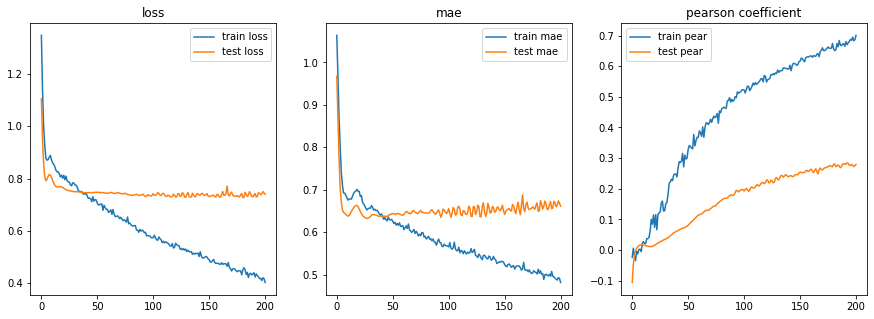

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(all_train_loss, label="train loss")
ax1.plot(all_test_loss, label="test loss")
ax1.legend(loc="best")
ax1.set_title("loss")

ax2.plot(all_train_mae, label="train mae")
ax2.plot(all_test_mae, label="test mae")
ax2.set_title("mae")
ax2.legend(loc="best")

ax3.plot(all_train_pear, label="train pear")
ax3.plot(all_test_pear, label="test pear")
ax3.set_title("pearson coefficient")
ax3.legend(loc="best")

# plt.show()

In [ ]:
# Instantiate model
model = RegressionModel(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])
model.load_state_dict(torch.load("/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_noneutral_regression/epoch179_testloss_0.7277_testmae_0.6488000154495239_testpear_0.28.pth"))

train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_no_neutral_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
if cuda:
    model.cuda()
loss_function = MaskedMSELoss()
train_loss, train_mae, train_pear,train_labels, train_preds, train_masks = train_or_eval_model(model, loss_function, train_loader, 1)
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, 1)


dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataload

In [ ]:
all_labels = np.concatenate([train_labels, test_label])
all_preds = np.concatenate([train_preds, test_pred])

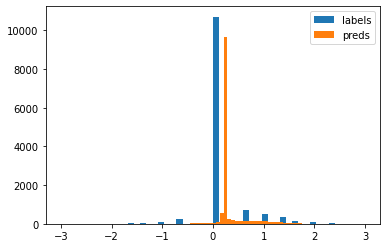

In [ ]:
import matplotlib.pyplot as plt

plt.hist(all_labels, bins=50, label="labels")
plt.hist(all_preds, bins=50, label="preds")
plt.legend()
plt.show()

In [ ]:
all_labels

array([0.6666667, 0.6666667, 1.6666666, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [ ]:
np.logical_and(all_labels<=0.5, all_labels >= -0.5).sum()

10711

In [ ]:
all_labels

array([1.6666666, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ], dtype=float32)

# Evaluate w full acoustic spanish data

In [ ]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch193_testloss_0.424_testmae_0.5020999908447266_testpear_0.3483.pth"))

<All keys matched successfully>

In [16]:
train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/11-777 MMML/multilogue-net/data/moseas_spanish_full_regression_full_acoustic.pickle', valid=0.0, batch_size=batch_size, num_workers=0)

In [17]:
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, 0)
print("Test Loss - spanish MOSEAS: ", test_loss)
print("Test MAE - spanish MOSEAS: ", test_mae)
print("Test Pear - spanish MOSEAS: ", test_pear)



Test Loss - spanish MOSEAS:  0.9988
Test MAE - spanish MOSEAS:  0.833
Test Pear - spanish MOSEAS:  0.2829


In [18]:
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, train_loader, 0)

In [19]:
print(test_loss, test_mae, test_pear)

0.9625 0.8098 0.3111


sanity check: check performance with french data

In [12]:
train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/11-777 MMML/multilogue-net/data/moseas_french_full_regression_full_acoustic.pickle', valid=0.0, batch_size=batch_size, num_workers=0)

In [13]:
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, 0)

/content/gdrive/.shortcut-targets-by-id/1sKygtzdMExNjy2GJE2k9Z6m8S3ehIYG3/11-777 MMML/multilogue-net/original_dataloader.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.FloatTensor(self.videoText[vid]),\


In [14]:
print(test_loss, test_mae, test_pear)

0.424 0.5021 0.3483


In [15]:
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, train_loader, 0)
print(test_loss, test_mae, test_pear)

0.3094 0.4263 0.6005
